In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import pathlib
from scipy import stats, optimize
from scipy.optimize import nnls

from tyssue.generation import generate_ring
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.config.draw import sheet_spec
from tyssue.draw.plt_draw import sheet_view
from tyssue.io.hdf5 import save_datasets

from tyssue.dynamics.planar_gradients import area_grad
from tyssue_taylor.adjusters.adjust_annular import (prepare_tensions, adjust_tensions,
                                                    adjust_areas, adjust_scale, adjust_parameters)
from tyssue_taylor.models.annular import AnnularGeometry as geom
from tyssue_taylor.models.annular import model, lumen_area_grad
from tyssue_taylor.adjusters.cost_functions import _distance
from tyssue_taylor.segmentation.segment2D import generate_ring_from_image, normalize_scale
from tyssue_taylor.adjusters.force_inference import infer_forces, _coef_matrix, _right_side
from tyssue_taylor.models.display import (create_organo, print_tensions, rendering_results,
                                          rendering_convergence_results,
                                          plot_force_inference)

Error: IPOPT shared library failed to import


Using TensorFlow backend.


In [2]:
def create_organo(nb_cells, r_in, r_out, seed=None, rot=None, geom=geom):
    organo = generate_ring(nb_cells, r_in, r_out)
    Nf = organo.Nf
    geom.update_all(organo)
    alpha = 1 + 1/(20*(organo.settings['R_out']-organo.settings['R_in']))
    specs = {
        'face': {
            'is_alive': 1,
            'prefered_area': organo.face_df.area,
            'area_elasticity': 1., },
        'edge': {
            'ux': 0.,
            'uy': 0.,
            'uz': 0.,
            'line_tension': 0.1,
            'is_active': 1
            },
        'vert': {
            'adhesion_strength': 0.,
            'x_ecm': 0.,
            'y_ecm': 0.,
            'is_active': 1
            },
        'settings': {
            'lumen_elasticity': 0.1,
            'lumen_prefered_vol': organo.settings['lumen_volume'],
            'lumen_volume': organo.settings['lumen_volume']
            }
        }
    organo.update_specs(specs, reset=True)
    normalize_scale(organo, geom, refer='edges')
    geom.update_all(organo)
    if seed is not None:
        symetric_tensions = set_init_point(organo.settings['R_in'],
                                           organo.settings['R_out'],
                                           organo.Nf, alpha)
        sin_mul = 1+(np.sin(np.linspace(0, 2*np.pi, organo.Nf,
                                        endpoint=False)))**2
        organo.face_df.prefered_area *= np.random.normal(1.0, 0.05, organo.Nf)
        organo.edge_df.line_tension = prepare_tensions(organo,
                                                       symetric_tensions)
        organo.edge_df.loc[:Nf-1, 'line_tension'] *= sin_mul*np.random.normal(
            1.0, 0.05, organo.Nf)
        geom.update_all(organo)
    if rot is not None:
        organo.vert_df.loc[:, 'x'] = (organo.vert_df.x.copy() * np.cos(rot) -
                                      organo.vert_df.y.copy() * np.sin(rot))
        print('rotated x',
              organo.vert_df.x.copy() * np.cos(rot) -
              organo.vert_df.y.copy() * np.sin(rot))
        organo.vert_df.loc[:, 'y'] = (organo.vert_df.x.copy() * np.sin(rot) +
                                      organo.vert_df.y.copy() * np.cos(rot))
        print('rotated y',
              organo.vert_df.x.copy() * np.sin(rot) +
              organo.vert_df.y.copy() * np.cos(rot))
        geom.update_all(organo)
    organo.vert_df[['x_ecm', 'y_ecm']] = organo.vert_df[['x', 'y']]
    organo.vert_df.loc[organo.basal_verts, 'adhesion_strength'] = 0.01
    new_tensions = organo.edge_df.line_tension
    organo.edge_df.loc[:, 'line_tension'] = new_tensions
    return organo

In [3]:
def get_sim_mat(Nf, Ra, Rb, sum_lbda=0.01):

    sin_t = np.sin(np.pi/Nf)
    sin_2t = np.sin(2*np.pi/Nf)

    A = 0.5 * (Rb**2 - Ra**2) * sin_2t
    dAdRa = - sin_2t * Ra
    dAdRb = sin_2t * Rb
    dladRa = dlbdRb = 2*sin_t

    # variables are
    # (A - A_0), \Lambda_a, \Lambda_h
    problem_mat = np.array(
        [
            [dAdRa, dladRa, -1],
            [dAdRb, 0,       1],
            [0,     1,       1]
        ])

    b = np.array([0, 0, sum_lbda])
    return problem_mat, b

In [4]:
def _infer_pol(eptm):    
    eptm.get_extra_indices()
    non_lateral_edges = np.concatenate((eptm.apical_edges,
                                        eptm.basal_edges))
    sym_height = (r_out-r_in)*np.cos(np.pi/eptm.Nf)
    polar_coefs = np.ones(eptm.Nf)
    for cell in range(eptm.Nf):
        api_vertex = eptm.edge_df.loc[eptm.apical_edges,
                                      ('srce', 'trgt')][eptm.edge_df.face == cell]
        coord_api_vertex = eptm.vert_df.loc[np.squeeze(api_vertex.values),
                                            ('x', 'y')].values
        coord_cell_center = np.squeeze(eptm.face_df.loc[[cell], ('x', 'y')].values)
        pos_param = np.dot(coord_cell_center - coord_api_vertex[0],
                           coord_cell_center - coord_api_vertex[1])
        comp = np.array((coord_api_vertex[1, 0] - coord_api_vertex[0, 0],
                         coord_api_vertex[1, 1] - coord_api_vertex[0, 1]))
        proj = coord_api_vertex[0] + pos_param * comp
        polar_coefs[cell] = np.linalg.norm(proj - coord_cell_center)
    return polar_coefs

In [5]:
def _system_set_up(eptm, params_in_sym_mesh, polar_coefs):
    matrix = _coef_matrix(eptm, sup_param='areas')
    constant = _right_side(eptm, matrix)
    matrix = matrix[:-1]
    constant = constant[:-1]
    avg_cste = [4*((params_in_sym_mesh[1:].sum()+params_in_sym_mesh[-1])/3 /
                   (abs(organo.face_df.area.mean() + params_in_sym_mesh[0]))**1.5)]*eptm.Nf
    for i in range(eptm.Nf):
        i_cell_line = np.zeros(4*eptm.Nf+1)
        index = np.squeeze(np.argwhere(eptm.edge_df.face.values == i))
        index_suiv = np.squeeze(np.argwhere(eptm.edge_df.face.values == (i+1)%eptm.Nf))
        index[-1] = index_suiv[-2]
        i_cell_line[index] = [polar_coefs[i], 1, 1, 1]
        matrix = np.vstack((matrix, i_cell_line))
    constant = np.concatenate((constant, avg_cste))
    return matrix, constant

In [6]:
def _tmp_infer_forces(sum_tensions, eptm):
    params_in_sym_mesh = np.linalg.solve(*get_sim_mat(nf, r_in, r_out,
                                                      sum_lbda=sum_tensions))
    polar_coefs = _infer_pol(eptm.copy())
    mat_eq_cst, residuals = nnls(*_system_set_up(eptm,
                                                 params_in_sym_mesh,
                                                 polar_coefs))
    tmp_organo = eptm.copy()
    tmp_organo.edge_df.loc[:, 'line_tension'] = prepare_tensions(tmp_organo,
                                                                 mat_eq_cst[:3*eptm.Nf])
    tmp_organo.face_df.loc[:, 'prefered_area'] = tmp_organo.face_df.area + mat_eq_cst[3*eptm.Nf:
                                                                                      4*eptm.Nf]
    tmp_organo.settings['lumen_prefered_vol'] = tmp_organo.settings['lumen_volume'] + mat_eq_cst[-1]
    Solver.find_energy_min(tmp_organo, geom, model)
    return tmp_organo    

In [7]:
def _opt_cst_obj(sum_tensions, eptm):
    th_eptm = eptm.copy()
    th_settings = eptm.settings.copy()
    exp_eptm = _tmp_infer_forces(sum_tensions, th_eptm).copy()
    eptm.settings['lumen_volume'] = th_settings['lumen_volume']
    dist = np.sum(np.linalg.norm(_distance(th_eptm, exp_eptm), axis=1))
    return dist

Reseting datasets values with new specs


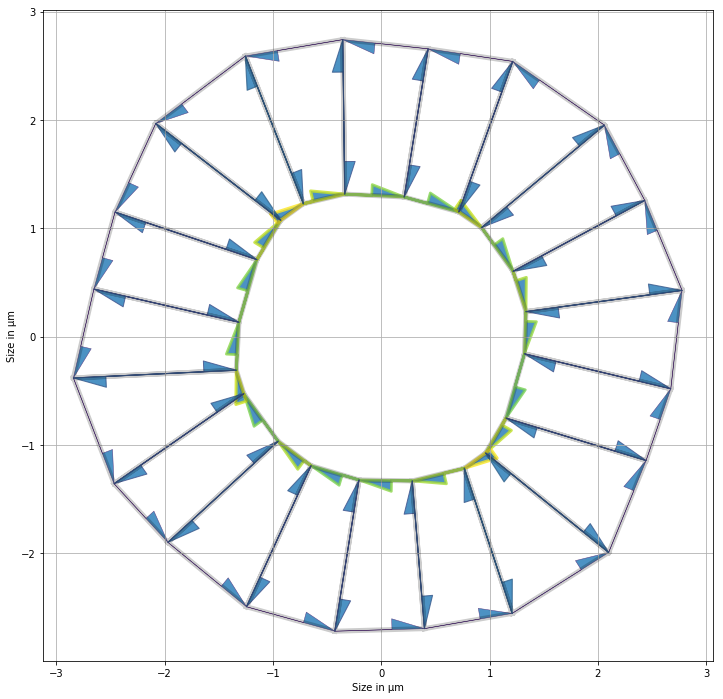

In [8]:
nf, r_in, r_out = (20, 1, 2)
seed = 1
organo = create_organo(nf, r_in, r_out)

organo.edge_df.loc[organo.apical_edges, 'line_tension'] = [
    0.101, 0.115, 0.126, 0.110, 0.105,
    0.102, 0.112, 0.102, 0.118, 0.105,
    0.104, 0.115, 0.127, 0.116, 0.106,
    0.103, 0.117, 0.105, 0.111, 0.107
]

organo.edge_df.loc[organo.basal_edges, 'line_tension'] = [
    0.01, 0.011, 0.012, 0.011, 0.01,
    0.01, 0.011, 0.01, 0.011, 0.01,
    0.01, 0.011, 0.012, 0.011, 0.01,
    0.01, 0.011, 0.01, 0.011, 0.01
]

organo.edge_df.loc[organo.lateral_edges, 'line_tension'] = np.array([
    0.03, 0.035, 0.04, 0.035, 0.03,
    0.03, 0.035, 0.03, 0.035, 0.03,
    0.03, 0.035, 0.04, 0.035, 0.03,
    0.03, 0.035, 0.03, 0.035, 0.03,
    0.03, 0.035, 0.04, 0.035, 0.03,
    0.03, 0.035, 0.03, 0.035, 0.03,
    0.03, 0.035, 0.04, 0.035, 0.03,
    0.03, 0.035, 0.03, 0.035, 0.03
])

organo.face_df.loc[:, 'prefered_area'] = np.array([
    0.08, 0.07, 0.08, 0.09, 0.09,
    0.10, 0.09, 0.08, 0.09, 0.09,
    0.10, 0.11, 0.10, 0.11, 0.12,
    0.11, 0.10, 0.09, 0.08, 0.09
]) + organo.face_df.area

geom.update_all(organo)
Solver.find_energy_min(organo, geom, model)
print_tensions(organo, organo)

## Cst opt

In [9]:
cst_opt_result = optimize.minimize_scalar(_opt_cst_obj,
                                          args=(organo.copy()),
                                          method='golden')

/home/felix/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


In [10]:
cst_opt_result_bounded = optimize.minimize_scalar(_opt_cst_obj,
                                                  bounds=[0, 1],
                                                  args=(organo.copy()),
                                                  method='bounded')

/home/felix/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


In [11]:
cst_opt_result, cst_opt_result_bounded

(     fun: 0.6825725926221872
     nfev: 51
      nit: 46
  success: True
        x: 0.02339578746818013,      fun: 0.6825725953598252
  message: 'Solution found.'
     nfev: 20
   status: 0
  success: True
        x: 0.023397123730442684)

## Matrice et constante de l'inférence de forces

In [12]:
matrix = _coef_matrix(organo, sup_param='areas')
constant = _right_side(organo, matrix)

Calcul des paramètres dans l'organoïde régulier

In [13]:
params_in_sym_mesh = np.linalg.solve(*get_sim_mat(nf, r_in, r_out, sum_lbda=cst_opt_result.x))

Calcul du "coefficient de polarisation", avec le 

In [14]:
organo.get_extra_indices()
non_lateral_edges = np.concatenate((organo.apical_edges,
                                    organo.basal_edges))
sym_height = (r_out-r_in)*np.cos(np.pi/organo.Nf)
polar_coefs = np.ones(organo.Nf)
for cell in range(organo.Nf):
    api_vertex = organo.edge_df.loc[organo.apical_edges,
                                    ('srce', 'trgt')][organo.edge_df.face == cell]
    coord_api_vertex = organo.vert_df.loc[np.squeeze(api_vertex.values),
                                          ('x', 'y')].values
    coord_cell_center = np.squeeze(organo.face_df.loc[[cell], ('x', 'y')].values)
    #((C(1,1)-A(1,1))*(B(1,1)-A(1,1)))+((C(1,2)-A(1,2))*(B(1,2)-A(1,2)))
    pos_param = np.dot(coord_cell_center - coord_api_vertex[0],
                       coord_cell_center - coord_api_vertex[1])
    comp = np.array((coord_api_vertex[1, 0] - coord_api_vertex[0, 0],
                     coord_api_vertex[1, 1] - coord_api_vertex[0, 1]))
    proj = coord_api_vertex[0] + pos_param * comp
    #api_vert = organo.vert_df.loc[organo.apical_verts[[cell, (cell+1)%organo.Nf]],
    #                              ('x', 'y')].values
    polar_coefs[cell] = np.linalg.norm(proj - coord_cell_center)
polar_coefs

/home/felix/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


array([0.68814571, 0.68960892, 0.68880027, 0.69274873, 0.6926759 ,
       0.70580654, 0.68949272, 0.70710696, 0.71211228, 0.71385017,
       0.69106288, 0.69941376, 0.70467986, 0.71160196, 0.70308148,
       0.71293015, 0.71254563, 0.71218888, 0.69801196, 0.69944966])

(100, 81) (100,)
[0.02708727 0.02756521 0.02772743 0.02692643 0.02726708 0.02628232
 0.02710758 0.02629715 0.02800563 0.0270869  0.02730395 0.02730519
 0.02772645 0.02743502 0.02762673 0.02699102 0.02782609 0.0264978
 0.02719897 0.02737922]
Apical tensions:  [0.02708727 0.02756521 0.02772743 0.02692643 0.02726708 0.02628232
 0.02710758 0.02629715 0.02800563 0.0270869  0.02730395 0.02730519
 0.02772645 0.02743502 0.02762673 0.02699102 0.02782609 0.0264978
 0.02719897 0.02737922] 
Basal tensions:  [0.00295881 0.00112997 0.         0.00170259 0.00265176 0.00242697
 0.00185321 0.00267145 0.00141126 0.00230298 0.00287157 0.00132193
 0.00014826 0.00120898 0.00260522 0.00250981 0.00133564 0.00223969
 0.0017999  0.00200318] 
Lateral tensions:  [0.01453482 0.01470774 0.01599662 0.01576186 0.01472954 0.01457094
 0.01529846 0.01500049 0.01458369 0.01490669 0.01429986 0.01480672
 0.0156213  0.01553874 0.01457595 0.01424204 0.01484986 0.0148341
 0.01490117 0.01515904] 
Area elasticity:  [0.01916933

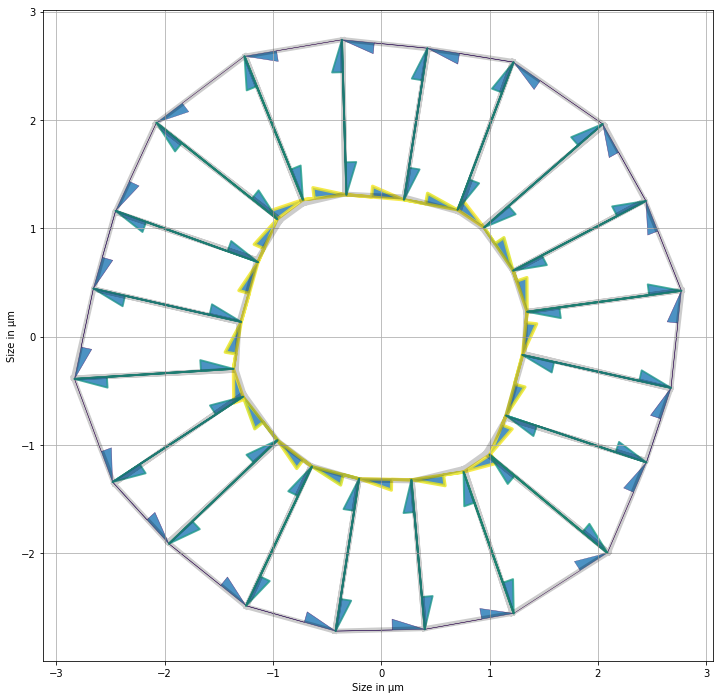

In [15]:
matrix = _coef_matrix(organo, sup_param='areas')
constant = _right_side(organo, matrix)
matrix = matrix[:-1]
constant = constant[:-1]
avg_cste = [4*((params_in_sym_mesh[1:].sum()+params_in_sym_mesh[-1])/3 /
               (organo.face_df.area.mean() + params_in_sym_mesh[0])**1.5)]*organo.Nf
for i in range(organo.Nf):
    i_cell_line = np.zeros(4*organo.Nf+1)
    index = np.squeeze(np.argwhere(organo.edge_df.face.values == i))
    index_suiv = np.squeeze(np.argwhere(organo.edge_df.face.values == (i+1)%organo.Nf))
    index[-1] = index_suiv[-2]
    #index[-1] = 40
    #print(index)
    i_cell_line[index] = [polar_coefs[i], 1, 1, 1]
    #print(i_cell_line)
    matrix = np.vstack((matrix, i_cell_line))
constant = np.concatenate((constant, avg_cste))
print(matrix.shape, constant.shape)
mat_eq_cst, residuals = nnls(matrix, constant)
organo_eq_cst = organo.copy()
organo_eq_cst.edge_df.loc[:, 'line_tension'] = prepare_tensions(organo_eq_cst,
                                                                 mat_eq_cst[:3*organo.Nf])
organo_eq_cst.face_df.loc[:, 'prefered_area'] = organo_eq_cst.face_df.area + mat_eq_cst[3*organo.Nf:
                                                                                          4*organo.Nf]
organo_eq_cst.settings['lumen_prefered_vol'] = organo_eq_cst.settings['lumen_volume'] + mat_eq_cst[-1]
Solver.find_energy_min(organo_eq_cst, geom, model)
print_tensions(organo_eq_cst, organo)
print(mat_eq_cst[organo.apical_edges])
print('Apical tensions: ', mat_eq_cst[organo.apical_edges],
      '\nBasal tensions: ', mat_eq_cst[organo.basal_edges],
      '\nLateral tensions: ', mat_eq_cst[organo.lateral_edges[:organo.Nf]],
      '\nArea elasticity: ', mat_eq_cst[organo.Nf*3:-1],
      '\nLumen area elasticity: ', mat_eq_cst[-1],
      '\nDistance from th org to exp org: ', np.sum(np.linalg.norm(_distance(organo_eq_cst, organo), axis=1)),
      '\nNNLS residuals: ', residuals)

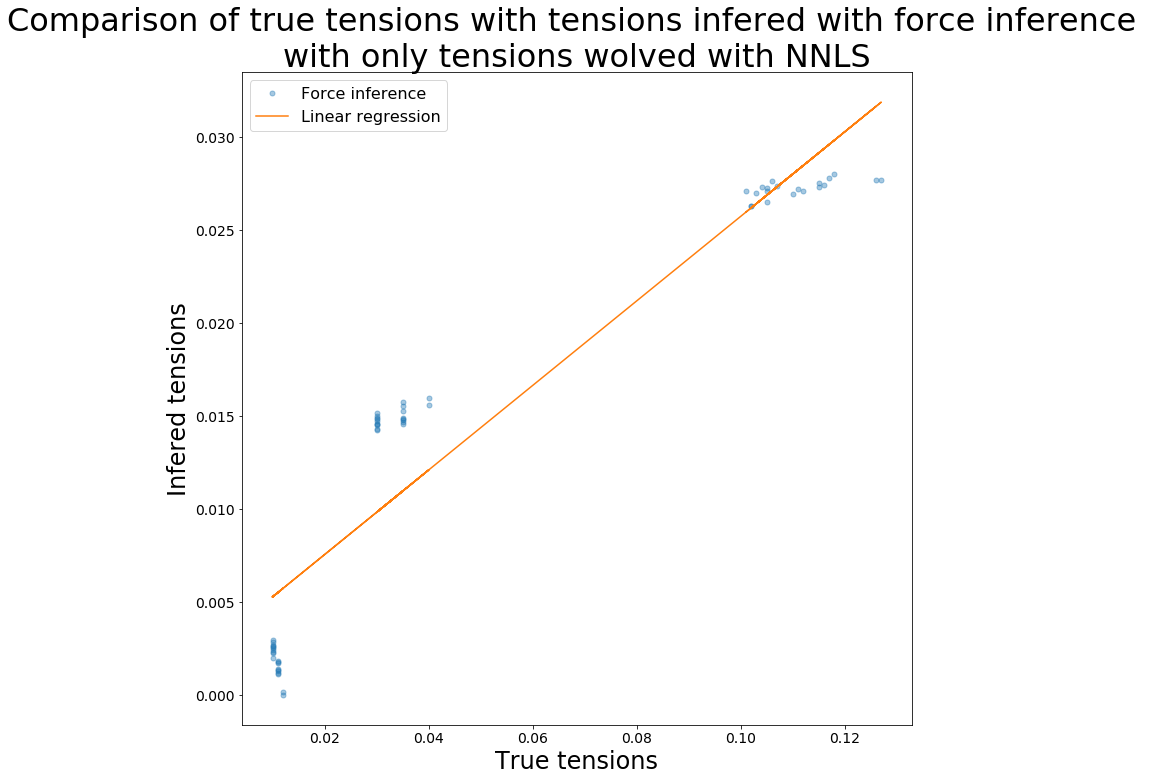

R value : 0.9420784996371543 
Standard error : 0.0030145274049768783


In [16]:
rendering_results(organo, organo.edge_df.line_tension[:3*organo.Nf],
                  mat_eq_cst[:3*organo.Nf],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

In [17]:
lm_opt = {'method': 'lm','xtol':1e-5,'ftol': 1e-3, 'verbose': 1}
start_copy = time.time()
iprint_file = "../../assets/dist_at_each_f_ev/14_03_eq_t_per_cell_new_criteria.txt"
to_opt_organo = organo.copy()
init_point_area_and_tensions_opt = np.concatenate((prepare_tensions(to_opt_organo, mat_eq_cst[:3*organo.Nf]),
                                                   to_opt_organo.face_df.area + mat_eq_cst[3*organo.Nf:-1],
                                                   [to_opt_organo.settings['lumen_volume'] + mat_eq_cst[-1]]))
res_2_cst_areas_copy = adjust_parameters(to_opt_organo,
                                    init_point_area_and_tensions_opt,
                                    {'dic':{'apical' : False, 'basal': False}, 'weight':0},
                                    COPY_OR_SYM='copy',                                    
                                    **lm_opt)
end_copy = time.time()
print('Execution time: ', start_copy - end_copy)

1.30032383379244 [0.04572649 0.03806565 0.04509429 0.05079313 0.00925012 0.02131458
 0.02226657 0.04825376 0.06323736 0.02688624 0.01343722 0.02801916
 0.02547858 0.0339002  0.01200692 0.02088457 0.03182123 0.05227248
 0.03025396 0.01108808 0.02837602 0.0530997  0.03128402 0.034721
 0.0265297  0.01543873 0.03713423 0.05249607 0.0594271  0.04060755
 0.02773098 0.02643512 0.00888844 0.0165266  0.01190409 0.02989201
 0.02672412 0.05551068 0.0452107  0.04233641 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.     

1.3003239306008694 [0.0457265  0.03806565 0.04509429 0.05079314 0.00925013 0.02131459
 0.02226657 0.04825376 0.06323736 0.02688623 0.01343722 0.02801916
 0.02547858 0.0339002  0.01200692 0.02088457 0.03182123 0.05227249
 0.03025396 0.01108808 0.02837603 0.0530997  0.03128403 0.03472101
 0.02652971 0.01543873 0.03713424 0.05249607 0.0594271  0.04060755
 0.02773098 0.02643513 0.00888843 0.0165266  0.01190409 0.02989202
 0.02672412 0.05551069 0.0452107  0.04233642 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.300323886299316 [0.0457265  0.03806565 0.04509429 0.05079313 0.00925012 0.02131458
 0.02226657 0.04825376 0.06323736 0.02688624 0.01343721 0.02801916
 0.02547858 0.0339002  0.01200692 0.02088457 0.03182123 0.05227248
 0.03025396 0.01108808 0.02837603 0.0530997  0.03128402 0.034721
 0.02652971 0.01543873 0.03713424 0.05249607 0.0594271  0.04060755
 0.02773099 0.02643513 0.00888843 0.0165266  0.01190409 0.02989202
 0.02672412 0.05551069 0.0452107  0.04233641 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.    

1.300323871832694 [0.04572649 0.03806565 0.04509429 0.05079313 0.00925012 0.02131458
 0.02226657 0.04825376 0.06323736 0.02688623 0.01343722 0.02801916
 0.02547858 0.0339002  0.01200692 0.02088457 0.03182123 0.05227248
 0.03025396 0.01108808 0.02837603 0.0530997  0.03128402 0.034721
 0.0265297  0.01543873 0.03713423 0.05249607 0.0594271  0.04060755
 0.02773098 0.02643513 0.00888843 0.01652659 0.01190409 0.02989202
 0.02672412 0.05551069 0.0452107  0.04233641 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.    

1.300323835601518 [0.04572649 0.03806565 0.04509429 0.05079313 0.00925012 0.02131458
 0.02226657 0.04825376 0.06323736 0.02688624 0.01343722 0.02801916
 0.02547858 0.0339002  0.01200692 0.02088457 0.03182123 0.05227248
 0.03025396 0.01108808 0.02837602 0.0530997  0.03128402 0.034721
 0.0265297  0.01543873 0.03713423 0.05249607 0.0594271  0.04060755
 0.02773098 0.02643512 0.00888844 0.0165266  0.01190409 0.02989201
 0.02672412 0.05551068 0.0452107  0.04233641 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.    

1.3003238360423346 [0.04572649 0.03806565 0.04509429 0.05079313 0.00925012 0.02131458
 0.02226657 0.04825376 0.06323736 0.02688624 0.01343722 0.02801916
 0.02547858 0.0339002  0.01200692 0.02088457 0.03182123 0.05227248
 0.03025396 0.01108808 0.02837602 0.0530997  0.03128402 0.034721
 0.0265297  0.01543873 0.03713423 0.05249607 0.0594271  0.04060755
 0.02773098 0.02643512 0.00888843 0.0165266  0.01190409 0.02989201
 0.02672412 0.05551068 0.0452107  0.04233641 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

1.3003238361754805 [0.04572649 0.03806565 0.04509429 0.05079313 0.00925012 0.02131458
 0.02226657 0.04825376 0.06323736 0.02688624 0.01343722 0.02801916
 0.02547858 0.0339002  0.01200692 0.02088457 0.03182123 0.05227248
 0.03025396 0.01108808 0.02837602 0.0530997  0.03128402 0.034721
 0.0265297  0.01543873 0.03713423 0.05249607 0.0594271  0.04060755
 0.02773098 0.02643512 0.00888844 0.0165266  0.01190409 0.02989201
 0.02672412 0.05551068 0.0452107  0.04233641 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

1.3003238400530728 [0.04572649 0.03806565 0.04509429 0.05079313 0.00925012 0.02131458
 0.02226657 0.04825376 0.06323736 0.02688624 0.01343722 0.02801916
 0.02547858 0.0339002  0.01200692 0.02088457 0.03182123 0.05227248
 0.03025396 0.01108808 0.02837602 0.0530997  0.03128402 0.034721
 0.0265297  0.01543873 0.03713423 0.05249607 0.0594271  0.04060755
 0.02773098 0.02643512 0.00888844 0.0165266  0.01190409 0.02989201
 0.02672412 0.05551068 0.0452107  0.04233641 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

1.300323841074494 [0.04572649 0.03806565 0.04509429 0.05079313 0.00925012 0.02131458
 0.02226656 0.04825376 0.06323736 0.02688624 0.01343722 0.02801916
 0.02547858 0.0339002  0.01200692 0.02088457 0.03182123 0.05227248
 0.03025396 0.01108808 0.02837602 0.0530997  0.03128402 0.034721
 0.02652971 0.01543873 0.03713423 0.05249606 0.0594271  0.04060755
 0.02773098 0.02643513 0.00888844 0.0165266  0.01190409 0.02989201
 0.02672412 0.05551068 0.0452107  0.04233641 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.    

1.3003238327486157 [0.04572649 0.03806565 0.04509429 0.05079313 0.00925012 0.02131458
 0.02226657 0.04825376 0.06323736 0.02688624 0.01343722 0.02801916
 0.02547858 0.0339002  0.01200692 0.02088457 0.03182123 0.05227248
 0.03025395 0.01108808 0.02837602 0.05309969 0.03128402 0.034721
 0.0265297  0.01543873 0.03713423 0.05249607 0.0594271  0.04060755
 0.02773098 0.02643513 0.00888844 0.0165266  0.01190408 0.02989201
 0.02672412 0.05551068 0.0452107  0.04233641 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

1.3003238268882262 [0.04572649 0.03806565 0.04509429 0.05079313 0.00925011 0.02131458
 0.02226657 0.04825376 0.06323736 0.02688624 0.01343722 0.02801916
 0.02547858 0.0339002  0.01200692 0.02088457 0.03182123 0.05227248
 0.03025395 0.01108808 0.02837602 0.05309969 0.03128402 0.034721
 0.0265297  0.01543873 0.03713423 0.05249606 0.0594271  0.04060755
 0.02773098 0.02643512 0.00888843 0.0165266  0.01190409 0.02989202
 0.02672411 0.05551069 0.0452107  0.04233641 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

1.30032383379244 [0.04572649 0.03806565 0.04509429 0.05079313 0.00925012 0.02131458
 0.02226657 0.04825376 0.06323736 0.02688624 0.01343722 0.02801916
 0.02547858 0.0339002  0.01200692 0.02088457 0.03182123 0.05227248
 0.03025396 0.01108808 0.02837602 0.0530997  0.03128402 0.034721
 0.0265297  0.01543873 0.03713423 0.05249607 0.0594271  0.04060755
 0.02773098 0.02643512 0.00888844 0.0165266  0.01190409 0.02989201
 0.02672412 0.05551068 0.0452107  0.04233641 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.     

1.30032383379244 [0.04572649 0.03806565 0.04509429 0.05079313 0.00925012 0.02131458
 0.02226657 0.04825376 0.06323736 0.02688624 0.01343722 0.02801916
 0.02547858 0.0339002  0.01200692 0.02088457 0.03182123 0.05227248
 0.03025396 0.01108808 0.02837602 0.0530997  0.03128402 0.034721
 0.0265297  0.01543873 0.03713423 0.05249607 0.0594271  0.04060755
 0.02773098 0.02643512 0.00888844 0.0165266  0.01190409 0.02989201
 0.02672412 0.05551068 0.0452107  0.04233641 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.     

1.30032383379244 [0.04572649 0.03806565 0.04509429 0.05079313 0.00925012 0.02131458
 0.02226657 0.04825376 0.06323736 0.02688624 0.01343722 0.02801916
 0.02547858 0.0339002  0.01200692 0.02088457 0.03182123 0.05227248
 0.03025396 0.01108808 0.02837602 0.0530997  0.03128402 0.034721
 0.0265297  0.01543873 0.03713423 0.05249607 0.0594271  0.04060755
 0.02773098 0.02643512 0.00888844 0.0165266  0.01190409 0.02989201
 0.02672412 0.05551068 0.0452107  0.04233641 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.     

1.3003191052591547 [0.04572623 0.03806552 0.04509455 0.05079304 0.00924987 0.0213145
 0.02226643 0.04825344 0.0632371  0.02688645 0.01343736 0.0280192
 0.02547878 0.0339004  0.012007   0.0208847  0.03182121 0.05227228
 0.03025376 0.01108782 0.02837584 0.05309938 0.03128382 0.03472088
 0.02652951 0.01543873 0.03713393 0.05249579 0.05942685 0.04060727
 0.02773081 0.02643503 0.0088885  0.01652655 0.01190408 0.02989184
 0.02672392 0.0555104  0.04521036 0.04233601 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

1.3003186674993632 [0.04572619 0.03806551 0.04509463 0.05079305 0.00924982 0.02131448
 0.02226642 0.04825339 0.06323707 0.02688651 0.0134374  0.02801922
 0.02547883 0.03390047 0.01200702 0.02088473 0.03182122 0.05227225
 0.03025373 0.01108777 0.02837581 0.05309933 0.03128379 0.03472087
 0.02652947 0.01543874 0.03713387 0.05249576 0.05942682 0.04060722
 0.02773078 0.02643503 0.00888852 0.01652655 0.01190408 0.02989182
 0.02672389 0.05551036 0.0452103  0.04233595 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.3003185529448995 [0.04572621 0.0380655  0.04509452 0.05079302 0.00924987 0.02131449
 0.02226643 0.04825343 0.06323708 0.02688643 0.01343735 0.02801918
 0.02547876 0.03390038 0.01200699 0.02088468 0.0318212  0.05227226
 0.03025376 0.01108782 0.02837583 0.05309936 0.03128381 0.03472086
 0.02652949 0.01543873 0.03713392 0.05249577 0.05942682 0.04060726
 0.02773079 0.02643502 0.00888849 0.01652655 0.01190407 0.02989183
 0.02672391 0.05551038 0.04521034 0.042336   0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.3003193199884864 [0.04572625 0.03806552 0.04509455 0.05079305 0.00924988 0.0213145
 0.02226644 0.04825345 0.06323711 0.02688645 0.01343736 0.0280192
 0.02547877 0.0339004  0.012007   0.02088469 0.03182122 0.05227228
 0.03025377 0.01108783 0.02837584 0.05309939 0.03128382 0.03472088
 0.02652951 0.01543873 0.03713394 0.0524958  0.05942685 0.04060728
 0.02773081 0.02643504 0.0088885  0.01652655 0.01190408 0.02989185
 0.02672392 0.05551041 0.04521037 0.04233602 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

0.5909874198795428 [1.26689099e-02 1.20001612e-02 3.45592936e-02 2.99693215e-02
 1.10957639e-02 7.48349496e-04 5.26542482e-03 1.09055974e-03
 2.34890677e-02 2.98332332e-02 1.87215961e-02 3.39464993e-02
 3.81940880e-02 4.81266694e-02 1.56793299e-02 1.96954695e-02
 1.44258748e-02 1.43976743e-02 6.68747252e-03 1.34846366e-02
 1.72641676e-03 1.10152506e-02 3.15408025e-02 1.93439673e-02
 1.41890134e-02 3.16550337e-03 5.03637574e-03 6.72797726e-03
 1.06081294e-02 6.94374047e-03 1.84072403e-03 1.89476980e-02
 1.26337389e-02 2.18007765e-02 4.87387211e-03 4.47441117e-03
 1.30208020e-02 6.02626156e-03 4.23028275e-03 8.76214444e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5909874225594361 [1.26689099e-02 1.20001635e-02 3.45592929e-02 2.99693218e-02
 1.10957644e-02 7.48350740e-04 5.26542524e-03 1.09055972e-03
 2.34890677e-02 2.98332332e-02 1.87215960e-02 3.39464992e-02
 3.81940879e-02 4.81266693e-02 1.56793299e-02 1.96954694e-02
 1.44258747e-02 1.43976742e-02 6.68747250e-03 1.34846364e-02
 1.72641733e-03 1.10152524e-02 3.15408008e-02 1.93439668e-02
 1.41890129e-02 3.16550259e-03 5.03637649e-03 6.72797701e-03
 1.06081293e-02 6.94374047e-03 1.84072400e-03 1.89476980e-02
 1.26337389e-02 2.18007765e-02 4.87387210e-03 4.47441117e-03
 1.30208020e-02 6.02626156e-03 4.23028276e-03 8.76214462e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5909874244053623 [1.26689099e-02 1.20001635e-02 3.45592929e-02 2.99693217e-02
 1.10957640e-02 7.48349542e-04 5.26542479e-03 1.09055981e-03
 2.34890674e-02 2.98332340e-02 1.87215948e-02 3.39464994e-02
 3.81940881e-02 4.81266693e-02 1.56793299e-02 1.96954695e-02
 1.44258748e-02 1.43976742e-02 6.68747251e-03 1.34846365e-02
 1.72641734e-03 1.10152524e-02 3.15408009e-02 1.93439669e-02
 1.41890133e-02 3.16550335e-03 5.03637571e-03 6.72797705e-03
 1.06081299e-02 6.94374224e-03 1.84072576e-03 1.89476974e-02
 1.26337387e-02 2.18007766e-02 4.87387213e-03 4.47441117e-03
 1.30208020e-02 6.02626157e-03 4.23028277e-03 8.76214463e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5909874159839096 [1.26689098e-02 1.20001635e-02 3.45592928e-02 2.99693216e-02
 1.10957640e-02 7.48349509e-04 5.26542481e-03 1.09055976e-03
 2.34890676e-02 2.98332331e-02 1.87215960e-02 3.39464990e-02
 3.81940875e-02 4.81266687e-02 1.56793278e-02 1.96954691e-02
 1.44258749e-02 1.43976742e-02 6.68747252e-03 1.34846364e-02
 1.72641736e-03 1.10152524e-02 3.15408008e-02 1.93439669e-02
 1.41890133e-02 3.16550330e-03 5.03637576e-03 6.72797724e-03
 1.06081294e-02 6.94374042e-03 1.84072407e-03 1.89476979e-02
 1.26337387e-02 2.18007778e-02 4.87387063e-03 4.47441070e-03
 1.30208018e-02 6.02626160e-03 4.23028276e-03 8.76214459e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.590987425956598 [1.26689099e-02 1.20001636e-02 3.45592931e-02 2.99693218e-02
 1.10957641e-02 7.48349583e-04 5.26542477e-03 1.09055970e-03
 2.34890677e-02 2.98332333e-02 1.87215962e-02 3.39464994e-02
 3.81940881e-02 4.81266695e-02 1.56793300e-02 1.96954696e-02
 1.44258745e-02 1.43976746e-02 6.68747236e-03 1.34846362e-02
 1.72641731e-03 1.10152525e-02 3.15408009e-02 1.93439670e-02
 1.41890134e-02 3.16550337e-03 5.03637574e-03 6.72797726e-03
 1.06081295e-02 6.94374047e-03 1.84072403e-03 1.89476980e-02
 1.26337389e-02 2.18007766e-02 4.87387216e-03 4.47441102e-03
 1.30208020e-02 6.02626328e-03 4.23028393e-03 8.76214470e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.5909874203759355 [1.26689099e-02 1.20001635e-02 3.45592928e-02 2.99693216e-02
 1.10957640e-02 7.48349581e-04 5.26542475e-03 1.09055969e-03
 2.34890676e-02 2.98332331e-02 1.87215961e-02 3.39464992e-02
 3.81940879e-02 4.81266692e-02 1.56793299e-02 1.96954695e-02
 1.44258747e-02 1.43976742e-02 6.68747245e-03 1.34846364e-02
 1.72641732e-03 1.10152524e-02 3.15408007e-02 1.93439669e-02
 1.41890133e-02 3.16550334e-03 5.03637573e-03 6.72797723e-03
 1.06081294e-02 6.94374043e-03 1.84072402e-03 1.89476979e-02
 1.26337389e-02 2.18007765e-02 4.87387211e-03 4.47441114e-03
 1.30208020e-02 6.02626155e-03 4.23028274e-03 8.76214459e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5909874202821794 [1.26689099e-02 1.20001635e-02 3.45592929e-02 2.99693216e-02
 1.10957640e-02 7.48349555e-04 5.26542457e-03 1.09055971e-03
 2.34890676e-02 2.98332331e-02 1.87215961e-02 3.39464992e-02
 3.81940879e-02 4.81266692e-02 1.56793299e-02 1.96954695e-02
 1.44258747e-02 1.43976742e-02 6.68747246e-03 1.34846364e-02
 1.72641732e-03 1.10152524e-02 3.15408008e-02 1.93439669e-02
 1.41890133e-02 3.16550336e-03 5.03637567e-03 6.72797723e-03
 1.06081294e-02 6.94374044e-03 1.84072402e-03 1.89476979e-02
 1.26337389e-02 2.18007765e-02 4.87387211e-03 4.47441114e-03
 1.30208020e-02 6.02626155e-03 4.23028275e-03 8.76214460e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5909874198195303 [1.26689099e-02 1.20001635e-02 3.45592928e-02 2.99693216e-02
 1.10957640e-02 7.48349579e-04 5.26542476e-03 1.09055969e-03
 2.34890676e-02 2.98332330e-02 1.87215963e-02 3.39464992e-02
 3.81940879e-02 4.81266692e-02 1.56793299e-02 1.96954695e-02
 1.44258747e-02 1.43976742e-02 6.68747246e-03 1.34846364e-02
 1.72641732e-03 1.10152524e-02 3.15408008e-02 1.93439669e-02
 1.41890133e-02 3.16550334e-03 5.03637573e-03 6.72797723e-03
 1.06081294e-02 6.94374015e-03 1.84072375e-03 1.89476979e-02
 1.26337388e-02 2.18007765e-02 4.87387211e-03 4.47441114e-03
 1.30208020e-02 6.02626155e-03 4.23028275e-03 8.76214460e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5909874203933673 [1.26689099e-02 1.20001635e-02 3.45592928e-02 2.99693216e-02
 1.10957640e-02 7.48349582e-04 5.26542475e-03 1.09055969e-03
 2.34890676e-02 2.98332331e-02 1.87215961e-02 3.39464992e-02
 3.81940879e-02 4.81266692e-02 1.56793299e-02 1.96954695e-02
 1.44258747e-02 1.43976742e-02 6.68747245e-03 1.34846364e-02
 1.72641732e-03 1.10152524e-02 3.15408008e-02 1.93439669e-02
 1.41890133e-02 3.16550334e-03 5.03637573e-03 6.72797723e-03
 1.06081294e-02 6.94374043e-03 1.84072402e-03 1.89476979e-02
 1.26337389e-02 2.18007764e-02 4.87387214e-03 4.47441114e-03
 1.30208020e-02 6.02626155e-03 4.23028274e-03 8.76214460e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5909874197496011 [1.26689099e-02 1.20001635e-02 3.45592929e-02 2.99693216e-02
 1.10957640e-02 7.48349580e-04 5.26542475e-03 1.09055969e-03
 2.34890676e-02 2.98332331e-02 1.87215961e-02 3.39464992e-02
 3.81940879e-02 4.81266692e-02 1.56793299e-02 1.96954695e-02
 1.44258747e-02 1.43976740e-02 6.68747233e-03 1.34846364e-02
 1.72641732e-03 1.10152524e-02 3.15408008e-02 1.93439669e-02
 1.41890133e-02 3.16550334e-03 5.03637573e-03 6.72797723e-03
 1.06081294e-02 6.94374044e-03 1.84072402e-03 1.89476979e-02
 1.26337389e-02 2.18007765e-02 4.87387211e-03 4.47441114e-03
 1.30208020e-02 6.02626121e-03 4.23028267e-03 8.76214461e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5909874263064971 [1.26689103e-02 1.20001647e-02 3.45592923e-02 2.99693217e-02
 1.10957642e-02 7.48349745e-04 5.26542466e-03 1.09055956e-03
 2.34890676e-02 2.98332332e-02 1.87215962e-02 3.39464995e-02
 3.81940879e-02 4.81266693e-02 1.56793299e-02 1.96954697e-02
 1.44258747e-02 1.43976741e-02 6.68747232e-03 1.34846360e-02
 1.72641865e-03 1.10152537e-02 3.15408022e-02 1.93439667e-02
 1.41890133e-02 3.16550338e-03 5.03637571e-03 6.72797721e-03
 1.06081294e-02 6.94374043e-03 1.84072405e-03 1.89476979e-02
 1.26337389e-02 2.18007766e-02 4.87387217e-03 4.47441111e-03
 1.30208020e-02 6.02626162e-03 4.23028280e-03 8.76214504e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5909874202157168 [1.26689100e-02 1.20001635e-02 3.45592928e-02 2.99693213e-02
 1.10957631e-02 7.48347014e-04 5.26542405e-03 1.09055946e-03
 2.34890674e-02 2.98332331e-02 1.87215961e-02 3.39464993e-02
 3.81940878e-02 4.81266691e-02 1.56793298e-02 1.96954696e-02
 1.44258747e-02 1.43976741e-02 6.68747235e-03 1.34846363e-02
 1.72641732e-03 1.10152524e-02 3.15408007e-02 1.93439672e-02
 1.41890143e-02 3.16550608e-03 5.03637692e-03 6.72797732e-03
 1.06081295e-02 6.94374040e-03 1.84072404e-03 1.89476979e-02
 1.26337388e-02 2.18007765e-02 4.87387214e-03 4.47441109e-03
 1.30208019e-02 6.02626155e-03 4.23028271e-03 8.76214457e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5909874204042577 [1.26689099e-02 1.20001634e-02 3.45592927e-02 2.99693215e-02
 1.10957640e-02 7.48349634e-04 5.26542471e-03 1.09055947e-03
 2.34890678e-02 2.98332351e-02 1.87215967e-02 3.39464992e-02
 3.81940876e-02 4.81266690e-02 1.56793298e-02 1.96954694e-02
 1.44258746e-02 1.43976741e-02 6.68747238e-03 1.34846363e-02
 1.72641729e-03 1.10152524e-02 3.15408006e-02 1.93439668e-02
 1.41890132e-02 3.16550331e-03 5.03637579e-03 6.72797762e-03
 1.06081285e-02 6.94373949e-03 1.84072464e-03 1.89476983e-02
 1.26337390e-02 2.18007764e-02 4.87387209e-03 4.47441110e-03
 1.30208019e-02 6.02626152e-03 4.23028271e-03 8.76214455e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5909874237274818 [1.26689100e-02 1.20001634e-02 3.45592927e-02 2.99693215e-02
 1.10957640e-02 7.48349660e-04 5.26542468e-03 1.09055960e-03
 2.34890674e-02 2.98332330e-02 1.87215961e-02 3.39464995e-02
 3.81940884e-02 4.81266721e-02 1.56793305e-02 1.96954698e-02
 1.44258745e-02 1.43976741e-02 6.68747235e-03 1.34846363e-02
 1.72641728e-03 1.10152524e-02 3.15408007e-02 1.93439668e-02
 1.41890133e-02 3.16550339e-03 5.03637566e-03 6.72797718e-03
 1.06081294e-02 6.94374044e-03 1.84072390e-03 1.89476980e-02
 1.26337392e-02 2.18007775e-02 4.87387067e-03 4.47441142e-03
 1.30208021e-02 6.02626150e-03 4.23028271e-03 8.76214455e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5909874228850097 [1.26689101e-02 1.20001634e-02 3.45592927e-02 2.99693215e-02
 1.10957640e-02 7.48349648e-04 5.26542469e-03 1.09055961e-03
 2.34890675e-02 2.98332330e-02 1.87215961e-02 3.39464992e-02
 3.81940878e-02 4.81266690e-02 1.56793297e-02 1.96954696e-02
 1.44258752e-02 1.43976766e-02 6.68747196e-03 1.34846365e-02
 1.72641730e-03 1.10152524e-02 3.15408007e-02 1.93439668e-02
 1.41890133e-02 3.16550337e-03 5.03637568e-03 6.72797719e-03
 1.06081294e-02 6.94374040e-03 1.84072402e-03 1.89476979e-02
 1.26337388e-02 2.18007765e-02 4.87387210e-03 4.47441143e-03
 1.30208021e-02 6.02626130e-03 4.23028398e-03 8.76214448e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5909874204649537 [1.26689100e-02 1.20001635e-02 3.45592929e-02 2.99693216e-02
 1.10957640e-02 7.48349583e-04 5.26542475e-03 1.09055969e-03
 2.34890676e-02 2.98332331e-02 1.87215961e-02 3.39464992e-02
 3.81940879e-02 4.81266692e-02 1.56793299e-02 1.96954695e-02
 1.44258747e-02 1.43976742e-02 6.68747245e-03 1.34846364e-02
 1.72641732e-03 1.10152524e-02 3.15408008e-02 1.93439669e-02
 1.41890133e-02 3.16550334e-03 5.03637573e-03 6.72797723e-03
 1.06081294e-02 6.94374044e-03 1.84072402e-03 1.89476979e-02
 1.26337389e-02 2.18007765e-02 4.87387211e-03 4.47441114e-03
 1.30208020e-02 6.02626155e-03 4.23028274e-03 8.76214460e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5909874204649537 [1.26689100e-02 1.20001635e-02 3.45592929e-02 2.99693216e-02
 1.10957640e-02 7.48349583e-04 5.26542475e-03 1.09055969e-03
 2.34890676e-02 2.98332331e-02 1.87215961e-02 3.39464992e-02
 3.81940879e-02 4.81266692e-02 1.56793299e-02 1.96954695e-02
 1.44258747e-02 1.43976742e-02 6.68747245e-03 1.34846364e-02
 1.72641732e-03 1.10152524e-02 3.15408008e-02 1.93439669e-02
 1.41890133e-02 3.16550334e-03 5.03637573e-03 6.72797723e-03
 1.06081294e-02 6.94374044e-03 1.84072402e-03 1.89476979e-02
 1.26337389e-02 2.18007765e-02 4.87387211e-03 4.47441114e-03
 1.30208020e-02 6.02626155e-03 4.23028274e-03 8.76214460e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5909874204649537 [1.26689100e-02 1.20001635e-02 3.45592929e-02 2.99693216e-02
 1.10957640e-02 7.48349583e-04 5.26542475e-03 1.09055969e-03
 2.34890676e-02 2.98332331e-02 1.87215961e-02 3.39464992e-02
 3.81940879e-02 4.81266692e-02 1.56793299e-02 1.96954695e-02
 1.44258747e-02 1.43976742e-02 6.68747245e-03 1.34846364e-02
 1.72641732e-03 1.10152524e-02 3.15408008e-02 1.93439669e-02
 1.41890133e-02 3.16550334e-03 5.03637573e-03 6.72797723e-03
 1.06081294e-02 6.94374044e-03 1.84072402e-03 1.89476979e-02
 1.26337389e-02 2.18007765e-02 4.87387211e-03 4.47441114e-03
 1.30208020e-02 6.02626155e-03 4.23028274e-03 8.76214460e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5909874204649537 [1.26689100e-02 1.20001635e-02 3.45592929e-02 2.99693216e-02
 1.10957640e-02 7.48349583e-04 5.26542475e-03 1.09055969e-03
 2.34890676e-02 2.98332331e-02 1.87215961e-02 3.39464992e-02
 3.81940879e-02 4.81266692e-02 1.56793299e-02 1.96954695e-02
 1.44258747e-02 1.43976742e-02 6.68747245e-03 1.34846364e-02
 1.72641732e-03 1.10152524e-02 3.15408008e-02 1.93439669e-02
 1.41890133e-02 3.16550334e-03 5.03637573e-03 6.72797723e-03
 1.06081294e-02 6.94374044e-03 1.84072402e-03 1.89476979e-02
 1.26337389e-02 2.18007765e-02 4.87387211e-03 4.47441114e-03
 1.30208020e-02 6.02626155e-03 4.23028274e-03 8.76214460e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5909874204649537 [1.26689100e-02 1.20001635e-02 3.45592929e-02 2.99693216e-02
 1.10957640e-02 7.48349583e-04 5.26542475e-03 1.09055969e-03
 2.34890676e-02 2.98332331e-02 1.87215961e-02 3.39464992e-02
 3.81940879e-02 4.81266692e-02 1.56793299e-02 1.96954695e-02
 1.44258747e-02 1.43976742e-02 6.68747245e-03 1.34846364e-02
 1.72641732e-03 1.10152524e-02 3.15408008e-02 1.93439669e-02
 1.41890133e-02 3.16550334e-03 5.03637573e-03 6.72797723e-03
 1.06081294e-02 6.94374044e-03 1.84072402e-03 1.89476979e-02
 1.26337389e-02 2.18007765e-02 4.87387211e-03 4.47441114e-03
 1.30208020e-02 6.02626155e-03 4.23028274e-03 8.76214460e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5909875707883783 [1.26689163e-02 1.20001699e-02 3.45592977e-02 2.99693302e-02
 1.10957660e-02 7.48352457e-04 5.26542323e-03 1.09055797e-03
 2.34890725e-02 2.98332406e-02 1.87216029e-02 3.39465103e-02
 3.81940992e-02 4.81266808e-02 1.56793344e-02 1.96954776e-02
 1.44258767e-02 1.43976771e-02 6.68747276e-03 1.34846368e-02
 1.72641690e-03 1.10152518e-02 3.15408142e-02 1.93439697e-02
 1.41890184e-02 3.16550585e-03 5.03637514e-03 6.72797798e-03
 1.06081334e-02 6.94374141e-03 1.84072426e-03 1.89477031e-02
 1.26337402e-02 2.18007836e-02 4.87387497e-03 4.47441081e-03
 1.30208056e-02 6.02626233e-03 4.23028144e-03 8.76214826e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5909874368212514 [1.26689102e-02 1.20001643e-02 3.45592942e-02 2.99693222e-02
 1.10957634e-02 7.48350670e-04 5.26542054e-03 1.09055970e-03
 2.34890681e-02 2.98332346e-02 1.87215965e-02 3.39465000e-02
 3.81940895e-02 4.81266706e-02 1.56793305e-02 1.96954700e-02
 1.44258753e-02 1.43976748e-02 6.68747276e-03 1.34846370e-02
 1.72641709e-03 1.10152525e-02 3.15408018e-02 1.93439684e-02
 1.41890152e-02 3.16549912e-03 5.03638050e-03 6.72797740e-03
 1.06081303e-02 6.94374019e-03 1.84072394e-03 1.89476986e-02
 1.26337390e-02 2.18007771e-02 4.87387241e-03 4.47441112e-03
 1.30208023e-02 6.02626162e-03 4.23028273e-03 8.76214464e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5909874637240697 [1.26689111e-02 1.20001640e-02 3.45592955e-02 2.99693236e-02
 1.10957645e-02 7.48350045e-04 5.26542484e-03 1.09055938e-03
 2.34890691e-02 2.98332304e-02 1.87216021e-02 3.39465014e-02
 3.81940901e-02 4.81266720e-02 1.56793307e-02 1.96954714e-02
 1.44258755e-02 1.43976748e-02 6.68747252e-03 1.34846369e-02
 1.72641707e-03 1.10152538e-02 3.15408027e-02 1.93439678e-02
 1.41890146e-02 3.16550440e-03 5.03637542e-03 6.72797783e-03
 1.06081284e-02 6.94374488e-03 1.84072632e-03 1.89477007e-02
 1.26337401e-02 2.18007777e-02 4.87387318e-03 4.47441089e-03
 1.30208025e-02 6.02626191e-03 4.23028252e-03 8.76214486e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5909875781309181 [1.26689164e-02 1.20001670e-02 3.45593028e-02 2.99693304e-02
 1.10957649e-02 7.48352328e-04 5.26542351e-03 1.09055807e-03
 2.34890729e-02 2.98332412e-02 1.87216024e-02 3.39465105e-02
 3.81941011e-02 4.81266789e-02 1.56793373e-02 1.96954784e-02
 1.44258765e-02 1.43976779e-02 6.68747313e-03 1.34846380e-02
 1.72641575e-03 1.10152560e-02 3.15408097e-02 1.93439709e-02
 1.41890197e-02 3.16550519e-03 5.03637583e-03 6.72797841e-03
 1.06081335e-02 6.94374172e-03 1.84072323e-03 1.89477040e-02
 1.26337402e-02 2.18007848e-02 4.87386955e-03 4.47441230e-03
 1.30208070e-02 6.02626148e-03 4.23028159e-03 8.76214751e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.5909873402511187 [1.26689057e-02 1.20001612e-02 3.45592880e-02 2.99693179e-02
 1.10957624e-02 7.48347397e-04 5.26542669e-03 1.09056148e-03
 2.34890654e-02 2.98332298e-02 1.87215910e-02 3.39464918e-02
 3.81940823e-02 4.81266635e-02 1.56793270e-02 1.96954636e-02
 1.44258750e-02 1.43976693e-02 6.68746975e-03 1.34846374e-02
 1.72641901e-03 1.10152504e-02 3.15407956e-02 1.93439638e-02
 1.41890107e-02 3.16550079e-03 5.03637679e-03 6.72797722e-03
 1.06081266e-02 6.94373985e-03 1.84072311e-03 1.89476954e-02
 1.26337381e-02 2.18007718e-02 4.87387016e-03 4.47441243e-03
 1.30207998e-02 6.02626463e-03 4.23028901e-03 8.76214254e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

5.284600678275378 [9.38776674e-02 1.82115073e-01 2.67189065e-01 2.75870572e-01
 1.94169911e-01 9.89984001e-02 1.63968808e-01 1.08248084e-01
 1.27207252e-01 1.11823050e-01 6.76365884e-02 7.77576850e-02
 1.31803508e-01 1.39431021e-01 1.26699387e-01 1.62557308e-01
 9.83410084e-02 8.72379825e-02 9.27426653e-02 7.44740916e-02
 1.44790234e-01 1.71913575e-01 2.45851417e-01 2.46325260e-01
 1.85823252e-01 1.81845444e-01 1.04004655e-01 1.33742718e-01
 1.23101099e-01 4.94921479e-02 8.59086787e-02 1.16437190e-01
 7.65112671e-02 1.76638325e-01 1.08502029e-01 8.64536294e-02
 1.02569792e-01 9.56936681e-02 7.42123725e-02 9.26309782e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.499552137870547 [1.10570887e-02 1.10659773e-02 3.18496731e-02 2.57119585e-02
 9.27333774e-03 8.52127696e-04 5.70464525e-03 1.47625500e-03
 1.89187598e-02 2.53077608e-02 1.52516125e-02 2.73153160e-02
 3.31494529e-02 4.04692539e-02 1.25990514e-02 1.54858856e-02
 1.33770590e-02 1.24419266e-02 6.30361216e-03 1.29963742e-02
 7.43126501e-04 1.07160123e-02 2.55040829e-02 1.61681229e-02
 1.32555970e-02 3.44765799e-03 3.06592893e-03 4.46990884e-03
 8.04644446e-03 6.50398774e-03 1.59550466e-03 1.44757677e-02
 1.21903096e-02 1.68369616e-02 5.63094869e-03 1.08530136e-03
 1.02166509e-02 4.62591117e-03 3.48955457e-03 6.87717242e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.499552142371762 [1.10570887e-02 1.10659777e-02 3.18496748e-02 2.57119600e-02
 9.27333827e-03 8.52128052e-04 5.70464391e-03 1.47625423e-03
 1.89187599e-02 2.53077608e-02 1.52516125e-02 2.73153161e-02
 3.31494530e-02 4.04692540e-02 1.25990515e-02 1.54858857e-02
 1.33770590e-02 1.24419266e-02 6.30361216e-03 1.29963742e-02
 7.43126408e-04 1.07160119e-02 2.55040840e-02 1.61681243e-02
 1.32555965e-02 3.44765829e-03 3.06592909e-03 4.46990868e-03
 8.04644411e-03 6.50398778e-03 1.59550471e-03 1.44757677e-02
 1.21903096e-02 1.68369617e-02 5.63094871e-03 1.08530136e-03
 1.02166509e-02 4.62591119e-03 3.48955459e-03 6.87717250e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.49955214808657583 [1.10570887e-02 1.10659777e-02 3.18496748e-02 2.57119600e-02
 9.27333814e-03 8.52127869e-04 5.70464519e-03 1.47625499e-03
 1.89187598e-02 2.53077610e-02 1.52516145e-02 2.73153176e-02
 3.31494532e-02 4.04692540e-02 1.25990515e-02 1.54858857e-02
 1.33770590e-02 1.24419266e-02 6.30361215e-03 1.29963742e-02
 7.43126421e-04 1.07160119e-02 2.55040840e-02 1.61681243e-02
 1.32555967e-02 3.44765786e-03 3.06592897e-03 4.46990879e-03
 8.04644458e-03 6.50398727e-03 1.59550381e-03 1.44757694e-02
 1.21903090e-02 1.68369618e-02 5.63094877e-03 1.08530135e-03
 1.02166509e-02 4.62591119e-03 3.48955458e-03 6.87717251e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.4995521442058188 [1.10570887e-02 1.10659776e-02 3.18496746e-02 2.57119599e-02
 9.27333810e-03 8.52127829e-04 5.70464521e-03 1.47625500e-03
 1.89187598e-02 2.53077608e-02 1.52516125e-02 2.73153159e-02
 3.31494528e-02 4.04692538e-02 1.25990532e-02 1.54858856e-02
 1.33770591e-02 1.24419266e-02 6.30361218e-03 1.29963742e-02
 7.43126385e-04 1.07160119e-02 2.55040839e-02 1.61681243e-02
 1.32555966e-02 3.44765779e-03 3.06592901e-03 4.46990886e-03
 8.04644446e-03 6.50398774e-03 1.59550466e-03 1.44757677e-02
 1.21903095e-02 1.68369614e-02 5.63094994e-03 1.08530063e-03
 1.02166504e-02 4.62591120e-03 3.48955454e-03 6.87717249e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4995521411023298 [1.10570886e-02 1.10659778e-02 3.18496748e-02 2.57119600e-02
 9.27333813e-03 8.52127859e-04 5.70464520e-03 1.47625498e-03
 1.89187598e-02 2.53077609e-02 1.52516126e-02 2.73153161e-02
 3.31494530e-02 4.04692540e-02 1.25990515e-02 1.54858857e-02
 1.33770590e-02 1.24419267e-02 6.30361130e-03 1.29963727e-02
 7.43127024e-04 1.07160118e-02 2.55040839e-02 1.61681244e-02
 1.32555967e-02 3.44765784e-03 3.06592899e-03 4.46990885e-03
 8.04644449e-03 6.50398775e-03 1.59550468e-03 1.44757678e-02
 1.21903096e-02 1.68369617e-02 5.63094871e-03 1.08530129e-03
 1.02166509e-02 4.62591068e-03 3.48955493e-03 6.87717121e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.49955214430512124 [1.10570888e-02 1.10659777e-02 3.18496748e-02 2.57119599e-02
 9.27333813e-03 8.52127904e-04 5.70464515e-03 1.47625492e-03
 1.89187598e-02 2.53077608e-02 1.52516126e-02 2.73153161e-02
 3.31494530e-02 4.04692539e-02 1.25990515e-02 1.54858858e-02
 1.33770590e-02 1.24419266e-02 6.30361210e-03 1.29963742e-02
 7.43126437e-04 1.07160119e-02 2.55040841e-02 1.61681244e-02
 1.32555967e-02 3.44765787e-03 3.06592897e-03 4.46990883e-03
 8.04644448e-03 6.50398774e-03 1.59550470e-03 1.44757677e-02
 1.21903096e-02 1.68369617e-02 5.63094872e-03 1.08530134e-03
 1.02166509e-02 4.62591118e-03 3.48955456e-03 6.87717250e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.49955214410782117 [1.10570888e-02 1.10659777e-02 3.18496747e-02 2.57119599e-02
 9.27333814e-03 8.52127902e-04 5.70464516e-03 1.47625491e-03
 1.89187598e-02 2.53077608e-02 1.52516126e-02 2.73153161e-02
 3.31494530e-02 4.04692539e-02 1.25990515e-02 1.54858858e-02
 1.33770590e-02 1.24419266e-02 6.30361210e-03 1.29963742e-02
 7.43126435e-04 1.07160119e-02 2.55040840e-02 1.61681243e-02
 1.32555967e-02 3.44765787e-03 3.06592899e-03 4.46990889e-03
 8.04644447e-03 6.50398774e-03 1.59550470e-03 1.44757677e-02
 1.21903096e-02 1.68369617e-02 5.63094872e-03 1.08530134e-03
 1.02166509e-02 4.62591118e-03 3.48955456e-03 6.87717250e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.4995521437134875 [1.10570888e-02 1.10659777e-02 3.18496747e-02 2.57119599e-02
 9.27333813e-03 8.52127901e-04 5.70464515e-03 1.47625493e-03
 1.89187598e-02 2.53077609e-02 1.52516125e-02 2.73153161e-02
 3.31494530e-02 4.04692539e-02 1.25990515e-02 1.54858858e-02
 1.33770590e-02 1.24419266e-02 6.30361211e-03 1.29963742e-02
 7.43126434e-04 1.07160119e-02 2.55040840e-02 1.61681243e-02
 1.32555967e-02 3.44765786e-03 3.06592897e-03 4.46990883e-03
 8.04644449e-03 6.50398771e-03 1.59550472e-03 1.44757676e-02
 1.21903095e-02 1.68369617e-02 5.63094872e-03 1.08530134e-03
 1.02166509e-02 4.62591118e-03 3.48955456e-03 6.87717250e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4995521439632648 [1.10570888e-02 1.10659777e-02 3.18496747e-02 2.57119599e-02
 9.27333813e-03 8.52127902e-04 5.70464516e-03 1.47625493e-03
 1.89187598e-02 2.53077608e-02 1.52516126e-02 2.73153161e-02
 3.31494530e-02 4.04692539e-02 1.25990513e-02 1.54858858e-02
 1.33770590e-02 1.24419266e-02 6.30361211e-03 1.29963742e-02
 7.43126433e-04 1.07160119e-02 2.55040840e-02 1.61681243e-02
 1.32555967e-02 3.44765786e-03 3.06592897e-03 4.46990883e-03
 8.04644448e-03 6.50398774e-03 1.59550470e-03 1.44757677e-02
 1.21903096e-02 1.68369617e-02 5.63094854e-03 1.08530149e-03
 1.02166509e-02 4.62591118e-03 3.48955456e-03 6.87717250e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4995521442730429 [1.10570888e-02 1.10659777e-02 3.18496747e-02 2.57119599e-02
 9.27333813e-03 8.52127904e-04 5.70464515e-03 1.47625493e-03
 1.89187598e-02 2.53077608e-02 1.52516126e-02 2.73153161e-02
 3.31494530e-02 4.04692539e-02 1.25990515e-02 1.54858858e-02
 1.33770590e-02 1.24419266e-02 6.30361209e-03 1.29963742e-02
 7.43126437e-04 1.07160119e-02 2.55040840e-02 1.61681243e-02
 1.32555967e-02 3.44765786e-03 3.06592897e-03 4.46990883e-03
 8.04644448e-03 6.50398774e-03 1.59550470e-03 1.44757677e-02
 1.21903096e-02 1.68369617e-02 5.63094872e-03 1.08530133e-03
 1.02166509e-02 4.62591116e-03 3.48955460e-03 6.87717264e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4995521410655363 [1.10570888e-02 1.10659783e-02 3.18496766e-02 2.57119601e-02
 9.27333829e-03 8.52128041e-04 5.70464505e-03 1.47625487e-03
 1.89187596e-02 2.53077606e-02 1.52516126e-02 2.73153160e-02
 3.31494527e-02 4.04692536e-02 1.25990514e-02 1.54858857e-02
 1.33770588e-02 1.24419265e-02 6.30361201e-03 1.29963739e-02
 7.43126253e-04 1.07160110e-02 2.55040827e-02 1.61681238e-02
 1.32555964e-02 3.44765776e-03 3.06592896e-03 4.46990879e-03
 8.04644444e-03 6.50398767e-03 1.59550472e-03 1.44757676e-02
 1.21903095e-02 1.68369616e-02 5.63094869e-03 1.08530132e-03
 1.02166508e-02 4.62591115e-03 3.48955455e-03 6.87717258e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.499552142029038 [1.10570889e-02 1.10659776e-02 3.18496746e-02 2.57119597e-02
 9.27333779e-03 8.52127651e-04 5.70464762e-03 1.47625477e-03
 1.89187595e-02 2.53077608e-02 1.52516127e-02 2.73153161e-02
 3.31494528e-02 4.04692538e-02 1.25990514e-02 1.54858858e-02
 1.33770589e-02 1.24419265e-02 6.30361201e-03 1.29963741e-02
 7.43126477e-04 1.07160119e-02 2.55040839e-02 1.61681244e-02
 1.32555970e-02 3.44765699e-03 3.06592646e-03 4.46990943e-03
 8.04644479e-03 6.50398768e-03 1.59550471e-03 1.44757677e-02
 1.21903095e-02 1.68369617e-02 5.63094872e-03 1.08530130e-03
 1.02166509e-02 4.62591115e-03 3.48955451e-03 6.87717247e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.4995521459626258 [1.10570889e-02 1.10659777e-02 3.18496747e-02 2.57119599e-02
 9.27333813e-03 8.52128003e-04 5.70464504e-03 1.47625474e-03
 1.89187597e-02 2.53077602e-02 1.52516111e-02 2.73153161e-02
 3.31494526e-02 4.04692538e-02 1.25990515e-02 1.54858859e-02
 1.33770589e-02 1.24419265e-02 6.30361199e-03 1.29963741e-02
 7.43126503e-04 1.07160119e-02 2.55040840e-02 1.61681243e-02
 1.32555967e-02 3.44765793e-03 3.06592893e-03 4.46990893e-03
 8.04644424e-03 6.50398888e-03 1.59550739e-03 1.44757690e-02
 1.21903100e-02 1.68369616e-02 5.63094869e-03 1.08530129e-03
 1.02166509e-02 4.62591115e-03 3.48955450e-03 6.87717248e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4995521487986959 [1.10570890e-02 1.10659777e-02 3.18496748e-02 2.57119599e-02
 9.27333817e-03 8.52128019e-04 5.70464505e-03 1.47625480e-03
 1.89187598e-02 2.53077608e-02 1.52516128e-02 2.73153165e-02
 3.31494532e-02 4.04692539e-02 1.25990523e-02 1.54858865e-02
 1.33770586e-02 1.24419265e-02 6.30361197e-03 1.29963741e-02
 7.43126504e-04 1.07160120e-02 2.55040841e-02 1.61681244e-02
 1.32555967e-02 3.44765796e-03 3.06592891e-03 4.46990879e-03
 8.04644450e-03 6.50398774e-03 1.59550474e-03 1.44757678e-02
 1.21903096e-02 1.68369624e-02 5.63095000e-03 1.08530150e-03
 1.02166514e-02 4.62591115e-03 3.48955456e-03 6.87717249e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4995521439086185 [1.10570891e-02 1.10659775e-02 3.18496746e-02 2.57119598e-02
 9.27333812e-03 8.52127993e-04 5.70464505e-03 1.47625482e-03
 1.89187597e-02 2.53077608e-02 1.52516127e-02 2.73153162e-02
 3.31494529e-02 4.04692538e-02 1.25990514e-02 1.54858859e-02
 1.33770590e-02 1.24419261e-02 6.30361466e-03 1.29963745e-02
 7.43126077e-04 1.07160120e-02 2.55040840e-02 1.61681243e-02
 1.32555967e-02 3.44765792e-03 3.06592891e-03 4.46990878e-03
 8.04644447e-03 6.50398770e-03 1.59550475e-03 1.44757677e-02
 1.21903095e-02 1.68369617e-02 5.63094875e-03 1.08530146e-03
 1.02166509e-02 4.62591233e-03 3.48955193e-03 6.87717214e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4995521440038622 [1.10570888e-02 1.10659777e-02 3.18496747e-02 2.57119599e-02
 9.27333813e-03 8.52127905e-04 5.70464515e-03 1.47625492e-03
 1.89187598e-02 2.53077608e-02 1.52516126e-02 2.73153161e-02
 3.31494530e-02 4.04692539e-02 1.25990515e-02 1.54858858e-02
 1.33770590e-02 1.24419266e-02 6.30361210e-03 1.29963742e-02
 7.43126435e-04 1.07160119e-02 2.55040840e-02 1.61681243e-02
 1.32555967e-02 3.44765786e-03 3.06592897e-03 4.46990883e-03
 8.04644448e-03 6.50398774e-03 1.59550470e-03 1.44757677e-02
 1.21903096e-02 1.68369617e-02 5.63094872e-03 1.08530134e-03
 1.02166509e-02 4.62591118e-03 3.48955456e-03 6.87717250e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4995521440038622 [1.10570888e-02 1.10659777e-02 3.18496747e-02 2.57119599e-02
 9.27333813e-03 8.52127905e-04 5.70464515e-03 1.47625492e-03
 1.89187598e-02 2.53077608e-02 1.52516126e-02 2.73153161e-02
 3.31494530e-02 4.04692539e-02 1.25990515e-02 1.54858858e-02
 1.33770590e-02 1.24419266e-02 6.30361210e-03 1.29963742e-02
 7.43126435e-04 1.07160119e-02 2.55040840e-02 1.61681243e-02
 1.32555967e-02 3.44765786e-03 3.06592897e-03 4.46990883e-03
 8.04644448e-03 6.50398774e-03 1.59550470e-03 1.44757677e-02
 1.21903096e-02 1.68369617e-02 5.63094872e-03 1.08530134e-03
 1.02166509e-02 4.62591118e-03 3.48955456e-03 6.87717250e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4995521440038622 [1.10570888e-02 1.10659777e-02 3.18496747e-02 2.57119599e-02
 9.27333813e-03 8.52127905e-04 5.70464515e-03 1.47625492e-03
 1.89187598e-02 2.53077608e-02 1.52516126e-02 2.73153161e-02
 3.31494530e-02 4.04692539e-02 1.25990515e-02 1.54858858e-02
 1.33770590e-02 1.24419266e-02 6.30361210e-03 1.29963742e-02
 7.43126435e-04 1.07160119e-02 2.55040840e-02 1.61681243e-02
 1.32555967e-02 3.44765786e-03 3.06592897e-03 4.46990883e-03
 8.04644448e-03 6.50398774e-03 1.59550470e-03 1.44757677e-02
 1.21903096e-02 1.68369617e-02 5.63094872e-03 1.08530134e-03
 1.02166509e-02 4.62591118e-03 3.48955456e-03 6.87717250e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4995521440038622 [1.10570888e-02 1.10659777e-02 3.18496747e-02 2.57119599e-02
 9.27333813e-03 8.52127905e-04 5.70464515e-03 1.47625492e-03
 1.89187598e-02 2.53077608e-02 1.52516126e-02 2.73153161e-02
 3.31494530e-02 4.04692539e-02 1.25990515e-02 1.54858858e-02
 1.33770590e-02 1.24419266e-02 6.30361210e-03 1.29963742e-02
 7.43126435e-04 1.07160119e-02 2.55040840e-02 1.61681243e-02
 1.32555967e-02 3.44765786e-03 3.06592897e-03 4.46990883e-03
 8.04644448e-03 6.50398774e-03 1.59550470e-03 1.44757677e-02
 1.21903096e-02 1.68369617e-02 5.63094872e-03 1.08530134e-03
 1.02166509e-02 4.62591118e-03 3.48955456e-03 6.87717250e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4995521440038622 [1.10570888e-02 1.10659777e-02 3.18496747e-02 2.57119599e-02
 9.27333813e-03 8.52127905e-04 5.70464515e-03 1.47625492e-03
 1.89187598e-02 2.53077608e-02 1.52516126e-02 2.73153161e-02
 3.31494530e-02 4.04692539e-02 1.25990515e-02 1.54858858e-02
 1.33770590e-02 1.24419266e-02 6.30361210e-03 1.29963742e-02
 7.43126435e-04 1.07160119e-02 2.55040840e-02 1.61681243e-02
 1.32555967e-02 3.44765786e-03 3.06592897e-03 4.46990883e-03
 8.04644448e-03 6.50398774e-03 1.59550470e-03 1.44757677e-02
 1.21903096e-02 1.68369617e-02 5.63094872e-03 1.08530134e-03
 1.02166509e-02 4.62591118e-03 3.48955456e-03 6.87717250e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.499552149426448 [1.10570884e-02 1.10659784e-02 3.18496755e-02 2.57119596e-02
 9.27333913e-03 8.52127943e-04 5.70464569e-03 1.47625525e-03
 1.89187603e-02 2.53077614e-02 1.52516125e-02 2.73153164e-02
 3.31494533e-02 4.04692550e-02 1.25990513e-02 1.54858855e-02
 1.33770597e-02 1.24419272e-02 6.30361256e-03 1.29963748e-02
 7.43125418e-04 1.07160105e-02 2.55040842e-02 1.61681233e-02
 1.32555953e-02 3.44765640e-03 3.06593017e-03 4.46990950e-03
 8.04644445e-03 6.50398823e-03 1.59550395e-03 1.44757680e-02
 1.21903103e-02 1.68369615e-02 5.63094869e-03 1.08530175e-03
 1.02166512e-02 4.62591136e-03 3.48955530e-03 6.87717295e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.4995521523688788 [1.10570884e-02 1.10659777e-02 3.18496750e-02 2.57119602e-02
 9.27333758e-03 8.52126841e-04 5.70464495e-03 1.47625306e-03
 1.89187598e-02 2.53077617e-02 1.52516125e-02 2.73153160e-02
 3.31494532e-02 4.04692547e-02 1.25990511e-02 1.54858854e-02
 1.33770596e-02 1.24419272e-02 6.30361256e-03 1.29963749e-02
 7.43125710e-04 1.07160118e-02 2.55040841e-02 1.61681250e-02
 1.32555973e-02 3.44765601e-03 3.06593317e-03 4.46991188e-03
 8.04644578e-03 6.50398776e-03 1.59550386e-03 1.44757681e-02
 1.21903102e-02 1.68369613e-02 5.63094878e-03 1.08530172e-03
 1.02166512e-02 4.62591127e-03 3.48955523e-03 6.87717260e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4995521565743241 [1.10570881e-02 1.10659774e-02 3.18496754e-02 2.57119608e-02
 9.27333829e-03 8.52126733e-04 5.70464663e-03 1.47625567e-03
 1.89187609e-02 2.53077606e-02 1.52516112e-02 2.73153165e-02
 3.31494523e-02 4.04692561e-02 1.25990509e-02 1.54858850e-02
 1.33770605e-02 1.24419279e-02 6.30361311e-03 1.29963760e-02
 7.43124743e-04 1.07160121e-02 2.55040839e-02 1.61681249e-02
 1.32555963e-02 3.44765586e-03 3.06593104e-03 4.46991030e-03
 8.04644342e-03 6.50399048e-03 1.59549897e-03 1.44757727e-02
 1.21903127e-02 1.68369601e-02 5.63094859e-03 1.08530213e-03
 1.02166514e-02 4.62591123e-03 3.48955590e-03 6.87717277e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.49955215067184167 [1.10570887e-02 1.10659778e-02 3.18496755e-02 2.57119604e-02
 9.27333798e-03 8.52128280e-04 5.70464489e-03 1.47625512e-03
 1.89187601e-02 2.53077612e-02 1.52516124e-02 2.73153156e-02
 3.31494542e-02 4.04692531e-02 1.25990473e-02 1.54858898e-02
 1.33770576e-02 1.24419268e-02 6.30361215e-03 1.29963738e-02
 7.43127205e-04 1.07160124e-02 2.55040846e-02 1.61681242e-02
 1.32555975e-02 3.44765878e-03 3.06592813e-03 4.46990841e-03
 8.04644461e-03 6.50398723e-03 1.59550509e-03 1.44757685e-02
 1.21903089e-02 1.68369634e-02 5.63094965e-03 1.08530195e-03
 1.02166526e-02 4.62591087e-03 3.48955438e-03 6.87717233e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.4995521534484009 [1.10570889e-02 1.10659766e-02 3.18496750e-02 2.57119605e-02
 9.27333813e-03 8.52127415e-04 5.70464591e-03 1.47625537e-03
 1.89187603e-02 2.53077613e-02 1.52516124e-02 2.73153160e-02
 3.31494533e-02 4.04692548e-02 1.25990511e-02 1.54858853e-02
 1.33770600e-02 1.24419267e-02 6.30361073e-03 1.29963753e-02
 7.43124080e-04 1.07160128e-02 2.55040844e-02 1.61681246e-02
 1.32555967e-02 3.44765686e-03 3.06593005e-03 4.46990961e-03
 8.04644430e-03 6.50398838e-03 1.59550370e-03 1.44757682e-02
 1.21903104e-02 1.68369615e-02 5.63094871e-03 1.08530217e-03
 1.02166511e-02 4.62591305e-03 3.48955895e-03 6.87717152e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4215045319143376 [9.04654739e-03 9.88981057e-03 2.90688500e-02 2.04221145e-02
 6.14711294e-03 1.39653568e-03 7.32107625e-03 2.23893026e-03
 1.35773840e-02 2.00081030e-02 1.06185910e-02 1.85647473e-02
 2.74314980e-02 3.07299249e-02 8.14759903e-03 1.00756426e-02
 1.34157217e-02 1.03080410e-02 6.80021627e-03 1.37748426e-02
 4.18458515e-03 1.18866210e-02 1.65438914e-02 1.35240384e-02
 1.24971915e-02 3.82272519e-03 1.19400182e-03 3.07544651e-03
 6.96343874e-03 6.58697389e-03 3.48325275e-03 1.06808063e-02
 1.26282947e-02 1.17393223e-02 8.28268898e-03 5.04444828e-03
 6.19212367e-03 5.17851304e-03 4.49211235e-03 4.52075343e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4215045291997189 [9.04654593e-03 9.88980848e-03 2.90688500e-02 2.04221146e-02
 6.14711463e-03 1.39653442e-03 7.32107627e-03 2.23893028e-03
 1.35773841e-02 2.00081030e-02 1.06185910e-02 1.85647474e-02
 2.74314981e-02 3.07299250e-02 8.14759907e-03 1.00756427e-02
 1.34157217e-02 1.03080410e-02 6.80021622e-03 1.37748425e-02
 4.18458657e-03 1.18866194e-02 1.65438919e-02 1.35240378e-02
 1.24971930e-02 3.82272394e-03 1.19400127e-03 3.07544631e-03
 6.96343867e-03 6.58697386e-03 3.48325282e-03 1.06808064e-02
 1.26282947e-02 1.17393224e-02 8.28268899e-03 5.04444837e-03
 6.19212367e-03 5.17851306e-03 4.49211248e-03 4.52075385e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.42150452836596347 [9.04654597e-03 9.88980856e-03 2.90688501e-02 2.04221147e-02
 6.14711300e-03 1.39653577e-03 7.32107628e-03 2.23893031e-03
 1.35773835e-02 2.00081016e-02 1.06185908e-02 1.85647475e-02
 2.74314982e-02 3.07299251e-02 8.14759909e-03 1.00756428e-02
 1.34157218e-02 1.03080410e-02 6.80021623e-03 1.37748425e-02
 4.18458655e-03 1.18866194e-02 1.65438920e-02 1.35240385e-02
 1.24971916e-02 3.82272526e-03 1.19400162e-03 3.07544626e-03
 6.96343846e-03 6.58697325e-03 3.48325349e-03 1.06808062e-02
 1.26282947e-02 1.17393224e-02 8.28268903e-03 5.04444838e-03
 6.19212369e-03 5.17851309e-03 4.49211251e-03 4.52075387e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.4215045274817149 [9.04654597e-03 9.88980857e-03 2.90688501e-02 2.04221147e-02
 6.14711300e-03 1.39653573e-03 7.32107627e-03 2.23893025e-03
 1.35773841e-02 2.00081032e-02 1.06185911e-02 1.85647473e-02
 2.74314967e-02 3.07299242e-02 8.14759872e-03 1.00756427e-02
 1.34157218e-02 1.03080410e-02 6.80021625e-03 1.37748425e-02
 4.18458653e-03 1.18866194e-02 1.65438920e-02 1.35240385e-02
 1.24971916e-02 3.82272523e-03 1.19400180e-03 3.07544651e-03
 6.96343875e-03 6.58697384e-03 3.48325283e-03 1.06808067e-02
 1.26282938e-02 1.17393213e-02 8.28268939e-03 5.04444855e-03
 6.19212363e-03 5.17851309e-03 4.49211252e-03 4.52075388e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4215045288267488 [9.04654595e-03 9.88980859e-03 2.90688501e-02 2.04221147e-02
 6.14711298e-03 1.39653575e-03 7.32107623e-03 2.23893022e-03
 1.35773841e-02 2.00081031e-02 1.06185911e-02 1.85647475e-02
 2.74314982e-02 3.07299251e-02 8.14759925e-03 1.00756427e-02
 1.34157205e-02 1.03080400e-02 6.80021622e-03 1.37748425e-02
 4.18458660e-03 1.18866194e-02 1.65438920e-02 1.35240385e-02
 1.24971916e-02 3.82272527e-03 1.19400174e-03 3.07544647e-03
 6.96343874e-03 6.58697388e-03 3.48325284e-03 1.06808064e-02
 1.26282948e-02 1.17393223e-02 8.28268887e-03 5.04444877e-03
 6.19212285e-03 5.17851348e-03 4.49211232e-03 4.52075394e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.42150452920851506 [9.04654588e-03 9.88980828e-03 2.90688500e-02 2.04221146e-02
 6.14711295e-03 1.39653574e-03 7.32107620e-03 2.23893020e-03
 1.35773840e-02 2.00081030e-02 1.06185911e-02 1.85647474e-02
 2.74314981e-02 3.07299250e-02 8.14759908e-03 1.00756428e-02
 1.34157217e-02 1.03080410e-02 6.80021619e-03 1.37748425e-02
 4.18458676e-03 1.18866190e-02 1.65438919e-02 1.35240384e-02
 1.24971916e-02 3.82272524e-03 1.19400176e-03 3.07544648e-03
 6.96343872e-03 6.58697386e-03 3.48325281e-03 1.06808064e-02
 1.26282947e-02 1.17393223e-02 8.28268900e-03 5.04444836e-03
 6.19212366e-03 5.17851306e-03 4.49211247e-03 4.52075382e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.421504529758864 [9.04654598e-03 9.88980854e-03 2.90688500e-02 2.04221146e-02
 6.14711276e-03 1.39653594e-03 7.32107621e-03 2.23893019e-03
 1.35773840e-02 2.00081030e-02 1.06185911e-02 1.85647475e-02
 2.74314981e-02 3.07299250e-02 8.14759908e-03 1.00756428e-02
 1.34157217e-02 1.03080410e-02 6.80021618e-03 1.37748424e-02
 4.18458656e-03 1.18866194e-02 1.65438919e-02 1.35240384e-02
 1.24971913e-02 3.82272540e-03 1.19400174e-03 3.07544646e-03
 6.96343871e-03 6.58697386e-03 3.48325282e-03 1.06808064e-02
 1.26282947e-02 1.17393223e-02 8.28268900e-03 5.04444838e-03
 6.19212366e-03 5.17851306e-03 4.49211248e-03 4.52075385e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.42150452987196313 [9.04654598e-03 9.88980854e-03 2.90688500e-02 2.04221146e-02
 6.14711295e-03 1.39653575e-03 7.32107619e-03 2.23893019e-03
 1.35773840e-02 2.00081030e-02 1.06185911e-02 1.85647475e-02
 2.74314981e-02 3.07299250e-02 8.14759908e-03 1.00756428e-02
 1.34157217e-02 1.03080410e-02 6.80021618e-03 1.37748424e-02
 4.18458656e-03 1.18866194e-02 1.65438919e-02 1.35240384e-02
 1.24971916e-02 3.82272525e-03 1.19400175e-03 3.07544648e-03
 6.96343874e-03 6.58697389e-03 3.48325282e-03 1.06808064e-02
 1.26282947e-02 1.17393223e-02 8.28268900e-03 5.04444838e-03
 6.19212366e-03 5.17851306e-03 4.49211248e-03 4.52075385e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.4215045298416451 [9.04654598e-03 9.88980854e-03 2.90688500e-02 2.04221146e-02
 6.14711295e-03 1.39653575e-03 7.32107619e-03 2.23893019e-03
 1.35773840e-02 2.00081030e-02 1.06185911e-02 1.85647475e-02
 2.74314981e-02 3.07299250e-02 8.14759908e-03 1.00756428e-02
 1.34157217e-02 1.03080410e-02 6.80021618e-03 1.37748424e-02
 4.18458656e-03 1.18866194e-02 1.65438919e-02 1.35240384e-02
 1.24971916e-02 3.82272525e-03 1.19400175e-03 3.07544648e-03
 6.96343872e-03 6.58697386e-03 3.48325282e-03 1.06808064e-02
 1.26282947e-02 1.17393224e-02 8.28268900e-03 5.04444838e-03
 6.19212366e-03 5.17851306e-03 4.49211248e-03 4.52075385e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4215045298518552 [9.04654598e-03 9.88980854e-03 2.90688500e-02 2.04221146e-02
 6.14711295e-03 1.39653575e-03 7.32107619e-03 2.23893019e-03
 1.35773840e-02 2.00081030e-02 1.06185911e-02 1.85647475e-02
 2.74314981e-02 3.07299250e-02 8.14759908e-03 1.00756428e-02
 1.34157217e-02 1.03080410e-02 6.80021618e-03 1.37748424e-02
 4.18458656e-03 1.18866194e-02 1.65438919e-02 1.35240384e-02
 1.24971916e-02 3.82272525e-03 1.19400175e-03 3.07544648e-03
 6.96343872e-03 6.58697386e-03 3.48325282e-03 1.06808064e-02
 1.26282947e-02 1.17393223e-02 8.28268900e-03 5.04444838e-03
 6.19212368e-03 5.17851306e-03 4.49211248e-03 4.52075385e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4215045326224503 [9.04654423e-03 9.88980791e-03 2.90688498e-02 2.04221146e-02
 6.14711297e-03 1.39653586e-03 7.32107609e-03 2.23893006e-03
 1.35773840e-02 2.00081030e-02 1.06185913e-02 1.85647477e-02
 2.74314981e-02 3.07299250e-02 8.14759917e-03 1.00756430e-02
 1.34157217e-02 1.03080408e-02 6.80021593e-03 1.37748420e-02
 4.18458864e-03 1.18866204e-02 1.65438924e-02 1.35240385e-02
 1.24971916e-02 3.82272533e-03 1.19400168e-03 3.07544642e-03
 6.96343869e-03 6.58697383e-03 3.48325291e-03 1.06808064e-02
 1.26282947e-02 1.17393224e-02 8.28268903e-03 5.04444849e-03
 6.19212365e-03 5.17851315e-03 4.49211288e-03 4.52075487e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.42150453283388195 [9.04654616e-03 9.88980872e-03 2.90688501e-02 2.04221142e-02
 6.14711381e-03 1.39653672e-03 7.32107589e-03 2.23893000e-03
 1.35773840e-02 2.00081030e-02 1.06185913e-02 1.85647477e-02
 2.74314981e-02 3.07299250e-02 8.14759917e-03 1.00756430e-02
 1.34157216e-02 1.03080409e-02 6.80021607e-03 1.37748424e-02
 4.18458661e-03 1.18866193e-02 1.65438920e-02 1.35240398e-02
 1.24971920e-02 3.82272405e-03 1.19400204e-03 3.07544658e-03
 6.96343874e-03 6.58697383e-03 3.48325290e-03 1.06808064e-02
 1.26282947e-02 1.17393224e-02 8.28268902e-03 5.04444850e-03
 6.19212363e-03 5.17851301e-03 4.49211245e-03 4.52075386e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.4215045303448818 [9.04654606e-03 9.88980856e-03 2.90688499e-02 2.04221145e-02
 6.14711287e-03 1.39653575e-03 7.32107601e-03 2.23892980e-03
 1.35773863e-02 2.00081035e-02 1.06185914e-02 1.85647475e-02
 2.74314980e-02 3.07299249e-02 8.14759912e-03 1.00756429e-02
 1.34157216e-02 1.03080409e-02 6.80021609e-03 1.37748424e-02
 4.18458661e-03 1.18866193e-02 1.65438919e-02 1.35240384e-02
 1.24971916e-02 3.82272526e-03 1.19400201e-03 3.07544681e-03
 6.96343671e-03 6.58697416e-03 3.48325246e-03 1.06808065e-02
 1.26282947e-02 1.17393223e-02 8.28268898e-03 5.04444844e-03
 6.19212363e-03 5.17851301e-03 4.49211244e-03 4.52075383e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4215045278153241 [9.04654597e-03 9.88980849e-03 2.90688498e-02 2.04221144e-02
 6.14711289e-03 1.39653578e-03 7.32107609e-03 2.23893011e-03
 1.35773839e-02 2.00081027e-02 1.06185910e-02 1.85647480e-02
 2.74315002e-02 3.07299250e-02 8.14759931e-03 1.00756428e-02
 1.34157215e-02 1.03080408e-02 6.80021608e-03 1.37748423e-02
 4.18458657e-03 1.18866193e-02 1.65438918e-02 1.35240383e-02
 1.24971915e-02 3.82272525e-03 1.19400172e-03 3.07544644e-03
 6.96343868e-03 6.58697396e-03 3.48325276e-03 1.06808057e-02
 1.26282932e-02 1.17393222e-02 8.28268869e-03 5.04444825e-03
 6.19212366e-03 5.17851301e-03 4.49211243e-03 4.52075381e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.42150453016321066 [9.04654607e-03 9.88980852e-03 2.90688499e-02 2.04221145e-02
 6.14711290e-03 1.39653580e-03 7.32107610e-03 2.23893011e-03
 1.35773839e-02 2.00081029e-02 1.06185911e-02 1.85647475e-02
 2.74314979e-02 3.07299248e-02 8.14759883e-03 1.00756432e-02
 1.34157240e-02 1.03080411e-02 6.80021600e-03 1.37748423e-02
 4.18458659e-03 1.18866193e-02 1.65438919e-02 1.35240383e-02
 1.24971916e-02 3.82272528e-03 1.19400169e-03 3.07544642e-03
 6.96343866e-03 6.58697380e-03 3.48325285e-03 1.06808064e-02
 1.26282947e-02 1.17393224e-02 8.28268926e-03 5.04444782e-03
 6.19212219e-03 5.17851397e-03 4.49211250e-03 4.52075378e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.4215045298287354 [9.04654598e-03 9.88980854e-03 2.90688500e-02 2.04221146e-02
 6.14711295e-03 1.39653575e-03 7.32107619e-03 2.23893019e-03
 1.35773840e-02 2.00081030e-02 1.06185911e-02 1.85647475e-02
 2.74314981e-02 3.07299250e-02 8.14759908e-03 1.00756428e-02
 1.34157217e-02 1.03080410e-02 6.80021618e-03 1.37748424e-02
 4.18458656e-03 1.18866194e-02 1.65438919e-02 1.35240384e-02
 1.24971916e-02 3.82272525e-03 1.19400175e-03 3.07544648e-03
 6.96343872e-03 6.58697386e-03 3.48325282e-03 1.06808064e-02
 1.26282947e-02 1.17393223e-02 8.28268900e-03 5.04444838e-03
 6.19212366e-03 5.17851306e-03 4.49211248e-03 4.52075385e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4215045298287354 [9.04654598e-03 9.88980854e-03 2.90688500e-02 2.04221146e-02
 6.14711295e-03 1.39653575e-03 7.32107619e-03 2.23893019e-03
 1.35773840e-02 2.00081030e-02 1.06185911e-02 1.85647475e-02
 2.74314981e-02 3.07299250e-02 8.14759908e-03 1.00756428e-02
 1.34157217e-02 1.03080410e-02 6.80021618e-03 1.37748424e-02
 4.18458656e-03 1.18866194e-02 1.65438919e-02 1.35240384e-02
 1.24971916e-02 3.82272525e-03 1.19400175e-03 3.07544648e-03
 6.96343872e-03 6.58697386e-03 3.48325282e-03 1.06808064e-02
 1.26282947e-02 1.17393223e-02 8.28268900e-03 5.04444838e-03
 6.19212366e-03 5.17851306e-03 4.49211248e-03 4.52075385e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4215045298287354 [9.04654598e-03 9.88980854e-03 2.90688500e-02 2.04221146e-02
 6.14711295e-03 1.39653575e-03 7.32107619e-03 2.23893019e-03
 1.35773840e-02 2.00081030e-02 1.06185911e-02 1.85647475e-02
 2.74314981e-02 3.07299250e-02 8.14759908e-03 1.00756428e-02
 1.34157217e-02 1.03080410e-02 6.80021618e-03 1.37748424e-02
 4.18458656e-03 1.18866194e-02 1.65438919e-02 1.35240384e-02
 1.24971916e-02 3.82272525e-03 1.19400175e-03 3.07544648e-03
 6.96343872e-03 6.58697386e-03 3.48325282e-03 1.06808064e-02
 1.26282947e-02 1.17393223e-02 8.28268900e-03 5.04444838e-03
 6.19212366e-03 5.17851306e-03 4.49211248e-03 4.52075385e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4215045298287354 [9.04654598e-03 9.88980854e-03 2.90688500e-02 2.04221146e-02
 6.14711295e-03 1.39653575e-03 7.32107619e-03 2.23893019e-03
 1.35773840e-02 2.00081030e-02 1.06185911e-02 1.85647475e-02
 2.74314981e-02 3.07299250e-02 8.14759908e-03 1.00756428e-02
 1.34157217e-02 1.03080410e-02 6.80021618e-03 1.37748424e-02
 4.18458656e-03 1.18866194e-02 1.65438919e-02 1.35240384e-02
 1.24971916e-02 3.82272525e-03 1.19400175e-03 3.07544648e-03
 6.96343872e-03 6.58697386e-03 3.48325282e-03 1.06808064e-02
 1.26282947e-02 1.17393223e-02 8.28268900e-03 5.04444838e-03
 6.19212366e-03 5.17851306e-03 4.49211248e-03 4.52075385e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4215045298287354 [9.04654598e-03 9.88980854e-03 2.90688500e-02 2.04221146e-02
 6.14711295e-03 1.39653575e-03 7.32107619e-03 2.23893019e-03
 1.35773840e-02 2.00081030e-02 1.06185911e-02 1.85647475e-02
 2.74314981e-02 3.07299250e-02 8.14759908e-03 1.00756428e-02
 1.34157217e-02 1.03080410e-02 6.80021618e-03 1.37748424e-02
 4.18458656e-03 1.18866194e-02 1.65438919e-02 1.35240384e-02
 1.24971916e-02 3.82272525e-03 1.19400175e-03 3.07544648e-03
 6.96343872e-03 6.58697386e-03 3.48325282e-03 1.06808064e-02
 1.26282947e-02 1.17393223e-02 8.28268900e-03 5.04444838e-03
 6.19212366e-03 5.17851306e-03 4.49211248e-03 4.52075385e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.42150456532694197 [9.04654796e-03 9.88980647e-03 2.90688514e-02 2.04221170e-02
 6.14711273e-03 1.39653728e-03 7.32107525e-03 2.23892946e-03
 1.35773851e-02 2.00081042e-02 1.06185929e-02 1.85647496e-02
 2.74315007e-02 3.07299269e-02 8.14760069e-03 1.00756459e-02
 1.34157215e-02 1.03080413e-02 6.80021605e-03 1.37748410e-02
 4.18458484e-03 1.18866242e-02 1.65438955e-02 1.35240387e-02
 1.24971945e-02 3.82272757e-03 1.19399947e-03 3.07544509e-03
 6.96343830e-03 6.58697306e-03 3.48325523e-03 1.06808088e-02
 1.26282950e-02 1.17393235e-02 8.28268930e-03 5.04445191e-03
 6.19212361e-03 5.17851241e-03 4.49211226e-03 4.52075548e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.421504495141471 [9.04654247e-03 9.88980679e-03 2.90688483e-02 2.04221120e-02
 6.14710932e-03 1.39653796e-03 7.32107795e-03 2.23893199e-03
 1.35773835e-02 2.00081027e-02 1.06185882e-02 1.85647441e-02
 2.74314957e-02 3.07299237e-02 8.14759653e-03 1.00756379e-02
 1.34157231e-02 1.03080414e-02 6.80021700e-03 1.37748442e-02
 4.18458182e-03 1.18866182e-02 1.65438896e-02 1.35240403e-02
 1.24971897e-02 3.82271675e-03 1.19400690e-03 3.07544990e-03
 6.96344007e-03 6.58697551e-03 3.48324914e-03 1.06808034e-02
 1.26282949e-02 1.17393211e-02 8.28268916e-03 5.04444288e-03
 6.19212419e-03 5.17851491e-03 4.49211456e-03 4.52075391e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.4215045194538832 [9.04654463e-03 9.88980784e-03 2.90688494e-02 2.04221139e-02
 6.14711321e-03 1.39653466e-03 7.32107717e-03 2.23893079e-03
 1.35773816e-02 2.00081028e-02 1.06185904e-02 1.85647457e-02
 2.74314972e-02 3.07299247e-02 8.14759786e-03 1.00756408e-02
 1.34157225e-02 1.03080412e-02 6.80021660e-03 1.37748432e-02
 4.18458466e-03 1.18866190e-02 1.65438913e-02 1.35240387e-02
 1.24971900e-02 3.82272363e-03 1.19400389e-03 3.07544790e-03
 6.96344165e-03 6.58697601e-03 3.48324962e-03 1.06808063e-02
 1.26282951e-02 1.17393218e-02 8.28268929e-03 5.04444601e-03
 6.19212379e-03 5.17851401e-03 4.49211342e-03 4.52075399e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4215045439494646 [9.04654665e-03 9.88980895e-03 2.90688511e-02 2.04221156e-02
 6.14711271e-03 1.39653645e-03 7.32107599e-03 2.23893000e-03
 1.35773846e-02 2.00081035e-02 1.06185913e-02 1.85647486e-02
 2.74314992e-02 3.07299240e-02 8.14760032e-03 1.00756441e-02
 1.34157216e-02 1.03080413e-02 6.80021628e-03 1.37748425e-02
 4.18458757e-03 1.18866200e-02 1.65438928e-02 1.35240386e-02
 1.24971930e-02 3.82272602e-03 1.19400092e-03 3.07544606e-03
 6.96343869e-03 6.58697379e-03 3.48325391e-03 1.06808065e-02
 1.26282953e-02 1.17393229e-02 8.28268807e-03 5.04444900e-03
 6.19212390e-03 5.17851289e-03 4.49211226e-03 4.52075379e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4215044824350093 [9.04654164e-03 9.88980573e-03 2.90688471e-02 2.04221119e-02
 6.14711338e-03 1.39653330e-03 7.32107858e-03 2.23893227e-03
 1.35773831e-02 2.00081022e-02 1.06185874e-02 1.85647431e-02
 2.74314946e-02 3.07299226e-02 8.14759503e-03 1.00756372e-02
 1.34157220e-02 1.03080397e-02 6.80021700e-03 1.37748444e-02
 4.18458090e-03 1.18866184e-02 1.65438893e-02 1.35240382e-02
 1.24971869e-02 3.82272056e-03 1.19400636e-03 3.07544971e-03
 6.96344000e-03 6.58697570e-03 3.48324851e-03 1.06808029e-02
 1.26282949e-02 1.17393211e-02 8.28268998e-03 5.04444119e-03
 6.19212494e-03 5.17851922e-03 4.49211516e-03 4.52075300e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.4215047505850685 [9.04654522e-03 9.88981123e-03 2.90688665e-02 2.04221299e-02
 6.14711489e-03 1.39653537e-03 7.32108314e-03 2.23893674e-03
 1.35773958e-02 2.00081156e-02 1.06185899e-02 1.85647475e-02
 2.74315149e-02 3.07299405e-02 8.14760295e-03 1.00756428e-02
 1.34157300e-02 1.03080509e-02 6.80022479e-03 1.37748504e-02
 4.18459153e-03 1.18866251e-02 1.65439006e-02 1.35240435e-02
 1.24972013e-02 3.82272854e-03 1.19399925e-03 3.07544568e-03
 6.96344150e-03 6.58697501e-03 3.48325712e-03 1.06808156e-02
 1.26282987e-02 1.17393287e-02 8.28269100e-03 5.04445486e-03
 6.19212729e-03 5.17851450e-03 4.49211246e-03 4.52075622e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.38608314197379473 [8.22185982e-03 8.23601308e-03 2.73727991e-02 1.95956364e-02
 3.75663127e-03 1.43499197e-03 7.99856033e-03 2.43837582e-03
 1.27090630e-02 1.89365472e-02 7.34251763e-03 1.32509557e-02
 2.53944795e-02 2.69260288e-02 6.74827368e-03 8.81817142e-03
 1.30511619e-02 1.05303736e-02 7.09989325e-03 1.36029041e-02
 5.09979294e-03 1.06524168e-02 1.22555154e-02 1.14557039e-02
 1.02034463e-02 4.02279212e-03 1.37313045e-03 3.46753718e-03
 8.40733299e-03 6.28962012e-03 3.53785302e-03 8.77831922e-03
 1.22976365e-02 1.16111645e-02 8.63343878e-03 6.03151789e-03
 4.59852076e-03 5.49704808e-03 4.84224162e-03 3.56273372e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.3860831437968833 [8.22185974e-03 8.23601501e-03 2.73727994e-02 1.95956365e-02
 3.75663173e-03 1.43499313e-03 7.99855990e-03 2.43837583e-03
 1.27090630e-02 1.89365472e-02 7.34251761e-03 1.32509557e-02
 2.53944795e-02 2.69260288e-02 6.74827368e-03 8.81817142e-03
 1.30511619e-02 1.05303736e-02 7.09989322e-03 1.36029040e-02
 5.09979240e-03 1.06524183e-02 1.22555140e-02 1.14557041e-02
 1.02034459e-02 4.02279301e-03 1.37312920e-03 3.46753657e-03
 8.40733283e-03 6.28962009e-03 3.53785304e-03 8.77831921e-03
 1.22976364e-02 1.16111645e-02 8.63343878e-03 6.03151788e-03
 4.59852077e-03 5.49704810e-03 4.84224169e-03 3.56273390e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3860831424836509 [8.22185974e-03 8.23601503e-03 2.73727994e-02 1.95956365e-02
 3.75663139e-03 1.43499201e-03 7.99856034e-03 2.43837587e-03
 1.27090629e-02 1.89365472e-02 7.34251676e-03 1.32509559e-02
 2.53944796e-02 2.69260288e-02 6.74827366e-03 8.81817141e-03
 1.30511619e-02 1.05303736e-02 7.09989322e-03 1.36029040e-02
 5.09979239e-03 1.06524183e-02 1.22555140e-02 1.14557043e-02
 1.02034462e-02 4.02279206e-03 1.37313038e-03 3.46753713e-03
 8.40733246e-03 6.28962125e-03 3.53785181e-03 8.77831899e-03
 1.22976363e-02 1.16111644e-02 8.63343879e-03 6.03151789e-03
 4.59852076e-03 5.49704810e-03 4.84224169e-03 3.56273390e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.38608314220777556 [8.22185974e-03 8.23601502e-03 2.73727994e-02 1.95956365e-02
 3.75663138e-03 1.43499202e-03 7.99856031e-03 2.43837581e-03
 1.27090630e-02 1.89365472e-02 7.34251764e-03 1.32509556e-02
 2.53944793e-02 2.69260282e-02 6.74827235e-03 8.81817144e-03
 1.30511620e-02 1.05303736e-02 7.09989323e-03 1.36029040e-02
 5.09979240e-03 1.06524183e-02 1.22555140e-02 1.14557043e-02
 1.02034462e-02 4.02279207e-03 1.37313044e-03 3.46753718e-03
 8.40733299e-03 6.28962010e-03 3.53785305e-03 8.77831937e-03
 1.22976363e-02 1.16111656e-02 8.63343733e-03 6.03151843e-03
 4.59852058e-03 5.49704804e-03 4.84224168e-03 3.56273389e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.3860831416983424 [8.22185963e-03 8.23601505e-03 2.73727993e-02 1.95956365e-02
 3.75663137e-03 1.43499200e-03 7.99856031e-03 2.43837581e-03
 1.27090630e-02 1.89365472e-02 7.34251761e-03 1.32509557e-02
 2.53944795e-02 2.69260287e-02 6.74827369e-03 8.81817130e-03
 1.30511617e-02 1.05303734e-02 7.09989246e-03 1.36029039e-02
 5.09979236e-03 1.06524182e-02 1.22555140e-02 1.14557042e-02
 1.02034462e-02 4.02279205e-03 1.37313044e-03 3.46753718e-03
 8.40733298e-03 6.28962011e-03 3.53785301e-03 8.77831920e-03
 1.22976364e-02 1.16111644e-02 8.63343871e-03 6.03151797e-03
 4.59852040e-03 5.49704857e-03 4.84224112e-03 3.56273388e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3860831440128637 [8.22185978e-03 8.23601511e-03 2.73727993e-02 1.95956365e-02
 3.75663138e-03 1.43499206e-03 7.99856028e-03 2.43837576e-03
 1.27090630e-02 1.89365472e-02 7.34251767e-03 1.32509558e-02
 2.53944795e-02 2.69260287e-02 6.74827371e-03 8.81817147e-03
 1.30511619e-02 1.05303736e-02 7.09989318e-03 1.36029040e-02
 5.09979242e-03 1.06524184e-02 1.22555139e-02 1.14557043e-02
 1.02034462e-02 4.02279207e-03 1.37313044e-03 3.46753717e-03
 8.40733297e-03 6.28962010e-03 3.53785304e-03 8.77831922e-03
 1.22976364e-02 1.16111644e-02 8.63343878e-03 6.03151791e-03
 4.59852074e-03 5.49704808e-03 4.84224167e-03 3.56273388e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.38608314383599257 [8.22185978e-03 8.23601503e-03 2.73727993e-02 1.95956365e-02
 3.75663140e-03 1.43499203e-03 7.99856019e-03 2.43837579e-03
 1.27090630e-02 1.89365472e-02 7.34251767e-03 1.32509558e-02
 2.53944795e-02 2.69260287e-02 6.74827370e-03 8.81817147e-03
 1.30511619e-02 1.05303736e-02 7.09989318e-03 1.36029040e-02
 5.09979241e-03 1.06524183e-02 1.22555140e-02 1.14557042e-02
 1.02034462e-02 4.02279180e-03 1.37313074e-03 3.46753716e-03
 8.40733297e-03 6.28962010e-03 3.53785304e-03 8.77831922e-03
 1.22976364e-02 1.16111644e-02 8.63343878e-03 6.03151791e-03
 4.59852074e-03 5.49704808e-03 4.84224167e-03 3.56273388e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.38608314377567515 [8.22185978e-03 8.23601503e-03 2.73727993e-02 1.95956365e-02
 3.75663138e-03 1.43499206e-03 7.99856028e-03 2.43837577e-03
 1.27090630e-02 1.89365471e-02 7.34251786e-03 1.32509557e-02
 2.53944795e-02 2.69260287e-02 6.74827370e-03 8.81817147e-03
 1.30511619e-02 1.05303736e-02 7.09989318e-03 1.36029040e-02
 5.09979241e-03 1.06524183e-02 1.22555140e-02 1.14557042e-02
 1.02034462e-02 4.02279207e-03 1.37313044e-03 3.46753717e-03
 8.40733298e-03 6.28961991e-03 3.53785307e-03 8.77831920e-03
 1.22976364e-02 1.16111644e-02 8.63343878e-03 6.03151791e-03
 4.59852074e-03 5.49704808e-03 4.84224167e-03 3.56273388e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.38608314397162136 [8.22185979e-03 8.23601504e-03 2.73727993e-02 1.95956365e-02
 3.75663138e-03 1.43499206e-03 7.99856028e-03 2.43837576e-03
 1.27090630e-02 1.89365472e-02 7.34251767e-03 1.32509558e-02
 2.53944795e-02 2.69260287e-02 6.74827372e-03 8.81817147e-03
 1.30511619e-02 1.05303736e-02 7.09989318e-03 1.36029040e-02
 5.09979241e-03 1.06524183e-02 1.22555140e-02 1.14557042e-02
 1.02034462e-02 4.02279207e-03 1.37313044e-03 3.46753717e-03
 8.40733297e-03 6.28962010e-03 3.53785304e-03 8.77831922e-03
 1.22976364e-02 1.16111644e-02 8.63343880e-03 6.03151791e-03
 4.59852074e-03 5.49704808e-03 4.84224167e-03 3.56273388e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.38608314401991256 [8.22185977e-03 8.23601504e-03 2.73727993e-02 1.95956365e-02
 3.75663138e-03 1.43499206e-03 7.99856028e-03 2.43837577e-03
 1.27090630e-02 1.89365472e-02 7.34251767e-03 1.32509558e-02
 2.53944795e-02 2.69260287e-02 6.74827371e-03 8.81817146e-03
 1.30511619e-02 1.05303735e-02 7.09989314e-03 1.36029040e-02
 5.09979241e-03 1.06524183e-02 1.22555140e-02 1.14557042e-02
 1.02034462e-02 4.02279207e-03 1.37313044e-03 3.46753717e-03
 8.40733298e-03 6.28962010e-03 3.53785304e-03 8.77831922e-03
 1.22976364e-02 1.16111644e-02 8.63343877e-03 6.03151791e-03
 4.59852075e-03 5.49704803e-03 4.84224191e-03 3.56273389e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.38608314569477925 [8.22185998e-03 8.23601501e-03 2.73727992e-02 1.95956364e-02
 3.75663149e-03 1.43499225e-03 7.99856019e-03 2.43837564e-03
 1.27090629e-02 1.89365472e-02 7.34251786e-03 1.32509560e-02
 2.53944796e-02 2.69260288e-02 6.74827384e-03 8.81817171e-03
 1.30511618e-02 1.05303735e-02 7.09989302e-03 1.36029037e-02
 5.09979130e-03 1.06524180e-02 1.22555154e-02 1.14557045e-02
 1.02034462e-02 4.02279211e-03 1.37313041e-03 3.46753714e-03
 8.40733297e-03 6.28962008e-03 3.53785313e-03 8.77831930e-03
 1.22976365e-02 1.16111645e-02 8.63343882e-03 6.03151803e-03
 4.59852071e-03 5.49704810e-03 4.84224182e-03 3.56273429e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.3860831435184156 [8.22185993e-03 8.23601512e-03 2.73727993e-02 1.95956363e-02
 3.75663057e-03 1.43498972e-03 7.99855992e-03 2.43837551e-03
 1.27090629e-02 1.89365472e-02 7.34251782e-03 1.32509559e-02
 2.53944795e-02 2.69260287e-02 6.74827379e-03 8.81817163e-03
 1.30511618e-02 1.05303735e-02 7.09989308e-03 1.36029039e-02
 5.09979245e-03 1.06524183e-02 1.22555141e-02 1.14557047e-02
 1.02034470e-02 4.02279372e-03 1.37313011e-03 3.46753756e-03
 8.40733308e-03 6.28962010e-03 3.53785308e-03 8.77831926e-03
 1.22976364e-02 1.16111644e-02 8.63343878e-03 6.03151799e-03
 4.59852070e-03 5.49704804e-03 4.84224164e-03 3.56273386e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3860831424609587 [8.22185978e-03 8.23601499e-03 2.73727991e-02 1.95956363e-02
 3.75663133e-03 1.43499210e-03 7.99856015e-03 2.43837558e-03
 1.27090630e-02 1.89365494e-02 7.34251824e-03 1.32509557e-02
 2.53944792e-02 2.69260285e-02 6.74827371e-03 8.81817146e-03
 1.30511617e-02 1.05303735e-02 7.09989310e-03 1.36029039e-02
 5.09979240e-03 1.06524182e-02 1.22555139e-02 1.14557042e-02
 1.02034461e-02 4.02279207e-03 1.37313055e-03 3.46753725e-03
 8.40733386e-03 6.28961796e-03 3.53785189e-03 8.77831937e-03
 1.22976365e-02 1.16111644e-02 8.63343871e-03 6.03151789e-03
 4.59852070e-03 5.49704802e-03 4.84224163e-03 3.56273385e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3860831407387904 [8.22185973e-03 8.23601495e-03 2.73727990e-02 1.95956362e-02
 3.75663133e-03 1.43499207e-03 7.99856017e-03 2.43837571e-03
 1.27090628e-02 1.89365470e-02 7.34251760e-03 1.32509559e-02
 2.53944796e-02 2.69260310e-02 6.74827437e-03 8.81817150e-03
 1.30511616e-02 1.05303734e-02 7.09989308e-03 1.36029038e-02
 5.09979237e-03 1.06524182e-02 1.22555139e-02 1.14557041e-02
 1.02034461e-02 4.02279204e-03 1.37313043e-03 3.46753714e-03
 8.40733290e-03 6.28962008e-03 3.53785296e-03 8.77831881e-03
 1.22976365e-02 1.16111622e-02 8.63343817e-03 6.03151749e-03
 4.59852085e-03 5.49704806e-03 4.84224162e-03 3.56273384e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.386083144774832 [8.22185996e-03 8.23601502e-03 2.73727993e-02 1.95956364e-02
 3.75663138e-03 1.43499214e-03 7.99856020e-03 2.43837568e-03
 1.27090629e-02 1.89365471e-02 7.34251775e-03 1.32509558e-02
 2.53944794e-02 2.69260286e-02 6.74827370e-03 8.81817178e-03
 1.30511620e-02 1.05303759e-02 7.09989295e-03 1.36029039e-02
 5.09979246e-03 1.06524183e-02 1.22555140e-02 1.14557042e-02
 1.02034462e-02 4.02279210e-03 1.37313042e-03 3.46753714e-03
 8.40733294e-03 6.28962007e-03 3.53785307e-03 8.77831922e-03
 1.22976364e-02 1.16111645e-02 8.63343888e-03 6.03151773e-03
 4.59852140e-03 5.49704566e-03 4.84224197e-03 3.56273383e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.3860831439406502 [8.22185979e-03 8.23601504e-03 2.73727993e-02 1.95956365e-02
 3.75663138e-03 1.43499206e-03 7.99856027e-03 2.43837576e-03
 1.27090630e-02 1.89365472e-02 7.34251767e-03 1.32509558e-02
 2.53944795e-02 2.69260287e-02 6.74827371e-03 8.81817147e-03
 1.30511619e-02 1.05303736e-02 7.09989318e-03 1.36029040e-02
 5.09979241e-03 1.06524183e-02 1.22555140e-02 1.14557042e-02
 1.02034462e-02 4.02279207e-03 1.37313044e-03 3.46753717e-03
 8.40733297e-03 6.28962010e-03 3.53785304e-03 8.77831922e-03
 1.22976364e-02 1.16111644e-02 8.63343878e-03 6.03151791e-03
 4.59852074e-03 5.49704808e-03 4.84224167e-03 3.56273388e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3860831439406502 [8.22185979e-03 8.23601504e-03 2.73727993e-02 1.95956365e-02
 3.75663138e-03 1.43499206e-03 7.99856027e-03 2.43837576e-03
 1.27090630e-02 1.89365472e-02 7.34251767e-03 1.32509558e-02
 2.53944795e-02 2.69260287e-02 6.74827371e-03 8.81817147e-03
 1.30511619e-02 1.05303736e-02 7.09989318e-03 1.36029040e-02
 5.09979241e-03 1.06524183e-02 1.22555140e-02 1.14557042e-02
 1.02034462e-02 4.02279207e-03 1.37313044e-03 3.46753717e-03
 8.40733297e-03 6.28962010e-03 3.53785304e-03 8.77831922e-03
 1.22976364e-02 1.16111644e-02 8.63343878e-03 6.03151791e-03
 4.59852074e-03 5.49704808e-03 4.84224167e-03 3.56273388e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3860831439406502 [8.22185979e-03 8.23601504e-03 2.73727993e-02 1.95956365e-02
 3.75663138e-03 1.43499206e-03 7.99856027e-03 2.43837576e-03
 1.27090630e-02 1.89365472e-02 7.34251767e-03 1.32509558e-02
 2.53944795e-02 2.69260287e-02 6.74827371e-03 8.81817147e-03
 1.30511619e-02 1.05303736e-02 7.09989318e-03 1.36029040e-02
 5.09979241e-03 1.06524183e-02 1.22555140e-02 1.14557042e-02
 1.02034462e-02 4.02279207e-03 1.37313044e-03 3.46753717e-03
 8.40733297e-03 6.28962010e-03 3.53785304e-03 8.77831922e-03
 1.22976364e-02 1.16111644e-02 8.63343878e-03 6.03151791e-03
 4.59852074e-03 5.49704808e-03 4.84224167e-03 3.56273388e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3860831439406502 [8.22185979e-03 8.23601504e-03 2.73727993e-02 1.95956365e-02
 3.75663138e-03 1.43499206e-03 7.99856027e-03 2.43837576e-03
 1.27090630e-02 1.89365472e-02 7.34251767e-03 1.32509558e-02
 2.53944795e-02 2.69260287e-02 6.74827371e-03 8.81817147e-03
 1.30511619e-02 1.05303736e-02 7.09989318e-03 1.36029040e-02
 5.09979241e-03 1.06524183e-02 1.22555140e-02 1.14557042e-02
 1.02034462e-02 4.02279207e-03 1.37313044e-03 3.46753717e-03
 8.40733297e-03 6.28962010e-03 3.53785304e-03 8.77831922e-03
 1.22976364e-02 1.16111644e-02 8.63343878e-03 6.03151791e-03
 4.59852074e-03 5.49704808e-03 4.84224167e-03 3.56273388e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3860831439406502 [8.22185979e-03 8.23601504e-03 2.73727993e-02 1.95956365e-02
 3.75663138e-03 1.43499206e-03 7.99856027e-03 2.43837576e-03
 1.27090630e-02 1.89365472e-02 7.34251767e-03 1.32509558e-02
 2.53944795e-02 2.69260287e-02 6.74827371e-03 8.81817147e-03
 1.30511619e-02 1.05303736e-02 7.09989318e-03 1.36029040e-02
 5.09979241e-03 1.06524183e-02 1.22555140e-02 1.14557042e-02
 1.02034462e-02 4.02279207e-03 1.37313044e-03 3.46753717e-03
 8.40733297e-03 6.28962010e-03 3.53785304e-03 8.77831922e-03
 1.22976364e-02 1.16111644e-02 8.63343878e-03 6.03151791e-03
 4.59852074e-03 5.49704808e-03 4.84224167e-03 3.56273388e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.386083116713904 [8.22185798e-03 8.23601806e-03 2.73727945e-02 1.95956352e-02
 3.75663166e-03 1.43499095e-03 7.99856064e-03 2.43837637e-03
 1.27090622e-02 1.89365463e-02 7.34251622e-03 1.32509538e-02
 2.53944779e-02 2.69260269e-02 6.74827266e-03 8.81816930e-03
 1.30511617e-02 1.05303733e-02 7.09989322e-03 1.36029034e-02
 5.09978976e-03 1.06524152e-02 1.22555180e-02 1.14557040e-02
 1.02034444e-02 4.02279074e-03 1.37313049e-03 3.46753744e-03
 8.40733271e-03 6.28962007e-03 3.53785185e-03 8.77831809e-03
 1.22976355e-02 1.16111635e-02 8.63343815e-03 6.03151622e-03
 4.59852097e-03 5.49704817e-03 4.84224209e-03 3.56273486e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.3860831496430343 [8.22185958e-03 8.23601501e-03 2.73727998e-02 1.95956368e-02
 3.75663018e-03 1.43499289e-03 7.99855781e-03 2.43837584e-03
 1.27090633e-02 1.89365476e-02 7.34251745e-03 1.32509555e-02
 2.53944799e-02 2.69260291e-02 6.74827358e-03 8.81817132e-03
 1.30511622e-02 1.05303739e-02 7.09989348e-03 1.36029043e-02
 5.09979231e-03 1.06524184e-02 1.22555143e-02 1.14557052e-02
 1.02034477e-02 4.02279192e-03 1.37312952e-03 3.46753885e-03
 8.40733377e-03 6.28962035e-03 3.53785288e-03 8.77831948e-03
 1.22976366e-02 1.16111648e-02 8.63343895e-03 6.03151777e-03
 4.59852098e-03 5.49704835e-03 4.84224185e-03 3.56273402e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3860831518961491 [8.22185958e-03 8.23601493e-03 2.73727996e-02 1.95956368e-02
 3.75663120e-03 1.43499191e-03 7.99856045e-03 2.43837596e-03
 1.27090630e-02 1.89365442e-02 7.34252148e-03 1.32509551e-02
 2.53944795e-02 2.69260290e-02 6.74827349e-03 8.81817138e-03
 1.30511620e-02 1.05303738e-02 7.09989343e-03 1.36029042e-02
 5.09979233e-03 1.06524184e-02 1.22555142e-02 1.14557044e-02
 1.02034465e-02 4.02279195e-03 1.37313089e-03 3.46753750e-03
 8.40733420e-03 6.28962519e-03 3.53784849e-03 8.77832045e-03
 1.22976374e-02 1.16111648e-02 8.63343900e-03 6.03151764e-03
 4.59852105e-03 5.49704834e-03 4.84224183e-03 3.56273399e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.38608310740447477 [8.22185781e-03 8.23601421e-03 2.73727968e-02 1.95956344e-02
 3.75663124e-03 1.43499051e-03 7.99856078e-03 2.43837654e-03
 1.27090619e-02 1.89365461e-02 7.34251559e-03 1.32509534e-02
 2.53944776e-02 2.69260242e-02 6.74827653e-03 8.81816848e-03
 1.30511614e-02 1.05303732e-02 7.09989320e-03 1.36029037e-02
 5.09979095e-03 1.06524167e-02 1.22555129e-02 1.14557034e-02
 1.02034445e-02 4.02279053e-03 1.37313053e-03 3.46753746e-03
 8.40733260e-03 6.28962003e-03 3.53785159e-03 8.77831700e-03
 1.22976348e-02 1.16111682e-02 8.63343602e-03 6.03151455e-03
 4.59852156e-03 5.49704824e-03 4.84224197e-03 3.56273417e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.38608316726402714 [8.22186037e-03 8.23601519e-03 2.73728008e-02 1.95956376e-02
 3.75663155e-03 1.43499219e-03 7.99856064e-03 2.43837590e-03
 1.27090637e-02 1.89365482e-02 7.34251812e-03 1.32509564e-02
 2.53944809e-02 2.69260302e-02 6.74827375e-03 8.81817215e-03
 1.30511626e-02 1.05303714e-02 7.09989161e-03 1.36029048e-02
 5.09979292e-03 1.06524192e-02 1.22555149e-02 1.14557050e-02
 1.02034468e-02 4.02279233e-03 1.37313051e-03 3.46753738e-03
 8.40733348e-03 6.28962053e-03 3.53785323e-03 8.77831973e-03
 1.22976371e-02 1.16111652e-02 8.63343961e-03 6.03151811e-03
 4.59852137e-03 5.49705254e-03 4.84224346e-03 3.56273338e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.3608523727351655 [7.90939942e-03 6.51240616e-03 2.64955931e-02 2.00161453e-02
 1.20473489e-03 1.34147245e-03 7.56616759e-03 2.78999564e-03
 1.31470958e-02 1.85134150e-02 6.75254101e-03 1.31077145e-02
 2.41139931e-02 2.70091382e-02 5.59857801e-03 8.40438323e-03
 1.27494198e-02 1.01949113e-02 6.71495229e-03 1.28374786e-02
 5.67655109e-03 9.68950226e-03 1.02131162e-02 1.10829436e-02
 7.58781611e-03 3.27902287e-03 1.23715987e-03 4.41979306e-03
 8.76801696e-03 5.34549910e-03 3.40707837e-03 6.19429762e-03
 1.17866934e-02 1.05724715e-02 6.39832491e-03 5.35835302e-03
 4.12058622e-03 5.87035871e-03 5.15987068e-03 1.70511608e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.36085237315755764 [7.90939950e-03 6.51240607e-03 2.64955930e-02 2.00161451e-02
 1.20473287e-03 1.34147263e-03 7.56616766e-03 2.78999566e-03
 1.31470960e-02 1.85134151e-02 6.75254106e-03 1.31077146e-02
 2.41139933e-02 2.70091384e-02 5.59857805e-03 8.40438335e-03
 1.27494199e-02 1.01949114e-02 6.71495234e-03 1.28374786e-02
 5.67655124e-03 9.68950236e-03 1.02131161e-02 1.10829449e-02
 7.58781471e-03 3.27902350e-03 1.23716000e-03 4.41979302e-03
 8.76801700e-03 5.34549911e-03 3.40707844e-03 6.19429770e-03
 1.17866934e-02 1.05724716e-02 6.39832495e-03 5.35835312e-03
 4.12058624e-03 5.87035874e-03 5.15987069e-03 1.70511604e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.3608523756400291 [7.90939943e-03 6.51240616e-03 2.64955932e-02 2.00161454e-02
 1.20473493e-03 1.34147235e-03 7.56616755e-03 2.78999659e-03
 1.31470958e-02 1.85134148e-02 6.75254092e-03 1.31077145e-02
 2.41139932e-02 2.70091383e-02 5.59857801e-03 8.40438324e-03
 1.27494199e-02 1.01949114e-02 6.71495233e-03 1.28374786e-02
 5.67655111e-03 9.68950230e-03 1.02131163e-02 1.10829436e-02
 7.58781609e-03 3.27902290e-03 1.23715958e-03 4.41979380e-03
 8.76801807e-03 5.34549884e-03 3.40707852e-03 6.19429760e-03
 1.17866934e-02 1.05724716e-02 6.39832494e-03 5.35835304e-03
 4.12058623e-03 5.87035874e-03 5.15987070e-03 1.70511608e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.36085237250842267 [7.90939936e-03 6.51240612e-03 2.64955931e-02 2.00161453e-02
 1.20473488e-03 1.34147239e-03 7.56616763e-03 2.78999570e-03
 1.31470959e-02 1.85134151e-02 6.75254118e-03 1.31077143e-02
 2.41139931e-02 2.70091380e-02 5.59857785e-03 8.40438314e-03
 1.27494199e-02 1.01949114e-02 6.71495234e-03 1.28374786e-02
 5.67655107e-03 9.68950226e-03 1.02131162e-02 1.10829436e-02
 7.58781611e-03 3.27902284e-03 1.23715986e-03 4.41979305e-03
 8.76801694e-03 5.34549890e-03 3.40707881e-03 6.19429594e-03
 1.17866949e-02 1.05724713e-02 6.39832495e-03 5.35835305e-03
 4.12058621e-03 5.87035872e-03 5.15987070e-03 1.70511610e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.36085237205227616 [7.90939932e-03 6.51240611e-03 2.64955931e-02 2.00161453e-02
 1.20473489e-03 1.34147238e-03 7.56616763e-03 2.78999568e-03
 1.31470958e-02 1.85134150e-02 6.75254094e-03 1.31077144e-02
 2.41139931e-02 2.70091382e-02 5.59857815e-03 8.40438294e-03
 1.27494197e-02 1.01949112e-02 6.71495239e-03 1.28374786e-02
 5.67655104e-03 9.68950224e-03 1.02131162e-02 1.10829436e-02
 7.58781609e-03 3.27902283e-03 1.23715987e-03 4.41979308e-03
 8.76801697e-03 5.34549911e-03 3.40707833e-03 6.19429762e-03
 1.17866933e-02 1.05724713e-02 6.39832443e-03 5.35835307e-03
 4.12058744e-03 5.87035832e-03 5.15987061e-03 1.70511610e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.3608523703196038 [7.90939847e-03 6.51240635e-03 2.64955930e-02 2.00161452e-02
 1.20473491e-03 1.34147230e-03 7.56616766e-03 2.78999569e-03
 1.31470958e-02 1.85134149e-02 6.75254086e-03 1.31077143e-02
 2.41139929e-02 2.70091380e-02 5.59857788e-03 8.40438295e-03
 1.27494198e-02 1.01949114e-02 6.71495228e-03 1.28374783e-02
 5.67655184e-03 9.68950163e-03 1.02131160e-02 1.10829435e-02
 7.58781603e-03 3.27902276e-03 1.23715986e-03 4.41979309e-03
 8.76801693e-03 5.34549911e-03 3.40707825e-03 6.19429754e-03
 1.17866933e-02 1.05724714e-02 6.39832489e-03 5.35835287e-03
 4.12058621e-03 5.87035853e-03 5.15987008e-03 1.70511767e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.36085237314416935 [7.90939943e-03 6.51240615e-03 2.64955931e-02 2.00161452e-02
 1.20473507e-03 1.34147244e-03 7.56616759e-03 2.78999564e-03
 1.31470958e-02 1.85134150e-02 6.75254102e-03 1.31077145e-02
 2.41139931e-02 2.70091382e-02 5.59857802e-03 8.40438324e-03
 1.27494198e-02 1.01949114e-02 6.71495229e-03 1.28374786e-02
 5.67655110e-03 9.68950226e-03 1.02131162e-02 1.10829434e-02
 7.58781634e-03 3.27902290e-03 1.23715988e-03 4.41979305e-03
 8.76801697e-03 5.34549910e-03 3.40707838e-03 6.19429763e-03
 1.17866934e-02 1.05724715e-02 6.39832491e-03 5.35835303e-03
 4.12058622e-03 5.87035871e-03 5.15987068e-03 1.70511608e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.360852372170553 [7.90939942e-03 6.51240615e-03 2.64955931e-02 2.00161453e-02
 1.20473489e-03 1.34147243e-03 7.56616761e-03 2.78999541e-03
 1.31470957e-02 1.85134150e-02 6.75254100e-03 1.31077145e-02
 2.41139931e-02 2.70091382e-02 5.59857801e-03 8.40438322e-03
 1.27494198e-02 1.01949113e-02 6.71495229e-03 1.28374785e-02
 5.67655109e-03 9.68950226e-03 1.02131162e-02 1.10829436e-02
 7.58781611e-03 3.27902287e-03 1.23715984e-03 4.41979305e-03
 8.76801679e-03 5.34549910e-03 3.40707838e-03 6.19429762e-03
 1.17866934e-02 1.05724715e-02 6.39832491e-03 5.35835302e-03
 4.12058622e-03 5.87035871e-03 5.15987068e-03 1.70511608e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.36085237279206334 [7.90939942e-03 6.51240616e-03 2.64955931e-02 2.00161453e-02
 1.20473489e-03 1.34147245e-03 7.56616759e-03 2.78999564e-03
 1.31470958e-02 1.85134150e-02 6.75254101e-03 1.31077145e-02
 2.41139931e-02 2.70091382e-02 5.59857801e-03 8.40438323e-03
 1.27494198e-02 1.01949113e-02 6.71495229e-03 1.28374786e-02
 5.67655109e-03 9.68950226e-03 1.02131162e-02 1.10829436e-02
 7.58781611e-03 3.27902287e-03 1.23715987e-03 4.41979306e-03
 8.76801696e-03 5.34549909e-03 3.40707838e-03 6.19429771e-03
 1.17866933e-02 1.05724715e-02 6.39832491e-03 5.35835303e-03
 4.12058622e-03 5.87035871e-03 5.15987068e-03 1.70511608e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.36085237248983226 [7.90939942e-03 6.51240616e-03 2.64955931e-02 2.00161453e-02
 1.20473489e-03 1.34147244e-03 7.56616759e-03 2.78999565e-03
 1.31470958e-02 1.85134150e-02 6.75254101e-03 1.31077145e-02
 2.41139931e-02 2.70091382e-02 5.59857801e-03 8.40438331e-03
 1.27494197e-02 1.01949114e-02 6.71495229e-03 1.28374786e-02
 5.67655109e-03 9.68950226e-03 1.02131162e-02 1.10829436e-02
 7.58781611e-03 3.27902287e-03 1.23715987e-03 4.41979306e-03
 8.76801696e-03 5.34549910e-03 3.40707837e-03 6.19429762e-03
 1.17866934e-02 1.05724715e-02 6.39832489e-03 5.35835292e-03
 4.12058608e-03 5.87035871e-03 5.15987068e-03 1.70511608e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.36085237248428037 [7.90939949e-03 6.51240616e-03 2.64955931e-02 2.00161453e-02
 1.20473489e-03 1.34147244e-03 7.56616759e-03 2.78999564e-03
 1.31470958e-02 1.85134150e-02 6.75254101e-03 1.31077145e-02
 2.41139931e-02 2.70091382e-02 5.59857801e-03 8.40438322e-03
 1.27494198e-02 1.01949113e-02 6.71495230e-03 1.28374785e-02
 5.67655099e-03 9.68950225e-03 1.02131162e-02 1.10829436e-02
 7.58781611e-03 3.27902287e-03 1.23715987e-03 4.41979306e-03
 8.76801696e-03 5.34549910e-03 3.40707837e-03 6.19429762e-03
 1.17866934e-02 1.05724715e-02 6.39832491e-03 5.35835302e-03
 4.12058622e-03 5.87035871e-03 5.15987068e-03 1.70511598e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.36085236979535024 [7.90939932e-03 6.51240637e-03 2.64955932e-02 2.00161475e-02
 1.20473573e-03 1.34147241e-03 7.56616747e-03 2.78999560e-03
 1.31470956e-02 1.85134148e-02 6.75254094e-03 1.31077144e-02
 2.41139928e-02 2.70091379e-02 5.59857797e-03 8.40438309e-03
 1.27494197e-02 1.01949112e-02 6.71495219e-03 1.28374784e-02
 5.67655085e-03 9.68950209e-03 1.02131165e-02 1.10829415e-02
 7.58781543e-03 3.27902237e-03 1.23715976e-03 4.41979307e-03
 8.76801689e-03 5.34549906e-03 3.40707829e-03 6.19429752e-03
 1.17866932e-02 1.05724714e-02 6.39832485e-03 5.35835291e-03
 4.12058617e-03 5.87035866e-03 5.15987067e-03 1.70511614e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.36085237316860735 [7.90939948e-03 6.51240622e-03 2.64955930e-02 2.00161451e-02
 1.20473483e-03 1.34147276e-03 7.56616750e-03 2.78999752e-03
 1.31470954e-02 1.85134149e-02 6.75254118e-03 1.31077146e-02
 2.41139930e-02 2.70091381e-02 5.59857808e-03 8.40438328e-03
 1.27494197e-02 1.01949113e-02 6.71495219e-03 1.28374785e-02
 5.67655108e-03 9.68950221e-03 1.02131162e-02 1.10829436e-02
 7.58781618e-03 3.27902283e-03 1.23716060e-03 4.41979058e-03
 8.76801814e-03 5.34549923e-03 3.40707826e-03 6.19429762e-03
 1.17866933e-02 1.05724715e-02 6.39832488e-03 5.35835303e-03
 4.12058617e-03 5.87035867e-03 5.15987065e-03 1.70511607e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.3608523719870961 [7.90939960e-03 6.51240629e-03 2.64955932e-02 2.00161453e-02
 1.20473492e-03 1.34147259e-03 7.56616751e-03 2.78999552e-03
 1.31470958e-02 1.85134148e-02 6.75254078e-03 1.31077125e-02
 2.41139929e-02 2.70091382e-02 5.59857825e-03 8.40438344e-03
 1.27494198e-02 1.01949113e-02 6.71495220e-03 1.28374785e-02
 5.67655118e-03 9.68950228e-03 1.02131162e-02 1.10829436e-02
 7.58781614e-03 3.27902294e-03 1.23715989e-03 4.41979307e-03
 8.76801703e-03 5.34549953e-03 3.40707758e-03 6.19429756e-03
 1.17866947e-02 1.05724716e-02 6.39832489e-03 5.35835309e-03
 4.12058619e-03 5.87035870e-03 5.15987066e-03 1.70511605e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3608523756509679 [7.90939959e-03 6.51240626e-03 2.64955931e-02 2.00161453e-02
 1.20473491e-03 1.34147258e-03 7.56616749e-03 2.78999556e-03
 1.31470958e-02 1.85134150e-02 6.75254115e-03 1.31077147e-02
 2.41139931e-02 2.70091381e-02 5.59857775e-03 8.40438101e-03
 1.27494194e-02 1.01949113e-02 6.71495212e-03 1.28374785e-02
 5.67655116e-03 9.68950226e-03 1.02131162e-02 1.10829436e-02
 7.58781612e-03 3.27902294e-03 1.23715987e-03 4.41979301e-03
 8.76801694e-03 5.34549907e-03 3.40707844e-03 6.19429760e-03
 1.17866934e-02 1.05724720e-02 6.39832608e-03 5.35835556e-03
 4.12058743e-03 5.87035894e-03 5.15987073e-03 1.70511604e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3608523711754994 [7.90939985e-03 6.51240594e-03 2.64955927e-02 2.00161450e-02
 1.20473495e-03 1.34147238e-03 7.56616754e-03 2.78999559e-03
 1.31470956e-02 1.85134148e-02 6.75254091e-03 1.31077143e-02
 2.41139928e-02 2.70091378e-02 5.59857794e-03 8.40438307e-03
 1.27494197e-02 1.01949110e-02 6.71495220e-03 1.28374809e-02
 5.67655088e-03 9.68950254e-03 1.02131162e-02 1.10829435e-02
 7.58781595e-03 3.27902276e-03 1.23715985e-03 4.41979303e-03
 8.76801686e-03 5.34549905e-03 3.40707827e-03 6.19429749e-03
 1.17866932e-02 1.05724714e-02 6.39832487e-03 5.35835285e-03
 4.12058622e-03 5.87035904e-03 5.15987184e-03 1.70511469e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3608523727351655 [7.90939942e-03 6.51240616e-03 2.64955931e-02 2.00161453e-02
 1.20473489e-03 1.34147245e-03 7.56616759e-03 2.78999564e-03
 1.31470958e-02 1.85134150e-02 6.75254101e-03 1.31077145e-02
 2.41139931e-02 2.70091382e-02 5.59857801e-03 8.40438323e-03
 1.27494198e-02 1.01949113e-02 6.71495229e-03 1.28374786e-02
 5.67655109e-03 9.68950226e-03 1.02131162e-02 1.10829436e-02
 7.58781611e-03 3.27902287e-03 1.23715987e-03 4.41979306e-03
 8.76801696e-03 5.34549910e-03 3.40707837e-03 6.19429762e-03
 1.17866934e-02 1.05724715e-02 6.39832491e-03 5.35835302e-03
 4.12058622e-03 5.87035871e-03 5.15987068e-03 1.70511608e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3608523727351655 [7.90939942e-03 6.51240616e-03 2.64955931e-02 2.00161453e-02
 1.20473489e-03 1.34147245e-03 7.56616759e-03 2.78999564e-03
 1.31470958e-02 1.85134150e-02 6.75254101e-03 1.31077145e-02
 2.41139931e-02 2.70091382e-02 5.59857801e-03 8.40438323e-03
 1.27494198e-02 1.01949113e-02 6.71495229e-03 1.28374786e-02
 5.67655109e-03 9.68950226e-03 1.02131162e-02 1.10829436e-02
 7.58781611e-03 3.27902287e-03 1.23715987e-03 4.41979306e-03
 8.76801696e-03 5.34549910e-03 3.40707837e-03 6.19429762e-03
 1.17866934e-02 1.05724715e-02 6.39832491e-03 5.35835302e-03
 4.12058622e-03 5.87035871e-03 5.15987068e-03 1.70511608e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3608523727351655 [7.90939942e-03 6.51240616e-03 2.64955931e-02 2.00161453e-02
 1.20473489e-03 1.34147245e-03 7.56616759e-03 2.78999564e-03
 1.31470958e-02 1.85134150e-02 6.75254101e-03 1.31077145e-02
 2.41139931e-02 2.70091382e-02 5.59857801e-03 8.40438323e-03
 1.27494198e-02 1.01949113e-02 6.71495229e-03 1.28374786e-02
 5.67655109e-03 9.68950226e-03 1.02131162e-02 1.10829436e-02
 7.58781611e-03 3.27902287e-03 1.23715987e-03 4.41979306e-03
 8.76801696e-03 5.34549910e-03 3.40707837e-03 6.19429762e-03
 1.17866934e-02 1.05724715e-02 6.39832491e-03 5.35835302e-03
 4.12058622e-03 5.87035871e-03 5.15987068e-03 1.70511608e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3608523727351655 [7.90939942e-03 6.51240616e-03 2.64955931e-02 2.00161453e-02
 1.20473489e-03 1.34147245e-03 7.56616759e-03 2.78999564e-03
 1.31470958e-02 1.85134150e-02 6.75254101e-03 1.31077145e-02
 2.41139931e-02 2.70091382e-02 5.59857801e-03 8.40438323e-03
 1.27494198e-02 1.01949113e-02 6.71495229e-03 1.28374786e-02
 5.67655109e-03 9.68950226e-03 1.02131162e-02 1.10829436e-02
 7.58781611e-03 3.27902287e-03 1.23715987e-03 4.41979306e-03
 8.76801696e-03 5.34549910e-03 3.40707837e-03 6.19429762e-03
 1.17866934e-02 1.05724715e-02 6.39832491e-03 5.35835302e-03
 4.12058622e-03 5.87035871e-03 5.15987068e-03 1.70511608e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3608523727351655 [7.90939942e-03 6.51240616e-03 2.64955931e-02 2.00161453e-02
 1.20473489e-03 1.34147245e-03 7.56616759e-03 2.78999564e-03
 1.31470958e-02 1.85134150e-02 6.75254101e-03 1.31077145e-02
 2.41139931e-02 2.70091382e-02 5.59857801e-03 8.40438323e-03
 1.27494198e-02 1.01949113e-02 6.71495229e-03 1.28374786e-02
 5.67655109e-03 9.68950226e-03 1.02131162e-02 1.10829436e-02
 7.58781611e-03 3.27902287e-03 1.23715987e-03 4.41979306e-03
 8.76801696e-03 5.34549910e-03 3.40707837e-03 6.19429762e-03
 1.17866934e-02 1.05724715e-02 6.39832491e-03 5.35835302e-03
 4.12058622e-03 5.87035871e-03 5.15987068e-03 1.70511608e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.36085226613036087 [7.90939357e-03 6.51240457e-03 2.64955862e-02 2.00161358e-02
 1.20474046e-03 1.34146792e-03 7.56616909e-03 2.78999621e-03
 1.31470925e-02 1.85134116e-02 6.75253665e-03 1.31077076e-02
 2.41139864e-02 2.70091316e-02 5.59857420e-03 8.40437466e-03
 1.27494196e-02 1.01949098e-02 6.71495234e-03 1.28374781e-02
 5.67654565e-03 9.68949911e-03 1.02131142e-02 1.10829471e-02
 7.58781008e-03 3.27901717e-03 1.23715854e-03 4.41979389e-03
 8.76801528e-03 5.34549925e-03 3.40707416e-03 6.19429406e-03
 1.17866905e-02 1.05724680e-02 6.39832423e-03 5.35834727e-03
 4.12058600e-03 5.87035814e-03 5.15987115e-03 1.70511761e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.3608524117350718 [7.90940069e-03 6.51240659e-03 2.64955955e-02 2.00161475e-02
 1.20473414e-03 1.34147366e-03 7.56616727e-03 2.78999135e-03
 1.31470943e-02 1.85134164e-02 6.75254244e-03 1.31077160e-02
 2.41139953e-02 2.70091405e-02 5.59857884e-03 8.40438513e-03
 1.27494203e-02 1.01949121e-02 6.71495265e-03 1.28374791e-02
 5.67655231e-03 9.68950321e-03 1.02131170e-02 1.10829444e-02
 7.58781761e-03 3.27902380e-03 1.23716138e-03 4.41979765e-03
 8.76802277e-03 5.34549971e-03 3.40707864e-03 6.19429893e-03
 1.17866944e-02 1.05724726e-02 6.39832512e-03 5.35835444e-03
 4.12058654e-03 5.87035911e-03 5.15987080e-03 1.70511590e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.36085239495004345 [7.90940013e-03 6.51240585e-03 2.64955944e-02 2.00161470e-02
 1.20473435e-03 1.34147314e-03 7.56616725e-03 2.78999590e-03
 1.31470968e-02 1.85134150e-02 6.75254106e-03 1.31077189e-02
 2.41139907e-02 2.70091393e-02 5.59857871e-03 8.40438476e-03
 1.27494197e-02 1.01949119e-02 6.71495267e-03 1.28374786e-02
 5.67655211e-03 9.68950298e-03 1.02131164e-02 1.10829438e-02
 7.58781692e-03 3.27902383e-03 1.23716007e-03 4.41979307e-03
 8.76801745e-03 5.34550021e-03 3.40707813e-03 6.19429568e-03
 1.17866994e-02 1.05724726e-02 6.39832489e-03 5.35835372e-03
 4.12058660e-03 5.87035887e-03 5.15987053e-03 1.70511575e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.3608524798556707 [7.90940401e-03 6.51240800e-03 2.64955998e-02 2.00161515e-02
 1.20473359e-03 1.34147559e-03 7.56616687e-03 2.78999553e-03
 1.31470992e-02 1.85134187e-02 6.75254447e-03 1.31077200e-02
 2.41139996e-02 2.70091444e-02 5.59858050e-03 8.40439365e-03
 1.27494175e-02 1.01949132e-02 6.71495261e-03 1.28374797e-02
 5.67655536e-03 9.68950478e-03 1.02131184e-02 1.10829455e-02
 7.58781953e-03 3.27902594e-03 1.23716024e-03 4.41979285e-03
 8.76801883e-03 5.34549931e-03 3.40708161e-03 6.19430048e-03
 1.17866961e-02 1.05724758e-02 6.39832737e-03 5.35835500e-03
 4.12059203e-03 5.87036047e-03 5.15987093e-03 1.70511509e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3608526809228833 [7.90941810e-03 6.51240976e-03 2.64956122e-02 2.00161645e-02
 1.20472988e-03 1.34148334e-03 7.56616370e-03 2.78999532e-03
 1.31471058e-02 1.85134249e-02 6.75255214e-03 1.31077319e-02
 2.41140116e-02 2.70091568e-02 5.59858723e-03 8.40440539e-03
 1.27494212e-02 1.01949161e-02 6.71495318e-03 1.28374772e-02
 5.67656418e-03 9.68951224e-03 1.02131231e-02 1.10829485e-02
 7.58782713e-03 3.27903335e-03 1.23716148e-03 4.41979171e-03
 8.76802216e-03 5.34549918e-03 3.40708917e-03 6.19430705e-03
 1.17867016e-02 1.05724813e-02 6.39832726e-03 5.35836790e-03
 4.12058750e-03 5.87036145e-03 5.15987147e-03 1.70511714e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.342193482857366 [6.84387400e-03 6.02435439e-03 2.54684997e-02 1.89862295e-02
 1.75917131e-03 6.73399819e-04 7.88170351e-03 2.96191658e-03
 1.25528034e-02 1.77181513e-02 6.13110016e-03 1.17730471e-02
 2.32710657e-02 2.61375315e-02 5.02814576e-03 7.14014413e-03
 1.27911576e-02 9.92800515e-03 6.80265491e-03 1.29806065e-02
 4.19553212e-03 8.98089458e-03 9.49880294e-03 1.06893109e-02
 7.05128466e-03 2.36158442e-03 1.86047484e-03 4.59934456e-03
 8.42803759e-03 5.68879418e-03 2.22781453e-03 5.79267183e-03
 1.09733159e-02 9.73674540e-03 6.39122021e-03 3.11693649e-03
 4.21507278e-03 5.92119804e-03 5.50843493e-03 2.10219701e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.3421934829492483 [6.84387251e-03 6.02435248e-03 2.54684996e-02 1.89862295e-02
 1.75917283e-03 6.73401392e-04 7.88170357e-03 2.96191660e-03
 1.25528034e-02 1.77181513e-02 6.13110013e-03 1.17730470e-02
 2.32710657e-02 2.61375314e-02 5.02814573e-03 7.14014410e-03
 1.27911576e-02 9.92800512e-03 6.80265489e-03 1.29806064e-02
 4.19553358e-03 8.98089320e-03 9.49880338e-03 1.06893104e-02
 7.05128610e-03 2.36158304e-03 1.86047475e-03 4.59934447e-03
 8.42803756e-03 5.68879420e-03 2.22781450e-03 5.79267182e-03
 1.09733159e-02 9.73674541e-03 6.39122023e-03 3.11693645e-03
 4.21507281e-03 5.92119811e-03 5.50843508e-03 2.10219750e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3421934773192275 [6.84387249e-03 6.02435251e-03 2.54684996e-02 1.89862295e-02
 1.75917138e-03 6.73399780e-04 7.88170355e-03 2.96191679e-03
 1.25528025e-02 1.77181501e-02 6.13109979e-03 1.17730470e-02
 2.32710657e-02 2.61375314e-02 5.02814570e-03 7.14014406e-03
 1.27911576e-02 9.92800510e-03 6.80265489e-03 1.29806064e-02
 4.19553356e-03 8.98089317e-03 9.49880341e-03 1.06893109e-02
 7.05128460e-03 2.36158438e-03 1.86047469e-03 4.59934412e-03
 8.42803749e-03 5.68879406e-03 2.22781504e-03 5.79267165e-03
 1.09733158e-02 9.73674538e-03 6.39122024e-03 3.11693643e-03
 4.21507280e-03 5.92119811e-03 5.50843508e-03 2.10219752e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.34219347739788475 [6.84387253e-03 6.02435254e-03 2.54684997e-02 1.89862295e-02
 1.75917137e-03 6.73399817e-04 7.88170352e-03 2.96191660e-03
 1.25528034e-02 1.77181513e-02 6.13110022e-03 1.17730469e-02
 2.32710645e-02 2.61375306e-02 5.02814543e-03 7.14014407e-03
 1.27911577e-02 9.92800513e-03 6.80265490e-03 1.29806065e-02
 4.19553358e-03 8.98089319e-03 9.49880343e-03 1.06893109e-02
 7.05128463e-03 2.36158440e-03 1.86047485e-03 4.59934457e-03
 8.42803760e-03 5.68879413e-03 2.22781460e-03 5.79267201e-03
 1.09733152e-02 9.73674487e-03 6.39122020e-03 3.11693664e-03
 4.21507272e-03 5.92119809e-03 5.50843508e-03 2.10219750e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.34219347651483073 [6.84387238e-03 6.02435247e-03 2.54684995e-02 1.89862294e-02
 1.75917137e-03 6.73399817e-04 7.88170351e-03 2.96191661e-03
 1.25528034e-02 1.77181512e-02 6.13110008e-03 1.17730469e-02
 2.32710656e-02 2.61375313e-02 5.02814573e-03 7.14014378e-03
 1.27911565e-02 9.92800396e-03 6.80265499e-03 1.29806064e-02
 4.19553350e-03 8.98089315e-03 9.49880338e-03 1.06893109e-02
 7.05128460e-03 2.36158436e-03 1.86047489e-03 4.59934460e-03
 8.42803760e-03 5.68879421e-03 2.22781445e-03 5.79267180e-03
 1.09733159e-02 9.73674531e-03 6.39122005e-03 3.11693666e-03
 4.21507260e-03 5.92119831e-03 5.50843478e-03 2.10219747e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.342193479777304 [6.84387245e-03 6.02435231e-03 2.54684996e-02 1.89862295e-02
 1.75917134e-03 6.73399811e-04 7.88170347e-03 2.96191655e-03
 1.25528034e-02 1.77181512e-02 6.13110016e-03 1.17730471e-02
 2.32710657e-02 2.61375314e-02 5.02814576e-03 7.14014414e-03
 1.27911576e-02 9.92800508e-03 6.80265485e-03 1.29806064e-02
 4.19553391e-03 8.98089295e-03 9.49880335e-03 1.06893109e-02
 7.05128463e-03 2.36158441e-03 1.86047485e-03 4.59934456e-03
 8.42803759e-03 5.68879419e-03 2.22781452e-03 5.79267181e-03
 1.09733159e-02 9.73674539e-03 6.39122021e-03 3.11693647e-03
 4.21507278e-03 5.92119809e-03 5.50843505e-03 2.10219745e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.3421934796980823 [6.84387255e-03 6.02435253e-03 2.54684996e-02 1.89862295e-02
 1.75917116e-03 6.73399633e-04 7.88170349e-03 2.96191655e-03
 1.25528034e-02 1.77181512e-02 6.13110016e-03 1.17730471e-02
 2.32710657e-02 2.61375314e-02 5.02814576e-03 7.14014414e-03
 1.27911576e-02 9.92800508e-03 6.80265485e-03 1.29806064e-02
 4.19553358e-03 8.98089318e-03 9.49880340e-03 1.06893109e-02
 7.05128443e-03 2.36158460e-03 1.86047485e-03 4.59934456e-03
 8.42803759e-03 5.68879419e-03 2.22781451e-03 5.79267181e-03
 1.09733159e-02 9.73674539e-03 6.39122022e-03 3.11693647e-03
 4.21507279e-03 5.92119809e-03 5.50843507e-03 2.10219749e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3421934799827389 [6.84387255e-03 6.02435254e-03 2.54684996e-02 1.89862294e-02
 1.75917134e-03 6.73399809e-04 7.88170347e-03 2.96191655e-03
 1.25528034e-02 1.77181512e-02 6.13110016e-03 1.17730471e-02
 2.32710657e-02 2.61375314e-02 5.02814576e-03 7.14014414e-03
 1.27911576e-02 9.92800508e-03 6.80265484e-03 1.29806064e-02
 4.19553358e-03 8.98089317e-03 9.49880340e-03 1.06893109e-02
 7.05128462e-03 2.36158441e-03 1.86047485e-03 4.59934456e-03
 8.42803761e-03 5.68879420e-03 2.22781451e-03 5.79267181e-03
 1.09733159e-02 9.73674539e-03 6.39122021e-03 3.11693647e-03
 4.21507278e-03 5.92119809e-03 5.50843507e-03 2.10219749e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.34219348002253064 [6.84387255e-03 6.02435254e-03 2.54684996e-02 1.89862294e-02
 1.75917134e-03 6.73399809e-04 7.88170347e-03 2.96191655e-03
 1.25528034e-02 1.77181512e-02 6.13110016e-03 1.17730471e-02
 2.32710657e-02 2.61375314e-02 5.02814576e-03 7.14014414e-03
 1.27911576e-02 9.92800508e-03 6.80265484e-03 1.29806064e-02
 4.19553358e-03 8.98089317e-03 9.49880340e-03 1.06893109e-02
 7.05128462e-03 2.36158441e-03 1.86047485e-03 4.59934456e-03
 8.42803759e-03 5.68879418e-03 2.22781452e-03 5.79267181e-03
 1.09733159e-02 9.73674541e-03 6.39122021e-03 3.11693647e-03
 4.21507278e-03 5.92119809e-03 5.50843507e-03 2.10219749e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.3421934799598059 [6.84387255e-03 6.02435254e-03 2.54684996e-02 1.89862294e-02
 1.75917134e-03 6.73399809e-04 7.88170347e-03 2.96191655e-03
 1.25528034e-02 1.77181512e-02 6.13110016e-03 1.17730471e-02
 2.32710657e-02 2.61375314e-02 5.02814576e-03 7.14014414e-03
 1.27911576e-02 9.92800508e-03 6.80265484e-03 1.29806064e-02
 4.19553358e-03 8.98089317e-03 9.49880340e-03 1.06893109e-02
 7.05128462e-03 2.36158441e-03 1.86047485e-03 4.59934456e-03
 8.42803759e-03 5.68879419e-03 2.22781451e-03 5.79267181e-03
 1.09733159e-02 9.73674539e-03 6.39122021e-03 3.11693647e-03
 4.21507280e-03 5.92119810e-03 5.50843507e-03 2.10219749e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.34219348037498243 [6.84387096e-03 6.02435203e-03 2.54684994e-02 1.89862294e-02
 1.75917135e-03 6.73399792e-04 7.88170339e-03 2.96191647e-03
 1.25528033e-02 1.77181512e-02 6.13110023e-03 1.17730472e-02
 2.32710656e-02 2.61375313e-02 5.02814581e-03 7.14014425e-03
 1.27911575e-02 9.92800494e-03 6.80265467e-03 1.29806061e-02
 4.19553430e-03 8.98089423e-03 9.49880378e-03 1.06893109e-02
 7.05128459e-03 2.36158442e-03 1.86047483e-03 4.59934454e-03
 8.42803757e-03 5.68879416e-03 2.22781455e-03 5.79267179e-03
 1.09733159e-02 9.73674537e-03 6.39122020e-03 3.11693649e-03
 4.21507277e-03 5.92119819e-03 5.50843540e-03 2.10219858e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.34219347807106465 [6.84387261e-03 6.02435265e-03 2.54684995e-02 1.89862291e-02
 1.75917218e-03 6.73399021e-04 7.88170322e-03 2.96191645e-03
 1.25528032e-02 1.77181512e-02 6.13110021e-03 1.17730471e-02
 2.32710656e-02 2.61375313e-02 5.02814580e-03 7.14014421e-03
 1.27911575e-02 9.92800499e-03 6.80265475e-03 1.29806063e-02
 4.19553355e-03 8.98089313e-03 9.49880347e-03 1.06893120e-02
 7.05128378e-03 2.36158337e-03 1.86047489e-03 4.59934464e-03
 8.42803760e-03 5.68879416e-03 2.22781453e-03 5.79267178e-03
 1.09733159e-02 9.73674535e-03 6.39122019e-03 3.11693649e-03
 4.21507275e-03 5.92119806e-03 5.50843504e-03 2.10219748e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.3421934819598698 [6.84387263e-03 6.02435258e-03 2.54684996e-02 1.89862294e-02
 1.75917128e-03 6.73399875e-04 7.88170331e-03 2.96191600e-03
 1.25528055e-02 1.77181515e-02 6.13110046e-03 1.17730472e-02
 2.32710656e-02 2.61375314e-02 5.02814582e-03 7.14014425e-03
 1.27911575e-02 9.92800503e-03 6.80265478e-03 1.29806064e-02
 4.19553360e-03 8.98089317e-03 9.49880340e-03 1.06893109e-02
 7.05128466e-03 2.36158444e-03 1.86047518e-03 4.59934538e-03
 8.42803575e-03 5.68879475e-03 2.22781423e-03 5.79267191e-03
 1.09733159e-02 9.73674539e-03 6.39122020e-03 3.11693650e-03
 4.21507276e-03 5.92119808e-03 5.50843505e-03 2.10219746e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.34219347980598985 [6.84387257e-03 6.02435253e-03 2.54684995e-02 1.89862293e-02
 1.75917131e-03 6.73399797e-04 7.88170339e-03 2.96191648e-03
 1.25528033e-02 1.77181511e-02 6.13110004e-03 1.17730476e-02
 2.32710679e-02 2.61375314e-02 5.02814602e-03 7.14014420e-03
 1.27911574e-02 9.92800500e-03 6.80265477e-03 1.29806063e-02
 4.19553357e-03 8.98089313e-03 9.49880335e-03 1.06893108e-02
 7.05128460e-03 2.36158441e-03 1.86047484e-03 4.59934455e-03
 8.42803757e-03 5.68879429e-03 2.22781434e-03 5.79267142e-03
 1.09733144e-02 9.73674572e-03 6.39122017e-03 3.11693636e-03
 4.21507280e-03 5.92119806e-03 5.50843503e-03 2.10219747e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.34219348077141004 [6.84387262e-03 6.02435254e-03 2.54684995e-02 1.89862294e-02
 1.75917132e-03 6.73399800e-04 7.88170340e-03 2.96191649e-03
 1.25528033e-02 1.77181512e-02 6.13110019e-03 1.17730471e-02
 2.32710656e-02 2.61375313e-02 5.02814566e-03 7.14014469e-03
 1.27911597e-02 9.92800526e-03 6.80265463e-03 1.29806063e-02
 4.19553359e-03 8.98089316e-03 9.49880337e-03 1.06893109e-02
 7.05128460e-03 2.36158442e-03 1.86047484e-03 4.59934454e-03
 8.42803756e-03 5.68879416e-03 2.22781453e-03 5.79267178e-03
 1.09733159e-02 9.73674550e-03 6.39122055e-03 3.11693599e-03
 4.21507095e-03 5.92119883e-03 5.50843522e-03 2.10219750e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.3421934799519662 [6.84387255e-03 6.02435254e-03 2.54684996e-02 1.89862294e-02
 1.75917134e-03 6.73399809e-04 7.88170347e-03 2.96191655e-03
 1.25528034e-02 1.77181512e-02 6.13110016e-03 1.17730471e-02
 2.32710657e-02 2.61375314e-02 5.02814576e-03 7.14014414e-03
 1.27911576e-02 9.92800508e-03 6.80265484e-03 1.29806064e-02
 4.19553358e-03 8.98089317e-03 9.49880340e-03 1.06893109e-02
 7.05128462e-03 2.36158441e-03 1.86047485e-03 4.59934456e-03
 8.42803759e-03 5.68879419e-03 2.22781451e-03 5.79267181e-03
 1.09733159e-02 9.73674539e-03 6.39122021e-03 3.11693647e-03
 4.21507278e-03 5.92119809e-03 5.50843507e-03 2.10219749e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3421934799519662 [6.84387255e-03 6.02435254e-03 2.54684996e-02 1.89862294e-02
 1.75917134e-03 6.73399809e-04 7.88170347e-03 2.96191655e-03
 1.25528034e-02 1.77181512e-02 6.13110016e-03 1.17730471e-02
 2.32710657e-02 2.61375314e-02 5.02814576e-03 7.14014414e-03
 1.27911576e-02 9.92800508e-03 6.80265484e-03 1.29806064e-02
 4.19553358e-03 8.98089317e-03 9.49880340e-03 1.06893109e-02
 7.05128462e-03 2.36158441e-03 1.86047485e-03 4.59934456e-03
 8.42803759e-03 5.68879419e-03 2.22781451e-03 5.79267181e-03
 1.09733159e-02 9.73674539e-03 6.39122021e-03 3.11693647e-03
 4.21507278e-03 5.92119809e-03 5.50843507e-03 2.10219749e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3421934799519662 [6.84387255e-03 6.02435254e-03 2.54684996e-02 1.89862294e-02
 1.75917134e-03 6.73399809e-04 7.88170347e-03 2.96191655e-03
 1.25528034e-02 1.77181512e-02 6.13110016e-03 1.17730471e-02
 2.32710657e-02 2.61375314e-02 5.02814576e-03 7.14014414e-03
 1.27911576e-02 9.92800508e-03 6.80265484e-03 1.29806064e-02
 4.19553358e-03 8.98089317e-03 9.49880340e-03 1.06893109e-02
 7.05128462e-03 2.36158441e-03 1.86047485e-03 4.59934456e-03
 8.42803759e-03 5.68879419e-03 2.22781451e-03 5.79267181e-03
 1.09733159e-02 9.73674539e-03 6.39122021e-03 3.11693647e-03
 4.21507278e-03 5.92119809e-03 5.50843507e-03 2.10219749e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3421934799519662 [6.84387255e-03 6.02435254e-03 2.54684996e-02 1.89862294e-02
 1.75917134e-03 6.73399809e-04 7.88170347e-03 2.96191655e-03
 1.25528034e-02 1.77181512e-02 6.13110016e-03 1.17730471e-02
 2.32710657e-02 2.61375314e-02 5.02814576e-03 7.14014414e-03
 1.27911576e-02 9.92800508e-03 6.80265484e-03 1.29806064e-02
 4.19553358e-03 8.98089317e-03 9.49880340e-03 1.06893109e-02
 7.05128462e-03 2.36158441e-03 1.86047485e-03 4.59934456e-03
 8.42803759e-03 5.68879419e-03 2.22781451e-03 5.79267181e-03
 1.09733159e-02 9.73674539e-03 6.39122021e-03 3.11693647e-03
 4.21507278e-03 5.92119809e-03 5.50843507e-03 2.10219749e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3421934799519662 [6.84387255e-03 6.02435254e-03 2.54684996e-02 1.89862294e-02
 1.75917134e-03 6.73399809e-04 7.88170347e-03 2.96191655e-03
 1.25528034e-02 1.77181512e-02 6.13110016e-03 1.17730471e-02
 2.32710657e-02 2.61375314e-02 5.02814576e-03 7.14014414e-03
 1.27911576e-02 9.92800508e-03 6.80265484e-03 1.29806064e-02
 4.19553358e-03 8.98089317e-03 9.49880340e-03 1.06893109e-02
 7.05128462e-03 2.36158441e-03 1.86047485e-03 4.59934456e-03
 8.42803759e-03 5.68879419e-03 2.22781451e-03 5.79267181e-03
 1.09733159e-02 9.73674539e-03 6.39122021e-03 3.11693647e-03
 4.21507278e-03 5.92119809e-03 5.50843507e-03 2.10219749e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3421934685064748 [6.84386992e-03 6.02434820e-03 2.54684971e-02 1.89862286e-02
 1.75917207e-03 6.73400023e-04 7.88170376e-03 2.96191750e-03
 1.25528031e-02 1.77181502e-02 6.13109909e-03 1.17730448e-02
 2.32710638e-02 2.61375295e-02 5.02814453e-03 7.14014215e-03
 1.27911571e-02 9.92800482e-03 6.80265524e-03 1.29806055e-02
 4.19552817e-03 8.98089802e-03 9.49880521e-03 1.06893116e-02
 7.05128408e-03 2.36158328e-03 1.86047632e-03 4.59934600e-03
 8.42803840e-03 5.68879555e-03 2.22781252e-03 5.79267124e-03
 1.09733166e-02 9.73674615e-03 6.39122076e-03 3.11693439e-03
 4.21507423e-03 5.92119952e-03 5.50843671e-03 2.10219992e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3421934484160779 [6.84387233e-03 6.02435267e-03 2.54684984e-02 1.89862281e-02
 1.75916641e-03 6.73395252e-04 7.88170314e-03 2.96191657e-03
 1.25528027e-02 1.77181505e-02 6.13109971e-03 1.17730459e-02
 2.32710646e-02 2.61375300e-02 5.02814586e-03 7.14014319e-03
 1.27911571e-02 9.92800490e-03 6.80265485e-03 1.29806058e-02
 4.19553397e-03 8.98089181e-03 9.49880249e-03 1.06893110e-02
 7.05128859e-03 2.36157963e-03 1.86047392e-03 4.59934412e-03
 8.42803690e-03 5.68879332e-03 2.22781467e-03 5.79267125e-03
 1.09733146e-02 9.73674446e-03 6.39121886e-03 3.11693700e-03
 4.21507212e-03 5.92119704e-03 5.50843413e-03 2.10219759e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3421935021470253 [6.84387341e-03 6.02435304e-03 2.54685014e-02 1.89862306e-02
 1.75917115e-03 6.73400006e-04 7.88170370e-03 2.96191564e-03
 1.25528022e-02 1.77181513e-02 6.13110239e-03 1.17730486e-02
 2.32710670e-02 2.61375331e-02 5.02814738e-03 7.14014548e-03
 1.27911580e-02 9.92800554e-03 6.80265494e-03 1.29806071e-02
 4.19553392e-03 8.98089367e-03 9.49880348e-03 1.06893111e-02
 7.05128512e-03 2.36158501e-03 1.86047470e-03 4.59934521e-03
 8.42804023e-03 5.68879672e-03 2.22781376e-03 5.79267204e-03
 1.09733166e-02 9.73674592e-03 6.39121934e-03 3.11693787e-03
 4.21507277e-03 5.92119767e-03 5.50843481e-03 2.10219704e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.34219344574070126 [6.84387016e-03 6.02435108e-03 2.54684962e-02 1.89862272e-02
 1.75917207e-03 6.73400156e-04 7.88170357e-03 2.96191707e-03
 1.25528023e-02 1.77181490e-02 6.13109849e-03 1.17730443e-02
 2.32710615e-02 2.61375261e-02 5.02814520e-03 7.14014124e-03
 1.27911565e-02 9.92800431e-03 6.80265494e-03 1.29806054e-02
 4.19553243e-03 8.98089241e-03 9.49880308e-03 1.06893107e-02
 7.05128354e-03 2.36158331e-03 1.86047568e-03 4.59934563e-03
 8.42803801e-03 5.68879517e-03 2.22781228e-03 5.79266951e-03
 1.09733169e-02 9.73674720e-03 6.39121936e-03 3.11693407e-03
 4.21507382e-03 5.92119883e-03 5.50843553e-03 2.10219857e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.34219359023152457 [6.84387960e-03 6.02435741e-03 2.54685086e-02 1.89862359e-02
 1.75917015e-03 6.73399827e-04 7.88170373e-03 2.96191486e-03
 1.25528067e-02 1.77181569e-02 6.13110481e-03 1.17730555e-02
 2.32710742e-02 2.61375406e-02 5.02815098e-03 7.14015253e-03
 1.27911586e-02 9.92800594e-03 6.80265462e-03 1.29806089e-02
 4.19553825e-03 8.98089447e-03 9.49880551e-03 1.06893123e-02
 7.05128721e-03 2.36158758e-03 1.86047209e-03 4.59934268e-03
 8.42803800e-03 5.68879312e-03 2.22781898e-03 5.79267360e-03
 1.09733179e-02 9.73674758e-03 6.39121974e-03 3.11694210e-03
 4.21507463e-03 5.92120067e-03 5.50843415e-03 2.10219617e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.34219329236326135 [6.84384497e-03 6.02433668e-03 2.54684810e-02 1.89862190e-02
 1.75917943e-03 6.73402922e-04 7.88171319e-03 2.96193048e-03
 1.25528025e-02 1.77181435e-02 6.13108114e-03 1.17730117e-02
 2.32710484e-02 2.61375122e-02 5.02812525e-03 7.14011084e-03
 1.27911591e-02 9.92800812e-03 6.80266432e-03 1.29806081e-02
 4.19552054e-03 8.98089093e-03 9.49880219e-03 1.06893112e-02
 7.05127820e-03 2.36157263e-03 1.86048504e-03 4.59935478e-03
 8.42804126e-03 5.68880184e-03 2.22779614e-03 5.79266789e-03
 1.09733141e-02 9.73674441e-03 6.39122437e-03 3.11691538e-03
 4.21508070e-03 5.92120526e-03 5.50844220e-03 2.10220754e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.33259972338341603 [6.21572358e-03 5.35950109e-03 2.43408420e-02 1.81374801e-02
 1.86620928e-03 5.36985122e-04 7.68329752e-03 3.10839059e-03
 1.18545778e-02 1.68153159e-02 5.47103317e-03 1.03915823e-02
 2.21047072e-02 2.48163835e-02 4.24303436e-03 6.44222056e-03
 1.22263623e-02 9.57681144e-03 6.86068140e-03 1.23290424e-02
 4.04112001e-03 8.48249136e-03 1.01714496e-02 1.10769803e-02
 6.85183025e-03 2.31476246e-03 2.01526620e-03 4.24212384e-03
 8.62927136e-03 6.14135757e-03 2.36066880e-03 5.65161651e-03
 1.13961612e-02 1.04649516e-02 6.22024262e-03 3.48048488e-03
 4.61162299e-03 5.98233227e-03 5.33495862e-03 2.74953134e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.33259972275919214 [6.21572350e-03 5.35950279e-03 2.43408423e-02 1.81374803e-02
 1.86620957e-03 5.36983393e-04 7.68329709e-03 3.10839051e-03
 1.18545778e-02 1.68153159e-02 5.47103318e-03 1.03915823e-02
 2.21047073e-02 2.48163835e-02 4.24303438e-03 6.44222060e-03
 1.22263623e-02 9.57681144e-03 6.86068138e-03 1.23290423e-02
 4.04111959e-03 8.48249239e-03 1.01714485e-02 1.10769805e-02
 6.85182979e-03 2.31476327e-03 2.01526570e-03 4.24212337e-03
 8.62927119e-03 6.14135752e-03 2.36066885e-03 5.65161651e-03
 1.13961612e-02 1.04649516e-02 6.22024261e-03 3.48048492e-03
 4.61162298e-03 5.98233227e-03 5.33495866e-03 2.74953149e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.3325997227648762 [6.21572349e-03 5.35950280e-03 2.43408423e-02 1.81374802e-02
 1.86620932e-03 5.36985061e-04 7.68329752e-03 3.10839067e-03
 1.18545777e-02 1.68153159e-02 5.47103187e-03 1.03915824e-02
 2.21047073e-02 2.48163835e-02 4.24303437e-03 6.44222059e-03
 1.22263623e-02 9.57681143e-03 6.86068138e-03 1.23290423e-02
 4.04111958e-03 8.48249238e-03 1.01714485e-02 1.10769806e-02
 6.85183018e-03 2.31476242e-03 2.01526612e-03 4.24212370e-03
 8.62927099e-03 6.14135844e-03 2.36066774e-03 5.65161618e-03
 1.13961610e-02 1.04649515e-02 6.22024261e-03 3.48048492e-03
 4.61162298e-03 5.98233227e-03 5.33495866e-03 2.74953149e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3325997237575773 [6.21572347e-03 5.35950279e-03 2.43408423e-02 1.81374802e-02
 1.86620932e-03 5.36985076e-04 7.68329750e-03 3.10839059e-03
 1.18545778e-02 1.68153159e-02 5.47103321e-03 1.03915822e-02
 2.21047071e-02 2.48163830e-02 4.24303323e-03 6.44222058e-03
 1.22263624e-02 9.57681144e-03 6.86068139e-03 1.23290423e-02
 4.04111957e-03 8.48249238e-03 1.01714485e-02 1.10769806e-02
 6.85183018e-03 2.31476241e-03 2.01526620e-03 4.24212384e-03
 8.62927136e-03 6.14135755e-03 2.36066882e-03 5.65161660e-03
 1.13961610e-02 1.04649526e-02 6.22024161e-03 3.48048536e-03
 4.61162283e-03 5.98233225e-03 5.33495866e-03 2.74953150e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.33259972566255425 [6.21572347e-03 5.35950288e-03 2.43408424e-02 1.81374803e-02
 1.86620929e-03 5.36985049e-04 7.68329751e-03 3.10839056e-03
 1.18545778e-02 1.68153160e-02 5.47103324e-03 1.03915824e-02
 2.21047073e-02 2.48163836e-02 4.24303446e-03 6.44222059e-03
 1.22263623e-02 9.57681144e-03 6.86068100e-03 1.23290423e-02
 4.04111959e-03 8.48249235e-03 1.01714485e-02 1.10769807e-02
 6.85183022e-03 2.31476246e-03 2.01526616e-03 4.24212381e-03
 8.62927136e-03 6.14135755e-03 2.36066887e-03 5.65161656e-03
 1.13961612e-02 1.04649516e-02 6.22024256e-03 3.48048505e-03
 4.61162266e-03 5.98233284e-03 5.33495851e-03 2.74953123e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.33259972526894904 [6.21572353e-03 5.35950289e-03 2.43408423e-02 1.81374802e-02
 1.86620928e-03 5.36985041e-04 7.68329747e-03 3.10839054e-03
 1.18545777e-02 1.68153159e-02 5.47103322e-03 1.03915824e-02
 2.21047072e-02 2.48163835e-02 4.24303441e-03 6.44222065e-03
 1.22263623e-02 9.57681141e-03 6.86068134e-03 1.23290423e-02
 4.04111960e-03 8.48249246e-03 1.01714484e-02 1.10769806e-02
 6.85183019e-03 2.31476244e-03 2.01526617e-03 4.24212381e-03
 8.62927134e-03 6.14135754e-03 2.36066884e-03 5.65161652e-03
 1.13961612e-02 1.04649516e-02 6.22024261e-03 3.48048493e-03
 4.61162296e-03 5.98233226e-03 5.33495865e-03 2.74953147e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.3325997252567135 [6.21572353e-03 5.35950282e-03 2.43408423e-02 1.81374802e-02
 1.86620931e-03 5.36985206e-04 7.68329739e-03 3.10839055e-03
 1.18545777e-02 1.68153159e-02 5.47103322e-03 1.03915824e-02
 2.21047072e-02 2.48163835e-02 4.24303441e-03 6.44222065e-03
 1.22263623e-02 9.57681141e-03 6.86068134e-03 1.23290423e-02
 4.04111959e-03 8.48249238e-03 1.01714485e-02 1.10769806e-02
 6.85183017e-03 2.31476219e-03 2.01526635e-03 4.24212380e-03
 8.62927133e-03 6.14135754e-03 2.36066885e-03 5.65161652e-03
 1.13961612e-02 1.04649516e-02 6.22024261e-03 3.48048493e-03
 4.61162296e-03 5.98233227e-03 5.33495865e-03 2.74953148e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.332599725063495 [6.21572353e-03 5.35950281e-03 2.43408423e-02 1.81374802e-02
 1.86620928e-03 5.36985043e-04 7.68329747e-03 3.10839054e-03
 1.18545777e-02 1.68153158e-02 5.47103344e-03 1.03915823e-02
 2.21047072e-02 2.48163835e-02 4.24303440e-03 6.44222064e-03
 1.22263623e-02 9.57681141e-03 6.86068134e-03 1.23290423e-02
 4.04111959e-03 8.48249237e-03 1.01714485e-02 1.10769806e-02
 6.85183019e-03 2.31476243e-03 2.01526617e-03 4.24212381e-03
 8.62927134e-03 6.14135738e-03 2.36066888e-03 5.65161649e-03
 1.13961611e-02 1.04649515e-02 6.22024261e-03 3.48048493e-03
 4.61162296e-03 5.98233226e-03 5.33495865e-03 2.74953148e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.33259972524423354 [6.21572354e-03 5.35950282e-03 2.43408423e-02 1.81374802e-02
 1.86620928e-03 5.36985040e-04 7.68329747e-03 3.10839054e-03
 1.18545777e-02 1.68153159e-02 5.47103323e-03 1.03915824e-02
 2.21047072e-02 2.48163835e-02 4.24303443e-03 6.44222065e-03
 1.22263623e-02 9.57681141e-03 6.86068134e-03 1.23290423e-02
 4.04111959e-03 8.48249238e-03 1.01714485e-02 1.10769806e-02
 6.85183019e-03 2.31476244e-03 2.01526617e-03 4.24212381e-03
 8.62927134e-03 6.14135754e-03 2.36066885e-03 5.65161652e-03
 1.13961612e-02 1.04649515e-02 6.22024263e-03 3.48048494e-03
 4.61162296e-03 5.98233227e-03 5.33495865e-03 2.74953148e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.3325997251874936 [6.21572353e-03 5.35950282e-03 2.43408423e-02 1.81374802e-02
 1.86620928e-03 5.36985041e-04 7.68329747e-03 3.10839054e-03
 1.18545777e-02 1.68153159e-02 5.47103323e-03 1.03915824e-02
 2.21047072e-02 2.48163835e-02 4.24303441e-03 6.44222065e-03
 1.22263623e-02 9.57681130e-03 6.86068127e-03 1.23290423e-02
 4.04111959e-03 8.48249237e-03 1.01714485e-02 1.10769806e-02
 6.85183019e-03 2.31476244e-03 2.01526617e-03 4.24212381e-03
 8.62927134e-03 6.14135754e-03 2.36066885e-03 5.65161653e-03
 1.13961612e-02 1.04649516e-02 6.22024261e-03 3.48048494e-03
 4.61162296e-03 5.98233219e-03 5.33495881e-03 2.74953147e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.33259972336107885 [6.21572344e-03 5.35950265e-03 2.43408421e-02 1.81374801e-02
 1.86620926e-03 5.36984968e-04 7.68329738e-03 3.10839046e-03
 1.18545777e-02 1.68153158e-02 5.47103329e-03 1.03915824e-02
 2.21047072e-02 2.48163834e-02 4.24303445e-03 6.44222074e-03
 1.22263622e-02 9.57681131e-03 6.86068122e-03 1.23290420e-02
 4.04111862e-03 8.48249138e-03 1.01714496e-02 1.10769808e-02
 6.85183012e-03 2.31476243e-03 2.01526615e-03 4.24212379e-03
 8.62927132e-03 6.14135752e-03 2.36066887e-03 5.65161651e-03
 1.13961611e-02 1.04649515e-02 6.22024260e-03 3.48048496e-03
 4.61162293e-03 5.98233228e-03 5.33495876e-03 2.74953183e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.33259972808364235 [6.21572361e-03 5.35950287e-03 2.43408423e-02 1.81374800e-02
 1.86620853e-03 5.36986189e-04 7.68329714e-03 3.10839042e-03
 1.18545776e-02 1.68153158e-02 5.47103330e-03 1.03915825e-02
 2.21047072e-02 2.48163835e-02 4.24303446e-03 6.44222075e-03
 1.22263623e-02 9.57681134e-03 6.86068126e-03 1.23290422e-02
 4.04111960e-03 8.48249236e-03 1.01714485e-02 1.10769810e-02
 6.85183108e-03 2.31476383e-03 2.01526649e-03 4.24212408e-03
 8.62927144e-03 6.14135755e-03 2.36066886e-03 5.65161652e-03
 1.13961611e-02 1.04649515e-02 6.22024260e-03 3.48048497e-03
 4.61162293e-03 5.98233224e-03 5.33495863e-03 2.74953145e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.33259972496432927 [6.21572355e-03 5.35950281e-03 2.43408422e-02 1.81374801e-02
 1.86620923e-03 5.36985032e-04 7.68329737e-03 3.10839030e-03
 1.18545778e-02 1.68153180e-02 5.47103385e-03 1.03915824e-02
 2.21047071e-02 2.48163834e-02 4.24303443e-03 6.44222068e-03
 1.22263622e-02 9.57681134e-03 6.86068128e-03 1.23290422e-02
 4.04111959e-03 8.48249234e-03 1.01714484e-02 1.10769806e-02
 6.85183018e-03 2.31476244e-03 2.01526628e-03 4.24212404e-03
 8.62927193e-03 6.14135563e-03 2.36066786e-03 5.65161676e-03
 1.13961612e-02 1.04649515e-02 6.22024258e-03 3.48048493e-03
 4.61162294e-03 5.98233223e-03 5.33495862e-03 2.74953146e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.3325997248545588 [6.21572355e-03 5.35950280e-03 2.43408422e-02 1.81374801e-02
 1.86620923e-03 5.36985011e-04 7.68329740e-03 3.10839048e-03
 1.18545776e-02 1.68153158e-02 5.47103318e-03 1.03915825e-02
 2.21047074e-02 2.48163857e-02 4.24303506e-03 6.44222075e-03
 1.22263622e-02 9.57681133e-03 6.86068127e-03 1.23290422e-02
 4.04111958e-03 8.48249234e-03 1.01714484e-02 1.10769806e-02
 6.85183017e-03 2.31476243e-03 2.01526616e-03 4.24212379e-03
 8.62927130e-03 6.14135755e-03 2.36066880e-03 5.65161630e-03
 1.13961614e-02 1.04649498e-02 6.22024246e-03 3.48048461e-03
 4.61162307e-03 5.98233226e-03 5.33495863e-03 2.74953146e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.33259972600829846 [6.21572368e-03 5.35950280e-03 2.43408423e-02 1.81374802e-02
 1.86620924e-03 5.36985008e-04 7.68329741e-03 3.10839048e-03
 1.18545777e-02 1.68153158e-02 5.47103326e-03 1.03915824e-02
 2.21047072e-02 2.48163834e-02 4.24303439e-03 6.44222091e-03
 1.22263624e-02 9.57681352e-03 6.86068101e-03 1.23290422e-02
 4.04111963e-03 8.48249240e-03 1.01714485e-02 1.10769806e-02
 6.85183018e-03 2.31476245e-03 2.01526616e-03 4.24212379e-03
 8.62927132e-03 6.14135752e-03 2.36066886e-03 5.65161651e-03
 1.13961611e-02 1.04649516e-02 6.22024271e-03 3.48048477e-03
 4.61162353e-03 5.98233022e-03 5.33495915e-03 2.74953161e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.33259972522654935 [6.21572354e-03 5.35950282e-03 2.43408423e-02 1.81374802e-02
 1.86620928e-03 5.36985040e-04 7.68329747e-03 3.10839054e-03
 1.18545777e-02 1.68153159e-02 5.47103323e-03 1.03915824e-02
 2.21047072e-02 2.48163835e-02 4.24303441e-03 6.44222065e-03
 1.22263623e-02 9.57681141e-03 6.86068134e-03 1.23290423e-02
 4.04111959e-03 8.48249238e-03 1.01714485e-02 1.10769806e-02
 6.85183019e-03 2.31476244e-03 2.01526617e-03 4.24212381e-03
 8.62927134e-03 6.14135754e-03 2.36066885e-03 5.65161652e-03
 1.13961612e-02 1.04649516e-02 6.22024261e-03 3.48048494e-03
 4.61162296e-03 5.98233227e-03 5.33495865e-03 2.74953148e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.33259972522654935 [6.21572354e-03 5.35950282e-03 2.43408423e-02 1.81374802e-02
 1.86620928e-03 5.36985040e-04 7.68329747e-03 3.10839054e-03
 1.18545777e-02 1.68153159e-02 5.47103323e-03 1.03915824e-02
 2.21047072e-02 2.48163835e-02 4.24303441e-03 6.44222065e-03
 1.22263623e-02 9.57681141e-03 6.86068134e-03 1.23290423e-02
 4.04111959e-03 8.48249238e-03 1.01714485e-02 1.10769806e-02
 6.85183019e-03 2.31476244e-03 2.01526617e-03 4.24212381e-03
 8.62927134e-03 6.14135754e-03 2.36066885e-03 5.65161652e-03
 1.13961612e-02 1.04649516e-02 6.22024261e-03 3.48048494e-03
 4.61162296e-03 5.98233227e-03 5.33495865e-03 2.74953148e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.33259972522654935 [6.21572354e-03 5.35950282e-03 2.43408423e-02 1.81374802e-02
 1.86620928e-03 5.36985040e-04 7.68329747e-03 3.10839054e-03
 1.18545777e-02 1.68153159e-02 5.47103323e-03 1.03915824e-02
 2.21047072e-02 2.48163835e-02 4.24303441e-03 6.44222065e-03
 1.22263623e-02 9.57681141e-03 6.86068134e-03 1.23290423e-02
 4.04111959e-03 8.48249238e-03 1.01714485e-02 1.10769806e-02
 6.85183019e-03 2.31476244e-03 2.01526617e-03 4.24212381e-03
 8.62927134e-03 6.14135754e-03 2.36066885e-03 5.65161652e-03
 1.13961612e-02 1.04649516e-02 6.22024261e-03 3.48048494e-03
 4.61162296e-03 5.98233227e-03 5.33495865e-03 2.74953148e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.33259972522654935 [6.21572354e-03 5.35950282e-03 2.43408423e-02 1.81374802e-02
 1.86620928e-03 5.36985040e-04 7.68329747e-03 3.10839054e-03
 1.18545777e-02 1.68153159e-02 5.47103323e-03 1.03915824e-02
 2.21047072e-02 2.48163835e-02 4.24303441e-03 6.44222065e-03
 1.22263623e-02 9.57681141e-03 6.86068134e-03 1.23290423e-02
 4.04111959e-03 8.48249238e-03 1.01714485e-02 1.10769806e-02
 6.85183019e-03 2.31476244e-03 2.01526617e-03 4.24212381e-03
 8.62927134e-03 6.14135754e-03 2.36066885e-03 5.65161652e-03
 1.13961612e-02 1.04649516e-02 6.22024261e-03 3.48048494e-03
 4.61162296e-03 5.98233227e-03 5.33495865e-03 2.74953148e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.33259972522654935 [6.21572354e-03 5.35950282e-03 2.43408423e-02 1.81374802e-02
 1.86620928e-03 5.36985040e-04 7.68329747e-03 3.10839054e-03
 1.18545777e-02 1.68153159e-02 5.47103323e-03 1.03915824e-02
 2.21047072e-02 2.48163835e-02 4.24303441e-03 6.44222065e-03
 1.22263623e-02 9.57681141e-03 6.86068134e-03 1.23290423e-02
 4.04111959e-03 8.48249238e-03 1.01714485e-02 1.10769806e-02
 6.85183019e-03 2.31476244e-03 2.01526617e-03 4.24212381e-03
 8.62927134e-03 6.14135754e-03 2.36066885e-03 5.65161652e-03
 1.13961612e-02 1.04649516e-02 6.22024261e-03 3.48048494e-03
 4.61162296e-03 5.98233227e-03 5.33495865e-03 2.74953148e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.33259979275737905 [6.21572702e-03 5.35950893e-03 2.43408455e-02 1.81374844e-02
 1.86620814e-03 5.36983813e-04 7.68329786e-03 3.10838969e-03
 1.18545798e-02 1.68153197e-02 5.47103570e-03 1.03915871e-02
 2.21047129e-02 2.48163896e-02 4.24303699e-03 6.44222494e-03
 1.22263643e-02 9.57681284e-03 6.86068157e-03 1.23290439e-02
 4.04112066e-03 8.48249299e-03 1.01714546e-02 1.10769817e-02
 6.85183183e-03 2.31476413e-03 2.01526445e-03 4.24212237e-03
 8.62927136e-03 6.14135668e-03 2.36067193e-03 5.65161893e-03
 1.13961619e-02 1.04649523e-02 6.22024277e-03 3.48048865e-03
 4.61162206e-03 5.98233165e-03 5.33495805e-03 2.74953092e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.3325997503818219 [6.21572393e-03 5.35950331e-03 2.43408439e-02 1.81374813e-02
 1.86620841e-03 5.36987157e-04 7.68329529e-03 3.10839094e-03
 1.18545784e-02 1.68153172e-02 5.47103295e-03 1.03915827e-02
 2.21047089e-02 2.48163851e-02 4.24303444e-03 6.44222105e-03
 1.22263631e-02 9.57681209e-03 6.86068179e-03 1.23290430e-02
 4.04111979e-03 8.48249290e-03 1.01714494e-02 1.10769820e-02
 6.85183200e-03 2.31476273e-03 2.01526782e-03 4.24212495e-03
 8.62927243e-03 6.14135780e-03 2.36066919e-03 5.65161782e-03
 1.13961615e-02 1.04649522e-02 6.22024322e-03 3.48048510e-03
 4.61162320e-03 5.98233271e-03 5.33495904e-03 2.74953167e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.33259977995825674 [6.21572537e-03 5.35950396e-03 2.43408462e-02 1.81374831e-02
 1.86620850e-03 5.36984240e-04 7.68329809e-03 3.10839057e-03
 1.18545794e-02 1.68153156e-02 5.47103800e-03 1.03915843e-02
 2.21047108e-02 2.48163876e-02 4.24303467e-03 6.44222260e-03
 1.22263640e-02 9.57681259e-03 6.86068187e-03 1.23290438e-02
 4.04112054e-03 8.48249378e-03 1.01714502e-02 1.10769822e-02
 6.85183201e-03 2.31476268e-03 2.01526665e-03 4.24212445e-03
 8.62927284e-03 6.14136275e-03 2.36066565e-03 5.65161987e-03
 1.13961631e-02 1.04649528e-02 6.22024436e-03 3.48048564e-03
 4.61162327e-03 5.98233316e-03 5.33495923e-03 2.74953162e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.3325997687601435 [6.21572647e-03 5.35950464e-03 2.43408466e-02 1.81374829e-02
 1.86620772e-03 5.36983743e-04 7.68329768e-03 3.10838990e-03
 1.18545791e-02 1.68153189e-02 5.47103422e-03 1.03915858e-02
 2.21047119e-02 2.48163857e-02 4.24303995e-03 6.44222355e-03
 1.22263637e-02 9.57681280e-03 6.86068153e-03 1.23290436e-02
 4.04112153e-03 8.48249297e-03 1.01714489e-02 1.10769805e-02
 6.85183197e-03 2.31476377e-03 2.01526441e-03 4.24212199e-03
 8.62927067e-03 6.14135603e-03 2.36067211e-03 5.65161853e-03
 1.13961605e-02 1.04649561e-02 6.22024236e-03 3.48048696e-03
 4.61162194e-03 5.98233101e-03 5.33495797e-03 2.74953004e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3325996661199719 [6.21571915e-03 5.35949976e-03 2.43408370e-02 1.81374767e-02
 1.86621047e-03 5.36985919e-04 7.68329757e-03 3.10839196e-03
 1.18545761e-02 1.68153127e-02 5.47103027e-03 1.03915770e-02
 2.21047024e-02 2.48163780e-02 4.24303045e-03 6.44221560e-03
 1.22263613e-02 9.57680777e-03 6.86067919e-03 1.23290410e-02
 4.04111676e-03 8.48249195e-03 1.01714471e-02 1.10769795e-02
 6.85182879e-03 2.31476013e-03 2.01526814e-03 4.24212525e-03
 8.62927108e-03 6.14135827e-03 2.36066592e-03 5.65161481e-03
 1.13961598e-02 1.04649502e-02 6.22024368e-03 3.48048077e-03
 4.61162383e-03 5.98233706e-03 5.33496215e-03 2.74953263e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.36317515381969223 [7.53958632e-03 5.26367073e-03 2.58653716e-02 1.93202862e-02
 1.23350010e-03 1.04398862e-03 7.22712847e-03 2.66956847e-03
 1.21227440e-02 1.72173588e-02 6.27466258e-03 1.10148409e-02
 2.33473084e-02 2.61785935e-02 4.35293771e-03 8.47715138e-03
 1.22210313e-02 9.71123092e-03 6.94518202e-03 1.20979721e-02
 5.66903200e-03 9.17533006e-03 1.24673003e-02 1.28037254e-02
 8.03834106e-03 3.95779066e-03 1.45718099e-03 3.17295234e-03
 9.26293181e-03 6.75959230e-03 4.36437488e-03 8.07138724e-03
 1.30920953e-02 1.28667051e-02 6.83610769e-03 6.39927639e-03
 4.76696169e-03 5.99564232e-03 4.92855962e-03 2.96521915e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.3326409555963753 [6.23674743e-03 5.38701150e-03 2.43418010e-02 1.81383416e-02
 1.86615522e-03 5.37258926e-04 7.68386388e-03 3.10885762e-03
 1.18551669e-02 1.68159871e-02 5.47074774e-03 1.03912647e-02
 2.21055085e-02 2.48171570e-02 4.24292324e-03 6.44188060e-03
 1.22269541e-02 9.57775614e-03 6.86170986e-03 1.23304459e-02
 4.01976195e-03 8.50416467e-03 1.01644790e-02 1.10761754e-02
 6.85245686e-03 2.31491571e-03 2.01516530e-03 4.24204443e-03
 8.62928711e-03 6.14129647e-03 2.36085296e-03 5.65196372e-03
 1.13961480e-02 1.04650113e-02 6.22023703e-03 3.48070434e-03
 4.61151835e-03 5.98159332e-03 5.33286527e-03 2.74245746e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.33258043796308046 [6.21568535e-03 5.35475117e-03 2.43277569e-02 1.81263359e-02
 1.86381297e-03 5.39466616e-04 7.68436954e-03 3.10902820e-03
 1.18554367e-02 1.68162074e-02 5.47091956e-03 1.03914007e-02
 2.21057725e-02 2.48175480e-02 4.24272968e-03 6.44182065e-03
 1.22272192e-02 9.57757644e-03 6.86146487e-03 1.23303536e-02
 4.04365221e-03 8.48346419e-03 1.01658869e-02 1.10734539e-02
 6.85470747e-03 2.31732864e-03 2.01514458e-03 4.24209529e-03
 8.62954562e-03 6.14167739e-03 2.36060780e-03 5.65180315e-03
 1.13966426e-02 1.04653221e-02 6.22064584e-03 3.48043226e-03
 4.61180913e-03 5.98257720e-03 5.33492310e-03 2.74874446e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.3326249510622734 [6.21479652e-03 5.35856447e-03 2.43409688e-02 1.81382998e-02
 1.88201275e-03 5.55047473e-04 7.68470984e-03 3.10937993e-03
 1.18552854e-02 1.68156179e-02 5.47016665e-03 1.03904228e-02
 2.21048423e-02 2.48164407e-02 4.24238052e-03 6.44117503e-03
 1.22267673e-02 9.57729383e-03 6.86135540e-03 1.23295451e-02
 4.04093316e-03 8.48277808e-03 1.01708271e-02 1.10695205e-02
 6.87404442e-03 2.29411941e-03 2.01307307e-03 4.24068462e-03
 8.62873586e-03 6.14147846e-03 2.36033581e-03 5.65165932e-03
 1.13962302e-02 1.04651112e-02 6.22044714e-03 3.47986391e-03
 4.61204505e-03 5.98262624e-03 5.33524344e-03 2.74980338e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3325880817311314 [6.21488530e-03 5.35915007e-03 2.43410488e-02 1.81381870e-02
 1.86868492e-03 5.33901066e-04 7.67235019e-03 3.09297170e-03
 1.18556800e-02 1.68157396e-02 5.46963757e-03 1.03903991e-02
 2.21050501e-02 2.48165974e-02 4.24236073e-03 6.44112464e-03
 1.22269000e-02 9.57738070e-03 6.86142145e-03 1.23295550e-02
 4.04091019e-03 8.48257178e-03 1.01715096e-02 1.10762422e-02
 6.84963801e-03 2.31469009e-03 2.03260507e-03 4.25016138e-03
 8.62222971e-03 6.14025563e-03 2.36113398e-03 5.65153974e-03
 1.13960914e-02 1.04650795e-02 6.22046234e-03 3.47998108e-03
 4.61192584e-03 5.98261338e-03 5.33520994e-03 2.74988754e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.33257661044822884 [6.21523104e-03 5.35946381e-03 2.43413907e-02 1.81381299e-02
 1.86695711e-03 5.37029395e-04 7.68456544e-03 3.11160808e-03
 1.18446555e-02 1.68006350e-02 5.46608070e-03 1.03907247e-02
 2.21057807e-02 2.48170664e-02 4.24237160e-03 6.44148016e-03
 1.22270257e-02 9.57738816e-03 6.86133177e-03 1.23296290e-02
 4.04105105e-03 8.48264424e-03 1.01718154e-02 1.10772656e-02
 6.85162279e-03 2.31457822e-03 2.01300807e-03 4.23627880e-03
 8.62934103e-03 6.14073849e-03 2.36860530e-03 5.64985625e-03
 1.13954310e-02 1.04650450e-02 6.22068838e-03 3.48017166e-03
 4.61183150e-03 5.98268641e-03 5.33525105e-03 2.74983723e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.3326634626629167 [6.21522617e-03 5.35920787e-03 2.43415214e-02 1.81381828e-02
 1.86643369e-03 5.37087887e-04 7.68401039e-03 3.10950285e-03
 1.18555603e-02 1.68168183e-02 5.49701744e-03 1.04081836e-02
 2.21063101e-02 2.48172670e-02 4.24213290e-03 6.44161901e-03
 1.22269823e-02 9.57741462e-03 6.86134783e-03 1.23296615e-02
 4.04093490e-03 8.48287794e-03 1.01716521e-02 1.10771521e-02
 6.85223156e-03 2.31443472e-03 2.01532541e-03 4.24187258e-03
 8.62835696e-03 6.13495698e-03 2.36416768e-03 5.67349430e-03
 1.13891533e-02 1.04644796e-02 6.22064173e-03 3.48041244e-03
 4.61191443e-03 5.98258719e-03 5.33520332e-03 2.74980741e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3325839455969897 [6.21594936e-03 5.35991493e-03 2.43427661e-02 1.81389717e-02
 1.86657893e-03 5.37190382e-04 7.68406030e-03 3.10896051e-03
 1.18557877e-02 1.68172270e-02 5.47216985e-03 1.03893057e-02
 2.20904676e-02 2.48074107e-02 4.23868780e-03 6.44186562e-03
 1.22280055e-02 9.57778078e-03 6.86145962e-03 1.23301588e-02
 4.04140798e-03 8.48306105e-03 1.01722089e-02 1.10778276e-02
 6.85219230e-03 2.31504945e-03 2.01522833e-03 4.24215423e-03
 8.62951221e-03 6.14071385e-03 2.36194496e-03 5.65660539e-03
 1.13883514e-02 1.04600644e-02 6.22145700e-03 3.48313005e-03
 4.61079563e-03 5.98241191e-03 5.33521648e-03 2.74957515e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3326313733728443 [6.21473821e-03 5.35904623e-03 2.43406332e-02 1.81375406e-02
 1.86647353e-03 5.37223136e-04 7.68380688e-03 3.10906568e-03
 1.18548430e-02 1.68154915e-02 5.47020690e-03 1.03899001e-02
 2.21045813e-02 2.48160788e-02 4.26780460e-03 6.45730956e-03
 1.22279140e-02 9.57737251e-03 6.86160676e-03 1.23293762e-02
 4.04077817e-03 8.48240114e-03 1.01711822e-02 1.10766333e-02
 6.85193708e-03 2.31437209e-03 2.01538095e-03 4.24216659e-03
 8.62913774e-03 6.14115297e-03 2.36061937e-03 5.65216525e-03
 1.13953546e-02 1.04571390e-02 6.24161016e-03 3.46824237e-03
 4.60493065e-03 5.98067952e-03 5.33462714e-03 2.74953223e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3325614817554081 [6.21358928e-03 5.35894376e-03 2.43402675e-02 1.81372817e-02
 1.86694895e-03 5.37554065e-04 7.68388951e-03 3.10926055e-03
 1.18547823e-02 1.68151439e-02 5.47005691e-03 1.03898102e-02
 2.21042015e-02 2.48160548e-02 4.24291353e-03 6.43743385e-03
 1.22125280e-02 9.56145633e-03 6.86273673e-03 1.23296999e-02
 4.04014034e-03 8.48222090e-03 1.01712469e-02 1.10770188e-02
 6.85154022e-03 2.31420557e-03 2.01583998e-03 4.24264816e-03
 8.62945602e-03 6.14171843e-03 2.35988580e-03 5.65139590e-03
 1.13960290e-02 1.04638692e-02 6.21808008e-03 3.48424751e-03
 4.61060827e-03 5.98656594e-03 5.33104533e-03 2.74884810e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3325795244491393 [6.21166036e-03 5.36078670e-03 2.43417047e-02 1.81381026e-02
 1.86668381e-03 5.37376278e-04 7.68399392e-03 3.10909962e-03
 1.18551853e-02 1.68158387e-02 5.47057837e-03 1.03908049e-02
 2.21052161e-02 2.48169481e-02 4.24249938e-03 6.44080592e-03
 1.22272428e-02 9.57877624e-03 6.84988630e-03 1.23162006e-02
 4.03975898e-03 8.48021982e-03 1.01707761e-02 1.10771643e-02
 6.85198081e-03 2.31452910e-03 2.01556536e-03 4.24247097e-03
 8.62958118e-03 6.14170121e-03 2.36033082e-03 5.65166142e-03
 1.13964190e-02 1.04650228e-02 6.22036799e-03 3.48047224e-03
 4.61065211e-03 5.97600756e-03 5.34928110e-03 2.74585293e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3325813723092129 [6.20735027e-03 5.33855382e-03 2.43441666e-02 1.81385741e-02
 1.86625677e-03 5.37279034e-04 7.68380445e-03 3.10874005e-03
 1.18551728e-02 1.68160248e-02 5.47096624e-03 1.03915488e-02
 2.21056009e-02 2.48173134e-02 4.24296339e-03 6.44204384e-03
 1.22270008e-02 9.57758467e-03 6.86155020e-03 1.23318264e-02
 4.06779514e-03 8.46111316e-03 1.01672606e-02 1.10764735e-02
 6.85229635e-03 2.31503179e-03 2.01514650e-03 4.24207383e-03
 8.62938140e-03 6.14137321e-03 2.36085627e-03 5.65190583e-03
 1.13963085e-02 1.04650827e-02 6.22037168e-03 3.48073291e-03
 4.61151433e-03 5.98193368e-03 5.33364878e-03 2.74643270e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3326383147132345 [6.21591598e-03 5.35903047e-03 2.43403910e-02 1.81342976e-02
 1.86620822e-03 5.37722072e-04 7.68357607e-03 3.10849107e-03
 1.18548749e-02 1.68157363e-02 5.47116078e-03 1.03918749e-02
 2.21052736e-02 2.48169991e-02 4.24314491e-03 6.44247949e-03
 1.22266152e-02 9.57702697e-03 6.86082399e-03 1.23293947e-02
 4.04142928e-03 8.48353994e-03 1.01875605e-02 1.10933434e-02
 6.85326484e-03 2.31563235e-03 2.01524729e-03 4.24211026e-03
 8.62940278e-03 6.14150484e-03 2.36075075e-03 5.65183468e-03
 1.13964201e-02 1.04651940e-02 6.22041251e-03 3.48056923e-03
 4.61178127e-03 5.98246107e-03 5.33504293e-03 2.74946051e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3325657529528461 [6.21547812e-03 5.35911841e-03 2.43417855e-02 1.81403714e-02
 1.84599451e-03 5.15203515e-04 7.68565345e-03 3.10898758e-03
 1.18552735e-02 1.68159425e-02 5.47085298e-03 1.03914374e-02
 2.21054285e-02 2.48171742e-02 4.24278845e-03 6.44196795e-03
 1.22269218e-02 9.57728179e-03 6.86115101e-03 1.23296562e-02
 4.04115419e-03 8.48295988e-03 1.01713512e-02 1.10738051e-02
 6.82547152e-03 2.33961294e-03 2.01538009e-03 4.24150739e-03
 8.62926593e-03 6.14163403e-03 2.36057551e-03 5.65178487e-03
 1.13966060e-02 1.04653385e-02 6.22063215e-03 3.48028023e-03
 4.61192718e-03 5.98271230e-03 5.33528886e-03 2.74967840e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.33257937594578746 [6.21542255e-03 5.35939554e-03 2.43408478e-02 1.81376838e-02
 1.86715711e-03 5.36833527e-04 7.68001880e-03 3.11123853e-03
 1.18568716e-02 1.68155735e-02 5.47030010e-03 1.03910992e-02
 2.21048081e-02 2.48164012e-02 4.24273552e-03 6.44179231e-03
 1.22265397e-02 9.57699486e-03 6.86093426e-03 1.23291869e-02
 4.04105701e-03 8.48248185e-03 1.01714812e-02 1.10767474e-02
 6.85103556e-03 2.31394198e-03 1.99567795e-03 4.24461948e-03
 8.62638460e-03 6.14058625e-03 2.36106404e-03 5.65158027e-03
 1.13960641e-02 1.04649764e-02 6.22036460e-03 3.48026844e-03
 4.61171405e-03 5.98245277e-03 5.33505248e-03 2.74967267e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.33261214687544655 [6.21541832e-03 5.35935122e-03 2.43405424e-02 1.81373602e-02
 1.86639091e-03 5.36930392e-04 7.68368117e-03 3.11073967e-03
 1.18499962e-02 1.68162621e-02 5.46963789e-03 1.03910327e-02
 2.21045606e-02 2.48160963e-02 4.24267159e-03 6.44180464e-03
 1.22263450e-02 9.57683416e-03 6.86079664e-03 1.23289969e-02
 4.04100201e-03 8.48240343e-03 1.01713936e-02 1.10768405e-02
 6.85170973e-03 2.31454535e-03 2.01448283e-03 4.24124577e-03
 8.64056048e-03 6.15006217e-03 2.36067879e-03 5.65139283e-03
 1.13958775e-02 1.04648451e-02 6.22035696e-03 3.48017991e-03
 4.61170420e-03 5.98240520e-03 5.33501682e-03 2.74967672e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.3325436650437985 [6.21550258e-03 5.35946251e-03 2.43417082e-02 1.81382425e-02
 1.86650857e-03 5.37116139e-04 7.68388975e-03 3.10925177e-03
 1.18557232e-02 1.68188502e-02 5.45476681e-03 1.03870658e-02
 2.21080831e-02 2.48176123e-02 4.24236326e-03 6.44190776e-03
 1.22270338e-02 9.57734369e-03 6.86120378e-03 1.23296721e-02
 4.04105270e-03 8.48288682e-03 1.01718391e-02 1.10774268e-02
 6.85205544e-03 2.31467448e-03 2.01528506e-03 4.24192283e-03
 8.62857046e-03 6.13771505e-03 2.34588962e-03 5.62265068e-03
 1.13926765e-02 1.04647168e-02 6.22075260e-03 3.48049906e-03
 4.61179884e-03 5.98266434e-03 5.33523897e-03 2.74972313e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.33264019232685627 [6.21607304e-03 5.35964623e-03 2.43416028e-02 1.81379942e-02
 1.86601501e-03 5.36817034e-04 7.68341268e-03 3.10842572e-03
 1.18548932e-02 1.68159533e-02 5.47139954e-03 1.03903742e-02
 2.21064810e-02 2.48130133e-02 4.24173874e-03 6.44251996e-03
 1.22267471e-02 9.57705992e-03 6.86079462e-03 1.23293404e-02
 4.04128211e-03 8.48277623e-03 1.01716109e-02 1.10771170e-02
 6.85218989e-03 2.31485223e-03 2.01520006e-03 4.24202584e-03
 8.62927223e-03 6.14112225e-03 2.36118865e-03 5.65302859e-03
 1.14162957e-02 1.04810982e-02 6.22112036e-03 3.48128347e-03
 4.61142925e-03 5.98226020e-03 5.33496857e-03 2.74945695e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.3325648896063912 [6.21547019e-03 5.35953587e-03 2.43415952e-02 1.81381219e-02
 1.86641343e-03 5.37113666e-04 7.68376307e-03 3.10878771e-03
 1.18551150e-02 1.68159950e-02 5.47087761e-03 1.03911795e-02
 2.21055409e-02 2.48187220e-02 4.22705198e-03 6.43993366e-03
 1.22298274e-02 9.57757461e-03 6.86143792e-03 1.23296461e-02
 4.04109592e-03 8.48270753e-03 1.01716706e-02 1.10772143e-02
 6.85203958e-03 2.31475449e-03 2.01528086e-03 4.24216759e-03
 8.62940763e-03 6.14136428e-03 2.36085049e-03 5.65214087e-03
 1.13960644e-02 1.04620426e-02 6.19446232e-03 3.48446500e-03
 4.60772781e-03 5.98113755e-03 5.33481859e-03 2.74945636e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.33260248184724495 [6.21451859e-03 5.35891320e-03 2.43398513e-02 1.81368434e-02
 1.86652392e-03 5.37230057e-04 7.68339533e-03 3.10876128e-03
 1.18543169e-02 1.68147402e-02 5.47034339e-03 1.03903742e-02
 2.21037866e-02 2.48154218e-02 4.24254240e-03 6.43923333e-03
 1.22258639e-02 9.57773334e-03 6.86241628e-03 1.23290185e-02
 4.04040329e-03 8.48230726e-03 1.01711106e-02 1.10767656e-02
 6.85154546e-03 2.31429309e-03 2.01568814e-03 4.24244623e-03
 8.62925276e-03 6.14151621e-03 2.36007023e-03 5.65133822e-03
 1.13958865e-02 1.04644360e-02 6.21972847e-03 3.47983124e-03
 4.62288441e-03 5.98633183e-03 5.33506005e-03 2.74944028e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.3325901247511147 [6.21341654e-03 5.35943904e-03 2.43402439e-02 1.81371121e-02
 1.86645599e-03 5.37197229e-04 7.68346853e-03 3.10874483e-03
 1.18544716e-02 1.68149643e-02 5.47046704e-03 1.03905949e-02
 2.21041089e-02 2.48157136e-02 4.24246650e-03 6.44095680e-03
 1.22265804e-02 9.57961022e-03 6.85851551e-03 1.23281842e-02
 4.03984837e-03 8.48178794e-03 1.01709867e-02 1.10767070e-02
 6.85167093e-03 2.31442422e-03 2.01548826e-03 4.24228709e-03
 8.62920651e-03 6.14140614e-03 2.36027684e-03 5.65140109e-03
 1.13959063e-02 1.04646199e-02 6.22013514e-03 3.48021445e-03
 4.61086025e-03 5.97966192e-03 5.32893533e-03 2.76127031e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3326193438078625 [6.16976227e-03 5.34241503e-03 2.43358616e-02 1.81353798e-02
 1.86507433e-03 5.35445267e-04 7.68106481e-03 3.10593823e-03
 1.18528841e-02 1.68140677e-02 5.47320575e-03 1.03950083e-02
 2.21037743e-02 2.48156232e-02 4.24470325e-03 6.44573537e-03
 1.22245351e-02 9.57307779e-03 6.85569601e-03 1.23196701e-02
 4.06798469e-03 8.51219975e-03 1.01824915e-02 1.10784612e-02
 6.85092252e-03 2.31545166e-03 2.01452840e-03 4.24132135e-03
 8.62874587e-03 6.14072803e-03 2.36169581e-03 5.65144959e-03
 1.13960344e-02 1.04646215e-02 6.22012403e-03 3.48154743e-03
 4.61140090e-03 5.98514712e-03 5.34469840e-03 2.78054926e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.33257783319518075 [6.21460687e-03 5.37693477e-03 2.44012451e-02 1.81387658e-02
 1.86764905e-03 5.33666985e-04 7.68085184e-03 3.10708548e-03
 1.18518844e-02 1.68119938e-02 5.47057633e-03 1.03906797e-02
 2.21004985e-02 2.48117417e-02 4.24289505e-03 6.44208078e-03
 1.22236281e-02 9.57440777e-03 6.85849894e-03 1.23245080e-02
 4.03104243e-03 8.47817450e-03 1.01224529e-02 1.10894594e-02
 6.84690481e-03 2.31125920e-03 2.01538059e-03 4.24181986e-03
 8.62802616e-03 6.14035572e-03 2.36036871e-03 5.65061031e-03
 1.13943002e-02 1.04633462e-02 6.21916062e-03 3.47989722e-03
 4.61101538e-03 5.98165499e-03 5.33531893e-03 2.75276806e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.33258500755734005 [6.21776752e-03 5.36256931e-03 2.43383896e-02 1.81294582e-02
 1.90989322e-03 5.13895063e-04 7.67658548e-03 3.10541553e-03
 1.18519799e-02 1.68133668e-02 5.47287746e-03 1.03942571e-02
 2.21028205e-02 2.48145572e-02 4.24441625e-03 6.44485725e-03
 1.22243353e-02 9.57467492e-03 6.85820082e-03 1.23267565e-02
 4.04055813e-03 8.48134414e-03 1.01743492e-02 1.11090441e-02
 6.83481838e-03 2.28565571e-03 2.01762111e-03 4.24445492e-03
 8.62981807e-03 6.14084752e-03 2.36129776e-03 5.65123848e-03
 1.13956053e-02 1.04642130e-02 6.21979907e-03 3.48140737e-03
 4.61059045e-03 5.98163692e-03 5.33435517e-03 2.74896099e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.3326374175184008 [6.21706512e-03 5.36001978e-03 2.43383162e-02 1.81338160e-02
 1.85666536e-03 5.49406021e-04 7.74894931e-03 3.10816389e-03
 1.18490216e-02 1.68128512e-02 5.47305722e-03 1.03930997e-02
 2.21022647e-02 2.48138777e-02 4.24396864e-03 6.44396035e-03
 1.22242405e-02 9.57482626e-03 6.85858203e-03 1.23268849e-02
 4.04125717e-03 8.48157544e-03 1.01708297e-02 1.10797466e-02
 6.86045080e-03 2.31572410e-03 1.96300101e-03 4.26779409e-03
 8.63864574e-03 6.14276537e-03 2.35983934e-03 5.65151019e-03
 1.13952930e-02 1.04639664e-02 6.21954816e-03 3.48101928e-03
 4.61073912e-03 5.98145507e-03 5.33413709e-03 2.74876537e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3326416823308954 [6.21758114e-03 5.36008054e-03 2.43398256e-02 1.81359639e-02
 1.86378391e-03 5.37289418e-04 7.67853843e-03 3.09310470e-03
 1.19175611e-02 1.68233631e-02 5.47958795e-03 1.03943232e-02
 2.21029273e-02 2.48151968e-02 4.24442205e-03 6.44461794e-03
 1.22248162e-02 9.57521923e-03 6.85877513e-03 1.23275309e-02
 4.04151213e-03 8.48223358e-03 1.01710495e-02 1.10769795e-02
 6.85283706e-03 2.31546455e-03 2.02547654e-03 4.26490280e-03
 8.57220819e-03 6.15955050e-03 2.35128909e-03 5.65416529e-03
 1.13971890e-02 1.04647075e-02 6.21990083e-03 3.48122387e-03
 4.61103077e-03 5.98182893e-03 5.33446029e-03 2.74884597e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3326690243808942 [6.21835785e-03 5.36048879e-03 2.43398475e-02 1.81358966e-02
 1.86452348e-03 5.35854047e-04 7.68054418e-03 3.10354787e-03
 1.18502735e-02 1.68055439e-02 5.44148640e-03 1.03947672e-02
 2.20984191e-02 2.48145475e-02 4.24575139e-03 6.44559394e-03
 1.22244799e-02 9.57480434e-03 6.85818643e-03 1.23271879e-02
 4.04183543e-03 8.48213282e-03 1.01710331e-02 1.10767159e-02
 6.85152967e-03 2.31581949e-03 2.01586952e-03 4.24410619e-03
 8.63491586e-03 6.17133783e-03 2.42116173e-03 5.67282475e-03
 1.14071703e-02 1.04659110e-02 6.21969599e-03 3.48141526e-03
 4.61071226e-03 5.98168690e-03 5.33426836e-03 2.74846212e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.33257791930893277 [6.21582905e-03 5.35892299e-03 2.43367789e-02 1.81341494e-02
 1.86508372e-03 5.36256704e-04 7.68123552e-03 3.10662126e-03
 1.18515531e-02 1.68102864e-02 5.46734115e-03 1.04045249e-02
 2.21650090e-02 2.48167897e-02 4.24978921e-03 6.44333362e-03
 1.22230819e-02 9.57456840e-03 6.85867896e-03 1.23264263e-02
 4.04079491e-03 8.48112879e-03 1.01696197e-02 1.10749572e-02
 6.85098210e-03 2.31454093e-03 2.01503679e-03 4.24170768e-03
 8.62870626e-03 6.14402762e-03 2.35671771e-03 5.63364000e-03
 1.13515981e-02 1.04765688e-02 6.21750347e-03 3.47727167e-03
 4.61205340e-03 5.98149805e-03 5.33405494e-03 2.74893291e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.3325423691774386 [6.21817961e-03 5.36038713e-03 2.43400064e-02 1.81361126e-02
 1.86487246e-03 5.35857923e-04 7.68125745e-03 3.10607549e-03
 1.18528775e-02 1.68138421e-02 5.47258089e-03 1.03967915e-02
 2.21036322e-02 2.48132225e-02 4.21298693e-03 6.44787614e-03
 1.22194278e-02 9.57455402e-03 6.85783187e-03 1.23273560e-02
 4.04177612e-03 8.48224328e-03 1.01711809e-02 1.10768122e-02
 6.85143372e-03 2.31565765e-03 2.01460253e-03 4.24142882e-03
 8.62886844e-03 6.14118868e-03 2.36109152e-03 5.64939646e-03
 1.13982277e-02 1.04975785e-02 6.19155903e-03 3.45294624e-03
 4.62151725e-03 5.98484871e-03 5.33510584e-03 2.74885906e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3326085720793073 [6.21736394e-03 5.35903552e-03 2.43377016e-02 1.81347657e-02
 1.86512131e-03 5.36175823e-04 7.68130628e-03 3.10674412e-03
 1.18522904e-02 1.68127371e-02 5.47146482e-03 1.03924901e-02
 2.21016177e-02 2.48119688e-02 4.23939347e-03 6.45787896e-03
 1.22899607e-02 9.58162315e-03 6.85456659e-03 1.23261060e-02
 4.04128615e-03 8.48196137e-03 1.01703053e-02 1.10756544e-02
 6.85106854e-03 2.31484404e-03 2.01493508e-03 4.24150004e-03
 8.62825777e-03 6.14059192e-03 2.36072670e-03 5.65065412e-03
 1.13952685e-02 1.04679310e-02 6.22974445e-03 3.46306618e-03
 4.55499292e-03 6.00528535e-03 5.33931472e-03 2.75055329e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.3326359863223206 [6.22507485e-03 5.35800524e-03 2.43387572e-02 1.81355188e-02
 1.86471657e-03 5.35720900e-04 7.68106755e-03 3.10604257e-03
 1.18525698e-02 1.68135964e-02 5.47269229e-03 1.03942819e-02
 2.21030474e-02 2.48146255e-02 4.24397386e-03 6.44733324e-03
 1.22230858e-02 9.56504398e-03 6.92559585e-03 1.23281658e-02
 4.04406967e-03 8.48555295e-03 1.01721394e-02 1.10764520e-02
 6.85134638e-03 2.31547691e-03 2.01450338e-03 4.24121995e-03
 8.62847107e-03 6.14050485e-03 2.36155569e-03 5.65131311e-03
 1.13955693e-02 1.04647040e-02 6.22101147e-03 3.47949352e-03
 4.61655514e-03 6.00913397e-03 5.27397154e-03 2.76370839e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.33259972522654935 [6.21572354e-03 5.35950282e-03 2.43408423e-02 1.81374802e-02
 1.86620928e-03 5.36985040e-04 7.68329747e-03 3.10839054e-03
 1.18545777e-02 1.68153159e-02 5.47103323e-03 1.03915824e-02
 2.21047072e-02 2.48163835e-02 4.24303441e-03 6.44222065e-03
 1.22263623e-02 9.57681141e-03 6.86068134e-03 1.23290423e-02
 4.04111959e-03 8.48249238e-03 1.01714485e-02 1.10769806e-02
 6.85183019e-03 2.31476244e-03 2.01526617e-03 4.24212381e-03
 8.62927134e-03 6.14135754e-03 2.36066885e-03 5.65161652e-03
 1.13961612e-02 1.04649516e-02 6.22024261e-03 3.48048494e-03
 4.61162296e-03 5.98233227e-03 5.33495865e-03 2.74953148e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.33259972522654935 [6.21572354e-03 5.35950282e-03 2.43408423e-02 1.81374802e-02
 1.86620928e-03 5.36985040e-04 7.68329747e-03 3.10839054e-03
 1.18545777e-02 1.68153159e-02 5.47103323e-03 1.03915824e-02
 2.21047072e-02 2.48163835e-02 4.24303441e-03 6.44222065e-03
 1.22263623e-02 9.57681141e-03 6.86068134e-03 1.23290423e-02
 4.04111959e-03 8.48249238e-03 1.01714485e-02 1.10769806e-02
 6.85183019e-03 2.31476244e-03 2.01526617e-03 4.24212381e-03
 8.62927134e-03 6.14135754e-03 2.36066885e-03 5.65161652e-03
 1.13961612e-02 1.04649516e-02 6.22024261e-03 3.48048494e-03
 4.61162296e-03 5.98233227e-03 5.33495865e-03 2.74953148e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.33259972522654935 [6.21572354e-03 5.35950282e-03 2.43408423e-02 1.81374802e-02
 1.86620928e-03 5.36985040e-04 7.68329747e-03 3.10839054e-03
 1.18545777e-02 1.68153159e-02 5.47103323e-03 1.03915824e-02
 2.21047072e-02 2.48163835e-02 4.24303441e-03 6.44222065e-03
 1.22263623e-02 9.57681141e-03 6.86068134e-03 1.23290423e-02
 4.04111959e-03 8.48249238e-03 1.01714485e-02 1.10769806e-02
 6.85183019e-03 2.31476244e-03 2.01526617e-03 4.24212381e-03
 8.62927134e-03 6.14135754e-03 2.36066885e-03 5.65161652e-03
 1.13961612e-02 1.04649516e-02 6.22024261e-03 3.48048494e-03
 4.61162296e-03 5.98233227e-03 5.33495865e-03 2.74953148e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.33259972522654935 [6.21572354e-03 5.35950282e-03 2.43408423e-02 1.81374802e-02
 1.86620928e-03 5.36985040e-04 7.68329747e-03 3.10839054e-03
 1.18545777e-02 1.68153159e-02 5.47103323e-03 1.03915824e-02
 2.21047072e-02 2.48163835e-02 4.24303441e-03 6.44222065e-03
 1.22263623e-02 9.57681141e-03 6.86068134e-03 1.23290423e-02
 4.04111959e-03 8.48249238e-03 1.01714485e-02 1.10769806e-02
 6.85183019e-03 2.31476244e-03 2.01526617e-03 4.24212381e-03
 8.62927134e-03 6.14135754e-03 2.36066885e-03 5.65161652e-03
 1.13961612e-02 1.04649516e-02 6.22024261e-03 3.48048494e-03
 4.61162296e-03 5.98233227e-03 5.33495865e-03 2.74953148e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.33259972522654935 [6.21572354e-03 5.35950282e-03 2.43408423e-02 1.81374802e-02
 1.86620928e-03 5.36985040e-04 7.68329747e-03 3.10839054e-03
 1.18545777e-02 1.68153159e-02 5.47103323e-03 1.03915824e-02
 2.21047072e-02 2.48163835e-02 4.24303441e-03 6.44222065e-03
 1.22263623e-02 9.57681141e-03 6.86068134e-03 1.23290423e-02
 4.04111959e-03 8.48249238e-03 1.01714485e-02 1.10769806e-02
 6.85183019e-03 2.31476244e-03 2.01526617e-03 4.24212381e-03
 8.62927134e-03 6.14135754e-03 2.36066885e-03 5.65161652e-03
 1.13961612e-02 1.04649516e-02 6.22024261e-03 3.48048494e-03
 4.61162296e-03 5.98233227e-03 5.33495865e-03 2.74953148e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.33259972522654935 [6.21572354e-03 5.35950282e-03 2.43408423e-02 1.81374802e-02
 1.86620928e-03 5.36985040e-04 7.68329747e-03 3.10839054e-03
 1.18545777e-02 1.68153159e-02 5.47103323e-03 1.03915824e-02
 2.21047072e-02 2.48163835e-02 4.24303441e-03 6.44222065e-03
 1.22263623e-02 9.57681141e-03 6.86068134e-03 1.23290423e-02
 4.04111959e-03 8.48249238e-03 1.01714485e-02 1.10769806e-02
 6.85183019e-03 2.31476244e-03 2.01526617e-03 4.24212381e-03
 8.62927134e-03 6.14135754e-03 2.36066885e-03 5.65161652e-03
 1.13961612e-02 1.04649516e-02 6.22024261e-03 3.48048494e-03
 4.61162296e-03 5.98233227e-03 5.33495865e-03 2.74953148e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.33259972522654935 [6.21572354e-03 5.35950282e-03 2.43408423e-02 1.81374802e-02
 1.86620928e-03 5.36985040e-04 7.68329747e-03 3.10839054e-03
 1.18545777e-02 1.68153159e-02 5.47103323e-03 1.03915824e-02
 2.21047072e-02 2.48163835e-02 4.24303441e-03 6.44222065e-03
 1.22263623e-02 9.57681141e-03 6.86068134e-03 1.23290423e-02
 4.04111959e-03 8.48249238e-03 1.01714485e-02 1.10769806e-02
 6.85183019e-03 2.31476244e-03 2.01526617e-03 4.24212381e-03
 8.62927134e-03 6.14135754e-03 2.36066885e-03 5.65161652e-03
 1.13961612e-02 1.04649516e-02 6.22024261e-03 3.48048494e-03
 4.61162296e-03 5.98233227e-03 5.33495865e-03 2.74953148e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.33259972522654935 [6.21572354e-03 5.35950282e-03 2.43408423e-02 1.81374802e-02
 1.86620928e-03 5.36985040e-04 7.68329747e-03 3.10839054e-03
 1.18545777e-02 1.68153159e-02 5.47103323e-03 1.03915824e-02
 2.21047072e-02 2.48163835e-02 4.24303441e-03 6.44222065e-03
 1.22263623e-02 9.57681141e-03 6.86068134e-03 1.23290423e-02
 4.04111959e-03 8.48249238e-03 1.01714485e-02 1.10769806e-02
 6.85183019e-03 2.31476244e-03 2.01526617e-03 4.24212381e-03
 8.62927134e-03 6.14135754e-03 2.36066885e-03 5.65161652e-03
 1.13961612e-02 1.04649516e-02 6.22024261e-03 3.48048494e-03
 4.61162296e-03 5.98233227e-03 5.33495865e-03 2.74953148e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.33259972522654935 [6.21572354e-03 5.35950282e-03 2.43408423e-02 1.81374802e-02
 1.86620928e-03 5.36985040e-04 7.68329747e-03 3.10839054e-03
 1.18545777e-02 1.68153159e-02 5.47103323e-03 1.03915824e-02
 2.21047072e-02 2.48163835e-02 4.24303441e-03 6.44222065e-03
 1.22263623e-02 9.57681141e-03 6.86068134e-03 1.23290423e-02
 4.04111959e-03 8.48249238e-03 1.01714485e-02 1.10769806e-02
 6.85183019e-03 2.31476244e-03 2.01526617e-03 4.24212381e-03
 8.62927134e-03 6.14135754e-03 2.36066885e-03 5.65161652e-03
 1.13961612e-02 1.04649516e-02 6.22024261e-03 3.48048494e-03
 4.61162296e-03 5.98233227e-03 5.33495865e-03 2.74953148e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.33259972522654935 [6.21572354e-03 5.35950282e-03 2.43408423e-02 1.81374802e-02
 1.86620928e-03 5.36985040e-04 7.68329747e-03 3.10839054e-03
 1.18545777e-02 1.68153159e-02 5.47103323e-03 1.03915824e-02
 2.21047072e-02 2.48163835e-02 4.24303441e-03 6.44222065e-03
 1.22263623e-02 9.57681141e-03 6.86068134e-03 1.23290423e-02
 4.04111959e-03 8.48249238e-03 1.01714485e-02 1.10769806e-02
 6.85183019e-03 2.31476244e-03 2.01526617e-03 4.24212381e-03
 8.62927134e-03 6.14135754e-03 2.36066885e-03 5.65161652e-03
 1.13961612e-02 1.04649516e-02 6.22024261e-03 3.48048494e-03
 4.61162296e-03 5.98233227e-03 5.33495865e-03 2.74953148e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.3325903416914223 [6.21438880e-03 5.35737236e-03 2.43394315e-02 1.81368809e-02
 1.86672987e-03 5.37383712e-04 7.68341161e-03 3.10885230e-03
 1.18543333e-02 1.68146607e-02 5.47037770e-03 1.03903160e-02
 2.21035981e-02 2.48152235e-02 4.24241668e-03 6.44111095e-03
 1.22260631e-02 9.57664173e-03 6.86084730e-03 1.23285472e-02
 4.03851458e-03 8.48437773e-03 1.01720940e-02 1.10771247e-02
 6.85142713e-03 2.31413497e-03 2.01600199e-03 4.24281618e-03
 8.62958714e-03 6.14193631e-03 2.35965034e-03 5.65103895e-03
 1.13963471e-02 1.04651708e-02 6.22030707e-03 3.47932319e-03
 4.61230331e-03 5.98293150e-03 5.33567316e-03 2.75067612e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.33259704483279895 [6.21563624e-03 5.35998849e-03 2.43400645e-02 1.81366278e-02
 1.86644194e-03 5.36691119e-04 7.68331053e-03 3.10834998e-03
 1.18545225e-02 1.68152415e-02 5.47095884e-03 1.03914502e-02
 2.21045733e-02 2.48162295e-02 4.24316323e-03 6.44211376e-03
 1.22263150e-02 9.57680688e-03 6.86069099e-03 1.23289285e-02
 4.04101720e-03 8.48192531e-03 1.01722664e-02 1.10777706e-02
 6.85142068e-03 2.31441311e-03 2.01518187e-03 4.24209829e-03
 8.62922845e-03 6.14122364e-03 2.36069687e-03 5.65154930e-03
 1.13960396e-02 1.04649130e-02 6.21998810e-03 3.48058582e-03
 4.61155238e-03 5.98222880e-03 5.33490370e-03 2.74961890e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.33259556667114554 [6.21613847e-03 5.35985401e-03 2.43410906e-02 1.81374692e-02
 1.86400182e-03 5.34821101e-04 7.68317334e-03 3.10830181e-03
 1.18546297e-02 1.68154309e-02 5.47132788e-03 1.03918358e-02
 2.21049255e-02 2.48165988e-02 4.24346223e-03 6.44244227e-03
 1.22264180e-02 9.57691175e-03 6.86069700e-03 1.23290051e-02
 4.04156951e-03 8.48215451e-03 1.01712734e-02 1.10772286e-02
 6.85369574e-03 2.31295799e-03 2.01479925e-03 4.24184205e-03
 8.62902142e-03 6.14100345e-03 2.36100294e-03 5.65159253e-03
 1.13958869e-02 1.04647404e-02 6.21975208e-03 3.48111982e-03
 4.61126847e-03 5.98188591e-03 5.33453941e-03 2.74937876e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.3326145542187904 [6.21612773e-03 5.35969771e-03 2.43418262e-02 1.81381040e-02
 1.86582895e-03 5.37190138e-04 7.68265593e-03 3.10787017e-03
 1.18548856e-02 1.68159209e-02 5.47170851e-03 1.03924178e-02
 2.21054573e-02 2.48173586e-02 4.24356507e-03 6.44284119e-03
 1.22266771e-02 9.57706060e-03 6.86075885e-03 1.23294574e-02
 4.04126978e-03 8.48286148e-03 1.01716781e-02 1.10772672e-02
 6.85250033e-03 2.31512989e-03 2.01717386e-03 4.24373720e-03
 8.62996344e-03 6.14152769e-03 2.36078388e-03 5.65153448e-03
 1.13966692e-02 1.04652485e-02 6.22014790e-03 3.48096075e-03
 4.61168092e-03 5.98229922e-03 5.33498500e-03 2.74940752e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.33261061635354666 [6.21613713e-03 5.35965767e-03 2.43417517e-02 1.81380167e-02
 1.86606466e-03 5.36938749e-04 7.68340399e-03 3.10801763e-03
 1.18540577e-02 1.68153237e-02 5.47212249e-03 1.03923601e-02
 2.21053667e-02 2.48172486e-02 4.24387186e-03 6.44289988e-03
 1.22265902e-02 9.57702618e-03 6.86072231e-03 1.23294057e-02
 4.04128637e-03 8.48281703e-03 1.01715340e-02 1.10771644e-02
 6.85208289e-03 2.31506739e-03 2.01517876e-03 4.24231862e-03
 8.63053212e-03 6.14259032e-03 2.36025346e-03 5.65171876e-03
 1.13965828e-02 1.04652813e-02 6.21981476e-03 3.48115944e-03
 4.61161952e-03 5.98215615e-03 5.33486311e-03 2.74929345e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.33258111962319936 [6.21502587e-03 5.35929492e-03 2.43393827e-02 1.81365055e-02
 1.86649019e-03 5.37391800e-04 7.68320055e-03 3.10840703e-03
 1.18540921e-02 1.68140456e-02 5.46972753e-03 1.03906736e-02
 2.21030570e-02 2.48149457e-02 4.24294681e-03 6.44128120e-03
 1.22258301e-02 9.57656434e-03 6.86067075e-03 1.23285199e-02
 4.04101550e-03 8.48166664e-03 1.01708467e-02 1.10762371e-02
 6.85125701e-03 2.31464315e-03 2.01501115e-03 4.24195223e-03
 8.62893120e-03 6.14159155e-03 2.35948638e-03 5.65226761e-03
 1.13961909e-02 1.04644633e-02 6.21940216e-03 3.48025084e-03
 4.61148017e-03 5.98186396e-03 5.33463840e-03 2.74955244e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.33258548478285 [6.21478595e-03 5.35904963e-03 2.43394551e-02 1.81366285e-02
 1.86664849e-03 5.37391053e-04 7.68330933e-03 3.10856761e-03
 1.18541602e-02 1.68143635e-02 5.47040993e-03 1.03905553e-02
 2.21029201e-02 2.48141177e-02 4.24298928e-03 6.44110308e-03
 1.22258852e-02 9.57648977e-03 6.86069654e-03 1.23286270e-02
 4.04065215e-03 8.48208852e-03 1.01712299e-02 1.10767828e-02
 6.85132311e-03 2.31433533e-03 2.01558299e-03 4.24254213e-03
 8.62942398e-03 6.14170850e-03 2.35976305e-03 5.65025832e-03
 1.13967016e-02 1.04658991e-02 6.21960576e-03 3.47948978e-03
 4.61201564e-03 5.98259329e-03 5.33508257e-03 2.74993497e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0000

0.33260408949943165 [6.21552436e-03 5.35943178e-03 2.43407406e-02 1.81375224e-02
 1.86659221e-03 5.37336090e-04 7.68346869e-03 3.10860779e-03
 1.18547162e-02 1.68151619e-02 5.47116113e-03 1.03912786e-02
 2.21045878e-02 2.48161104e-02 4.24221340e-03 6.44249642e-03
 1.22260312e-02 9.57678607e-03 6.86078939e-03 1.23290708e-02
 4.04104561e-03 8.48254956e-03 1.01717684e-02 1.10773778e-02
 6.85167123e-03 2.31461872e-03 2.01566729e-03 4.24263071e-03
 8.62968799e-03 6.14199289e-03 2.35993818e-03 5.65114030e-03
 1.13966425e-02 1.04661312e-02 6.22201475e-03 3.47823714e-03
 4.61277373e-03 5.98297004e-03 5.33521422e-03 2.75007191e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.33264715096080844 [6.21870946e-03 5.36145062e-03 2.43446742e-02 1.81401171e-02
 1.86538440e-03 5.36360739e-04 7.68350434e-03 3.10768917e-03
 1.18559378e-02 1.68177319e-02 5.47295372e-03 1.03950090e-02
 2.21082953e-02 2.48203198e-02 4.24522309e-03 6.44569288e-03
 1.22267957e-02 9.57706504e-03 6.86061327e-03 1.23301426e-02
 4.04318435e-03 8.48306876e-03 1.01726489e-02 1.10778312e-02
 6.85305584e-03 2.31608236e-03 2.01406888e-03 4.24128179e-03
 8.62955009e-03 6.14103420e-03 2.36250213e-03 5.65277462e-03
 1.13971765e-02 1.04660689e-02 6.22010755e-03 3.48283093e-03
 4.61264538e-03 5.98359944e-03 5.33457423e-03 2.74907669e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.33262674053401214 [6.21733421e-03 5.36011931e-03 2.43427103e-02 1.81387968e-02
 1.86599969e-03 5.36827301e-04 7.68346325e-03 3.10817771e-03
 1.18553116e-02 1.68165378e-02 5.47184693e-03 1.03930932e-02
 2.21064597e-02 2.48182965e-02 4.24424417e-03 6.44372400e-03
 1.22269356e-02 9.57698408e-03 6.85997832e-03 1.23290496e-02
 4.04232847e-03 8.48316360e-03 1.01722022e-02 1.10776388e-02
 6.85232292e-03 2.31536268e-03 2.01489766e-03 4.24192104e-03
 8.62956116e-03 6.14138384e-03 2.36138700e-03 5.65221048e-03
 1.13968084e-02 1.04657578e-02 6.22005769e-03 3.48152570e-03
 4.61182964e-03 5.98291181e-03 5.33681347e-03 2.75044812e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.332527307271719 [6.20489217e-03 5.35455499e-03 2.43335240e-02 1.81337335e-02
 1.87177179e-03 5.41762997e-04 7.68696845e-03 3.11395766e-03
 1.18545007e-02 1.68123002e-02 5.46360236e-03 1.03780453e-02
 2.20980754e-02 2.48088669e-02 4.23537758e-03 6.42930269e-03
 1.22269493e-02 9.57820406e-03 6.86443329e-03 1.23296814e-02
 4.03573536e-03 8.48101175e-03 1.01702769e-02 1.10763789e-02
 6.84858811e-03 2.31027843e-03 2.01938826e-03 4.24613025e-03
 8.63043876e-03 6.14395482e-03 2.35367481e-03 5.64827851e-03
 1.13950441e-02 1.04640845e-02 6.22119726e-03 3.47190230e-03
 4.61446406e-03 5.98484157e-03 5.33746506e-03 2.75335065e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

Distance from th organo to exp organo : 0.3325269892095434
Distance from th tensions to exp tensions : 0.3833069054364447


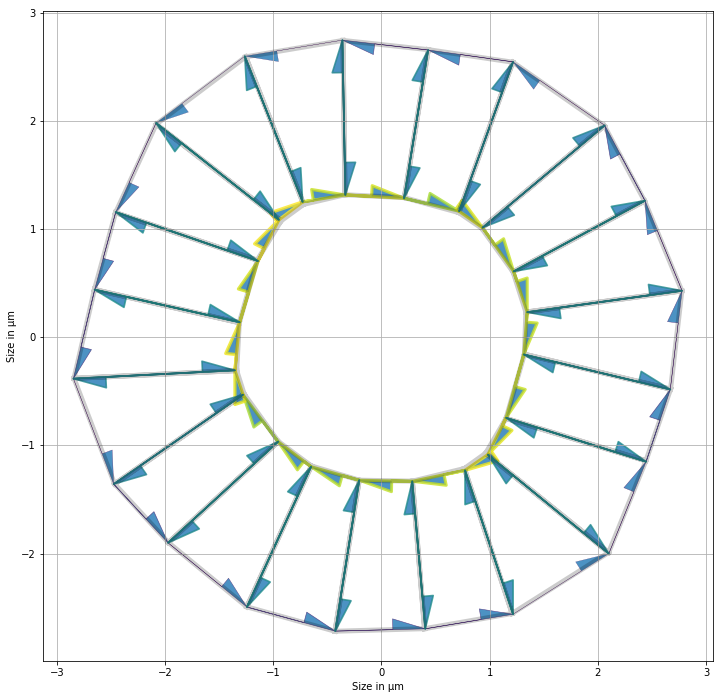

In [18]:
opt_mat_2_cst_organo = to_opt_organo.copy()
opt_mat_2_cst_organo.edge_df.line_tension = prepare_tensions(opt_mat_2_cst_organo, res_2_cst_areas_copy.x[:organo.Nf*3])
opt_mat_2_cst_organo.face_df.prefered_area = res_2_cst_areas_copy.x[4*organo.Nf:5*organo.Nf]
opt_mat_2_cst_organo.settings['prefered_lumen_vol'] = opt_mat_2_cst_organo.settings['lumen_volume'] + res_2_cst_areas_copy.x[-1]
Solver.find_energy_min(opt_mat_2_cst_organo, geom, model)
print_tensions(opt_mat_2_cst_organo, organo)
print('Distance from th organo to exp organo : ' +
      str(np.sum(np.linalg.norm(_distance(organo, opt_mat_2_cst_organo), axis=1))))
print('Distance from th tensions to exp tensions : ' +
      str(np.sum(np.linalg.norm(organo.edge_df.line_tension[:3*organo.Nf] -
                                opt_mat_2_cst_organo.edge_df.line_tension[:3*organo.Nf]))))

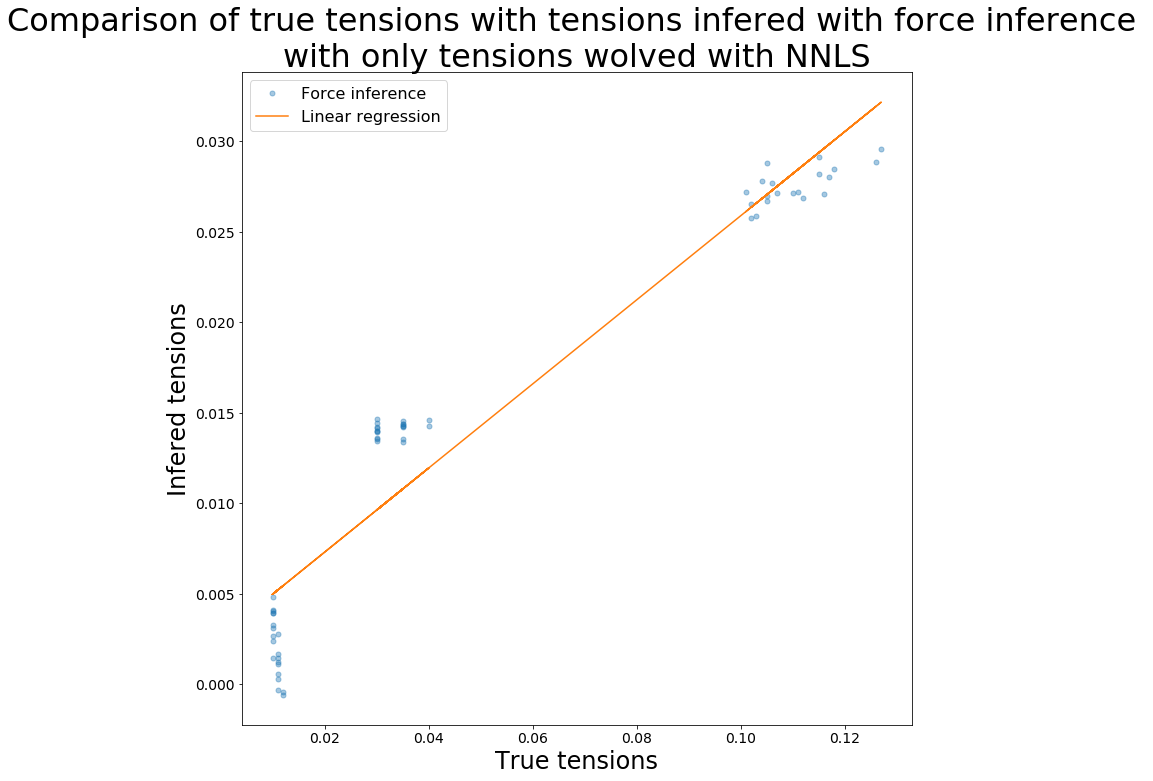

R value : 0.9545564497218485 
Standard error : 0.0027024020958856367


In [19]:
rendering_results(organo, organo.edge_df.line_tension[:3*organo.Nf],
                  opt_mat_2_cst_organo.edge_df.line_tension[:3*organo.Nf],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))